In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

### Test alpha distribution

In [2]:
alpha_code = """
functions { 

    real alpha_pdf(real x, real loc, real a) {

       real phi = normal_cdf(a, 0., 1.);
       return 1. / (pow(x-loc, 2.) * phi * sqrt(2.*pi())) * exp(-0.5 * pow((a-1 / (x-loc)), 2.));
    }
}

data {

    int N; // number of points to evaluate
    vector[N] x;
    real loc;
    real a;
}
generated quantities {

    vector[N] y;
    for (i in 1:N) {
        y[i] = alpha_pdf(x[i], loc, a);
    }
}
"""

In [3]:
loc = 5.
a = 5.

N = 100
xvals = np.linspace(3., 7., N)

In [4]:
alpha_pars = {
    'x': xvals,
    'N': N,
    'loc': loc,
    'a': a
}

In [5]:
alpha_stan = pystan.StanModel(model_code=alpha_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_23051fb493df679583096c15aa025fe1 NOW.


In [6]:
alpha_output = alpha_stan.sampling(data=alpha_pars, iter=1, chains=1, algorithm='Fixed_param')

In [7]:
yvals_stan = alpha_output.extract(['y'])['y'][0]

yvals_python = stats.alpha.pdf(xvals, loc=loc, a=a)

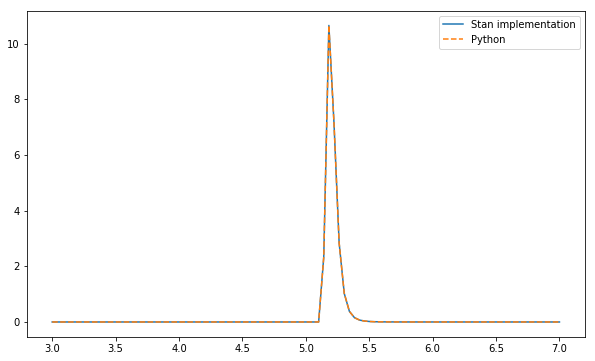

In [8]:
plt.figure(figsize=(10,6))
plt.plot(xvals, yvals_stan, label='Stan implementation')
plt.plot(xvals, yvals_python, label='Python', ls='--')
plt.legend()
plt.show()

### Test truncated lognorm

In [9]:
lognorm_code = """
functions {
    
    real truncated_lognorm_pdf(real x, real scale, real s, real upper) {
 
        if (x > upper) {
            return 0.;
        }

        else {
            real y;
            real prob;
            real norm;
            
            y = x / scale;
            prob = exp(lognormal_lpdf(y | 0., s)) / scale;
            norm = lognormal_cdf(upper/scale, 0., s);
            print(norm)
            return prob / norm;
        }
    }
}
    
data {

    int N; // number of points to evaluate
    vector[N] x;
    real scale;
    real s;
    real upper;
}
generated quantities {

    vector[N] y;
    for (i in 1:N) {
        y[i] = truncated_lognorm_pdf(x[i], scale, s, upper);
    }
}
"""

In [10]:
scale = 5.5
s = 5.5
upper = 6.

N = 100
xvals = np.linspace(3., 7., N)

In [11]:
lognorm_pars = {
    'x': xvals,
    'N': N,
    'scale': scale,
    's': s,
    'upper': upper
}

In [12]:
lognorm_stan = pystan.StanModel(model_code=lognorm_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b993eb4a808824303701d5d18b4f7113 NOW.


In [13]:
output_lognorm = lognorm_stan.sampling(data=lognorm_pars, algorithm='Fixed_param', iter=1, chains=1)

In [14]:
yvals_stan = output_lognorm.extract('y')['y'][0]

In [15]:
def truncated_lognorm(x, scale, s, upper):
    idx = np.where(x > upper)
    rv_lognorm = stats.lognorm(scale=scale, s=s)
    norm = rv_lognorm.cdf(upper)
    y = rv_lognorm.pdf(x) / norm
    y[idx] = 0
    return y

yvals_python = truncated_lognorm(xvals, scale, s, upper)

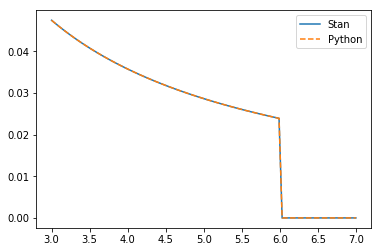

In [16]:
plt.plot(xvals, yvals_stan, label='Stan')
plt.plot(xvals, yvals_python, label='Python', ls='--')
plt.legend()
plt.show()

### Test polynomials to get parameters

In [17]:
# Load dict with fitted polynomial coefficients
with open('cascade_parametrization/NC_parameters.json', 'r') as fp:
    fitted_pars_NC = json.load(fp)

In [18]:
cascade_parametrization = """
functions {
    real eval_poly1d(real x, row_vector coeffs){
      int N = num_elements(coeffs);
      real res=0;
      for(i in 1:N){
        res += coeffs[i]*pow(x, N-i);
      }
      return res;
    }
    
    vector get_pars(real enu, matrix par_coeffs) {
        int N_pars = dims(par_coeffs)[1];
    
        vector[N_pars] pars;
        for (i in 1:N_pars) {
            pars[i] = eval_poly1d(enu, par_coeffs[i]);
        }
        return pars;
    }
}

data {
    int N;
    vector[N] enu;
    int N_pars;
    int N_degree_max;
    matrix[N_pars, N_degree_max] par_coeffs;
}

generated quantities {
    matrix[N, N_pars] y;
    for (i in 1:N) {
        y[i] = to_row_vector(get_pars(enu[i], par_coeffs));
    }
}

"""

In [19]:
poly_stan = pystan.StanModel(model_code=cascade_parametrization)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bde0c21963ff560ec09396978f81e1d NOW.


In [20]:
# Polynomial coefficients from fit
poly_coeffs =\
[[0., 0., 0., -0.01060352615027924, 1.1466847121380057, -0.2655725308908998],
[0., 0.003517390934166036, -0.1631310345503043, 2.087777101281729, -11.054585505129603, 23.384829662219744], 
[0., 0., 0., 0.08908925898456099, -0.1554901220068788, 3.0802408166264104], 
[0., 0., -0.005788515892469659, 0.10456200642070881, -0.5804268972086728, 1.0765491915970327], 
[0.08464000462418471, -2.4725257280380277, 28.69383769042796, -165.19309146848974, 471.1742238099837, -531.4737819584182]]

poly_coeffs = np.asarray(poly_coeffs)

In [21]:
poly_coeffs = np.asarray(fitted_pars_NC['nue_NC'])

In [22]:
N = 100
enu = np.linspace(4.5, 7., N)

N_pars, N_deg_max = poly_coeffs.shape
poly_pars = {
    'N': N,
    'enu': enu,
    'N_pars': N_pars,
    'N_degree_max': N_deg_max,
    'par_coeffs': poly_coeffs
}

In [23]:
poly_output = poly_stan.sampling(data=poly_pars, algorithm='Fixed_param', iter=1, chains=1)

In [24]:
polys = poly_output.extract('y')['y'][0]

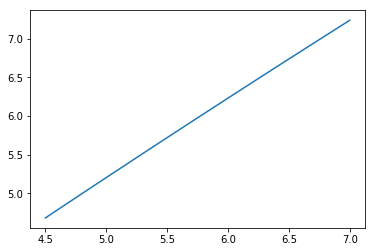

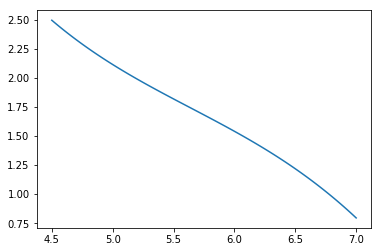

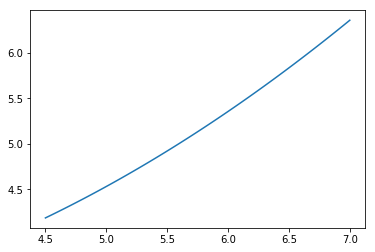

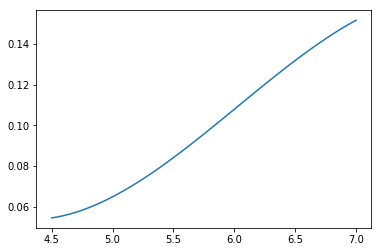

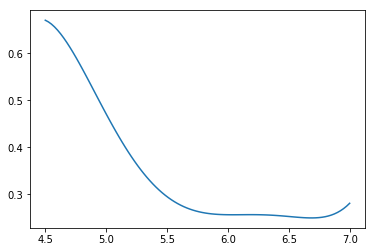

In [25]:
for par in polys.T:
    plt.plot(enu, par)
    plt.show()

### Full parametrization

['generation_weight' 'prim_coszenith' 'rec_coszenith' 'dep_energy'
 'prim_type' 'rec_energy' 'prim_energy' 'prim_azimuth' 'rec_azimuth'
 'bjorken_y' 'conv_flux']
Number of samples: 10000000


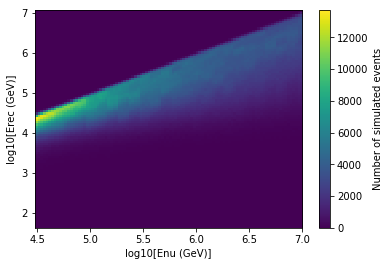

In [26]:
import pandas as pd

pars = {}
pars['neutrino_type']='nue' # nuebar, numu, numubar, nutau, nutaubar
pars['interaction_type']='NC' # CC, NC
pars['gamma']=1.0
pars['lEmin']=np.log10(3e4)  # Emin >= 3.0
pars['lEmax']=7.0  # Emax <= 7.0
pars['event_type'] = 'cascades'

# Load file 
outfile = './output/wconv_for_kde_prod/'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_'+str(pars['event_type'])+'_conv.h5'
df = pd.read_hdf(outfile)
print df.columns.values

print "Number of samples:", len(df)

binc_NC, eprim_edges_NC, erec_edges_NC, _ = plt.hist2d(np.log10(df['prim_energy']), np.log10(df['rec_energy']), bins=[100, 100])
cb = plt.colorbar()
cb.set_label('Number of simulated events')
plt.xlabel('log10[Enu (GeV)]')
plt.ylabel('log10[Erec (GeV)]')
plt.show()

eprim_bins_NC = (eprim_edges_NC[:-1] + eprim_edges_NC[1:]) / 2.
erec_bins_NC = (erec_edges_NC[:-1] + erec_edges_NC[1:]) / 2.
erec_binw_NC = erec_bins_NC[1] - erec_bins_NC[0]

In [27]:
cascade_NC_code = """
functions {
    real eval_poly1d(real x, row_vector coeffs){
      int N = num_elements(coeffs);
      real res=0;
      for(i in 1:N){
        res += coeffs[i]*pow(x, N-i);
      }
      return res;
    }
    
    vector get_pars(real x, matrix par_coeffs, int N_pars) {
    
        vector[N_pars] pars;
        for (i in 1:N_pars) {
            pars[i] = eval_poly1d(x, par_coeffs[i]);
        }
        return pars;
    }
    
    real alpha_pdf(real x, real loc, real a) {
    
       real phi = normal_cdf(a, 0., 1.);
       return 1. / (pow(x-loc, 2.) * phi * sqrt(2.*pi())) * exp(-0.5 * pow((a-1 / (x-loc)), 2.));
    
    }
    
    real truncated_lognorm_pdf(real x, real scale, real s, real upper) {
    
        if (x > upper) {
            return 0.;
        }
    
        else {
            real y;
            real prob;
            real norm;
    
            y = x / scale;
            prob = exp(lognormal_lpdf(y | 0., s)) / scale;
            norm = lognormal_cdf(upper/scale, 0., s);
            print(norm)
            return prob / norm;
        }
    }
    
    real erec_NC_lpdf(real erec, real enu, vector pars) {
    
        real alpha = alpha_pdf(-erec, -pars[1], pars[2]);
        real lognorm = truncated_lognorm_pdf(erec, pars[3], pars[4], enu);
        real prob = pars[5] * alpha + (1-pars[5]) * lognorm;
        return log(prob);
    }
}

data {
    int N;
    vector[N] x;
    int N_pars;
    int N_degree_max;
    matrix[N_pars, N_degree_max] par_coeffs;
    real enu;
}

generated quantities {
    vector[N] y;
    vector[N_pars] pars = get_pars(enu, par_coeffs, N_pars);
    for (i in 1:N) {
        y[i] = erec_NC_lpdf(x[i]| enu, pars);
    }
}
"""

In [28]:
cascade_NC_stan = pystan.StanModel(model_code=cascade_NC_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf4dff22b7192ac083d82feb317c7f9f NOW.


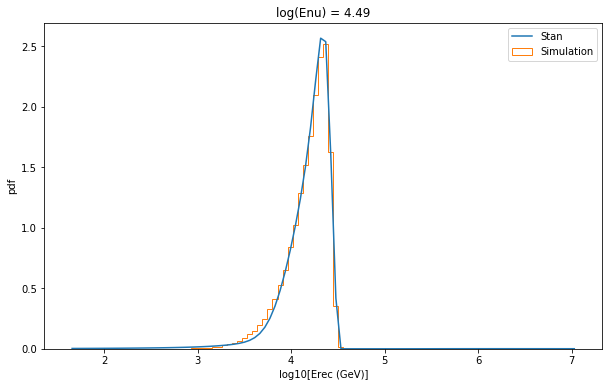

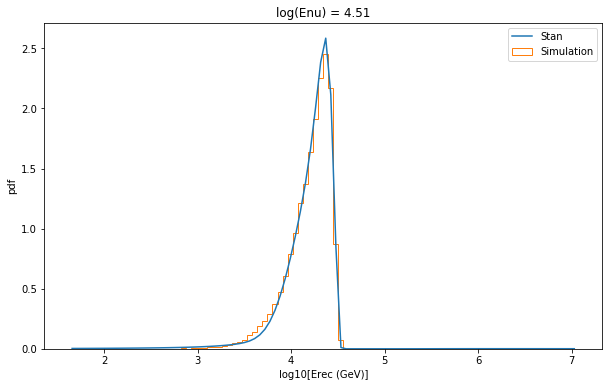

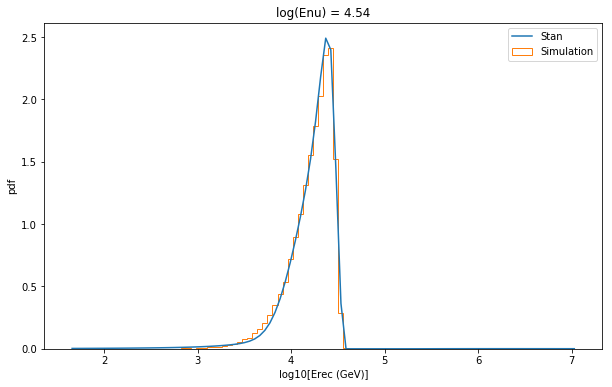

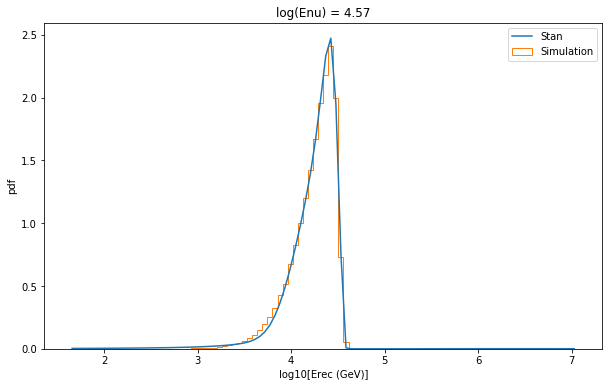

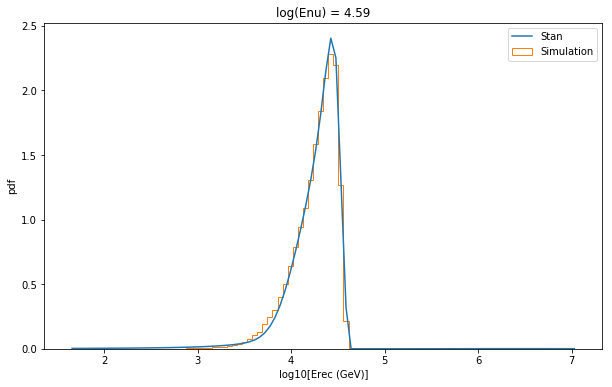

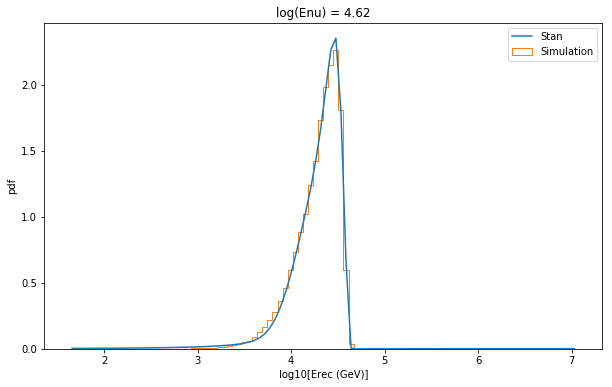

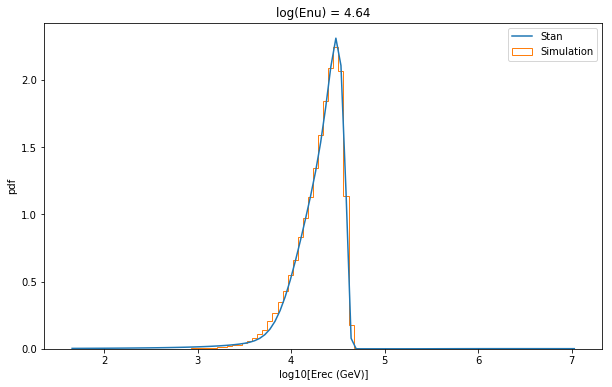

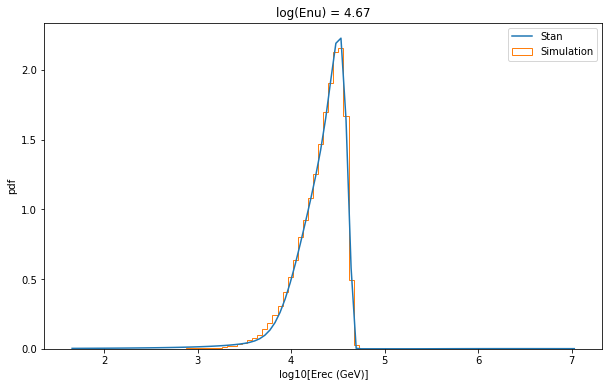

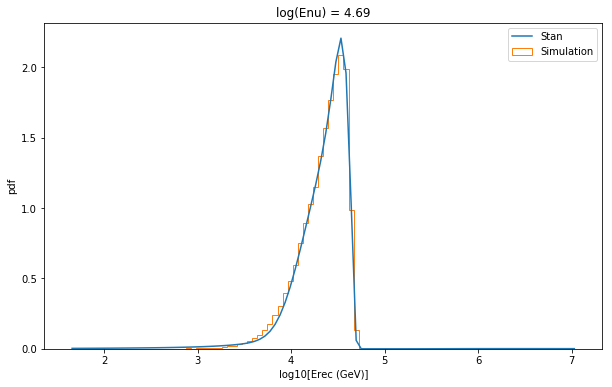

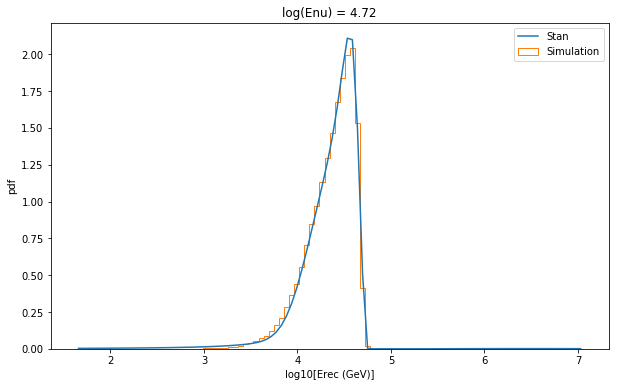

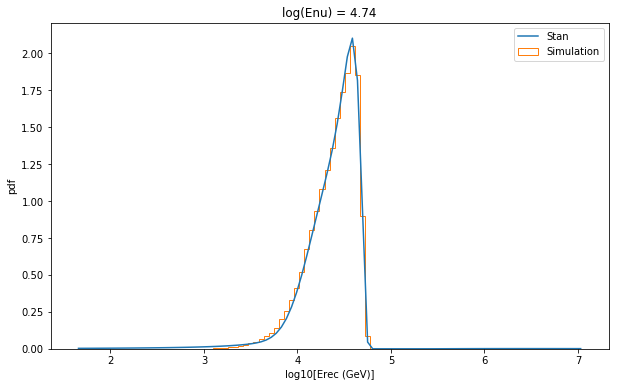

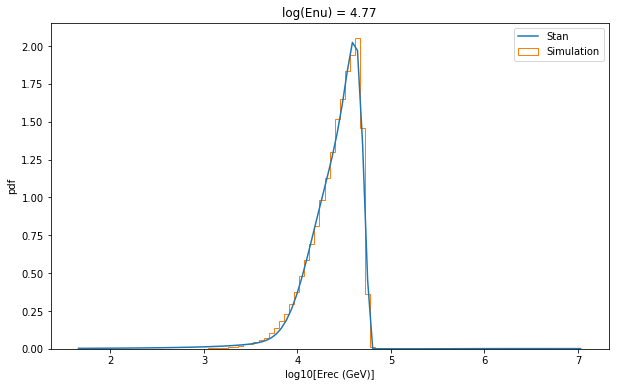

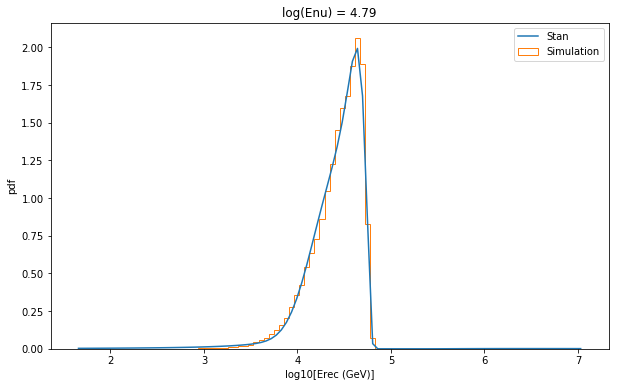

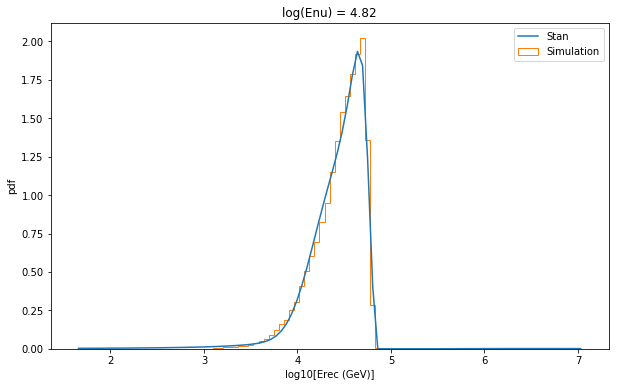

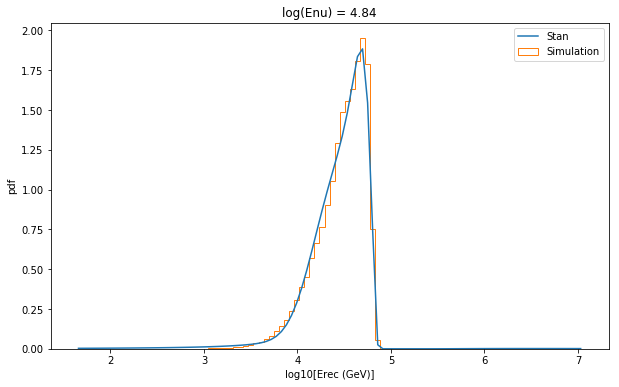

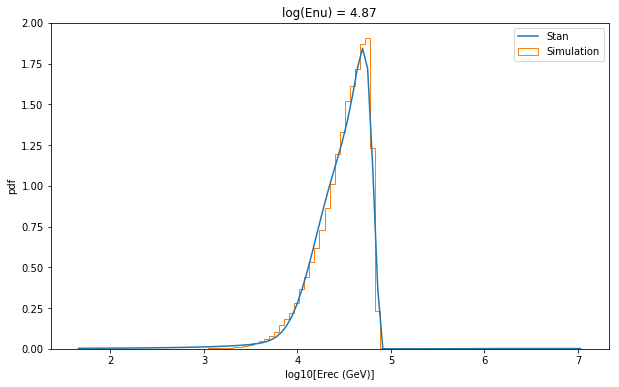

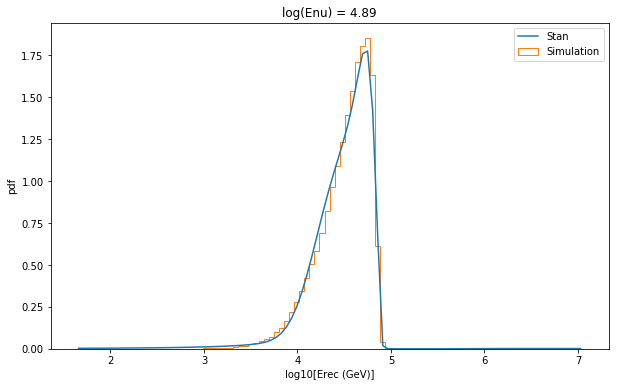

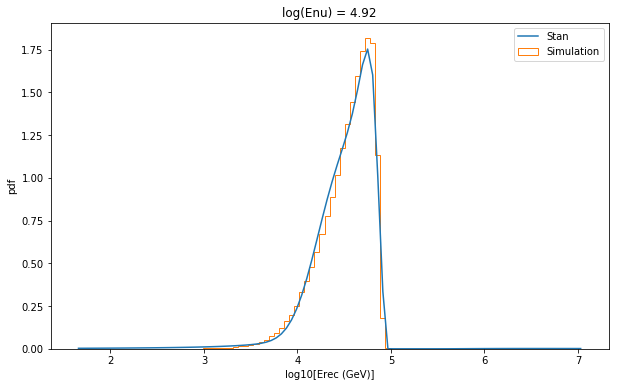

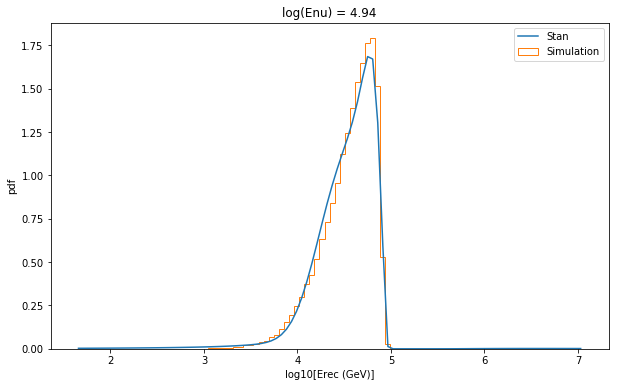

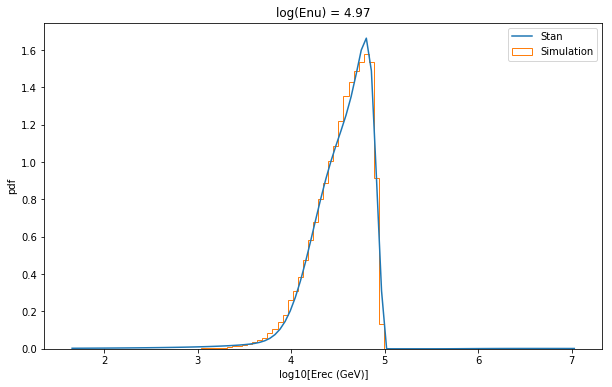

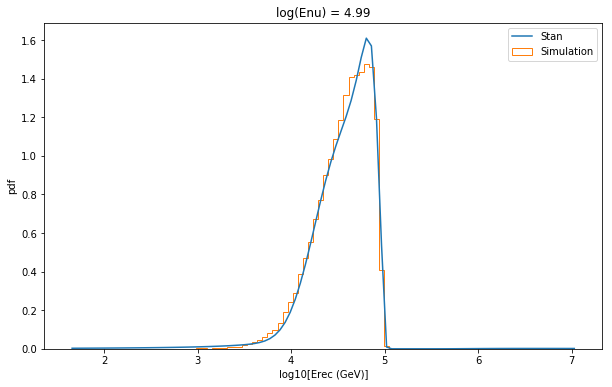

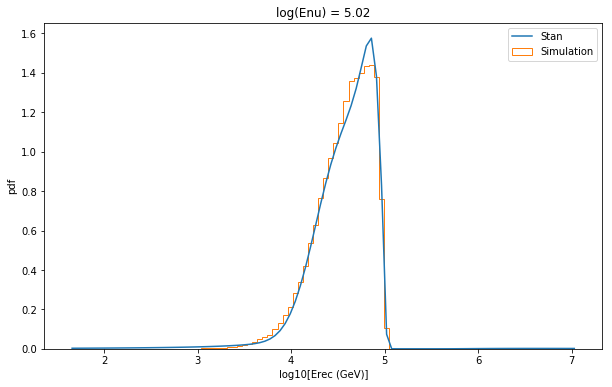

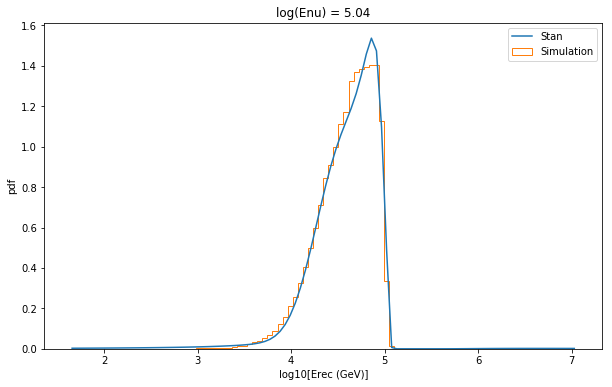

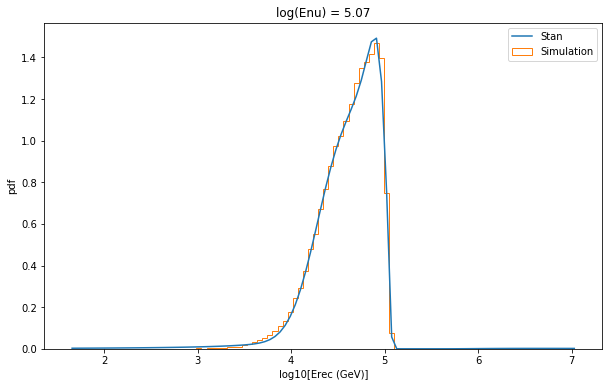

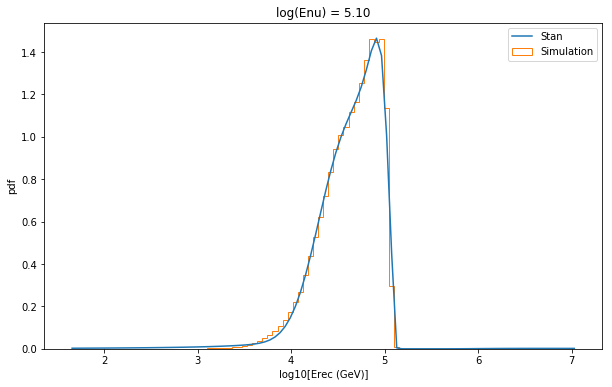

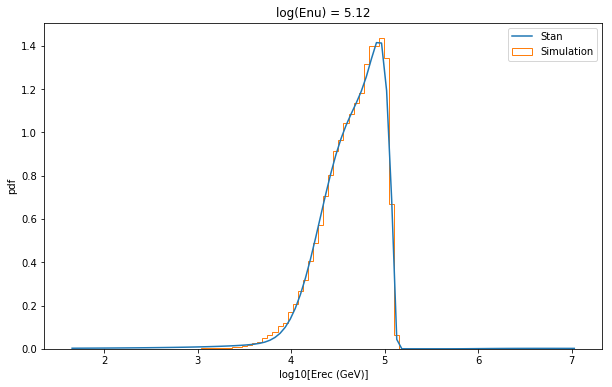

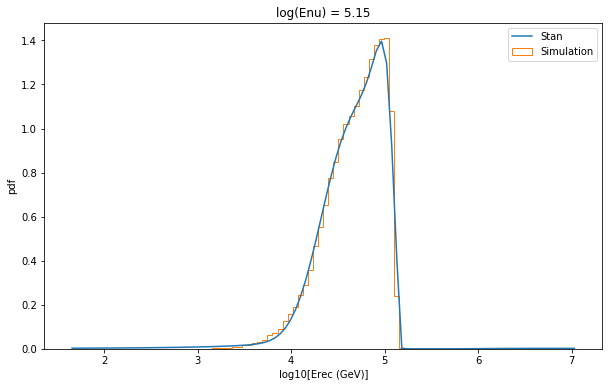

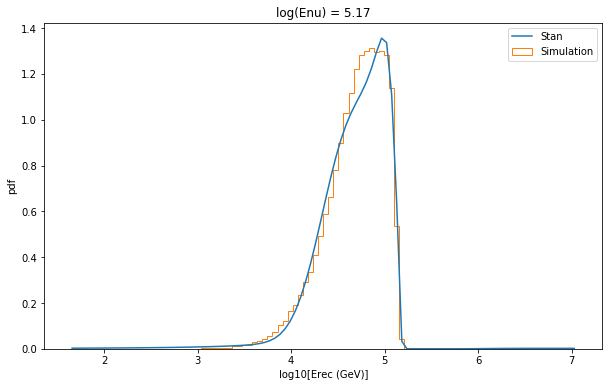

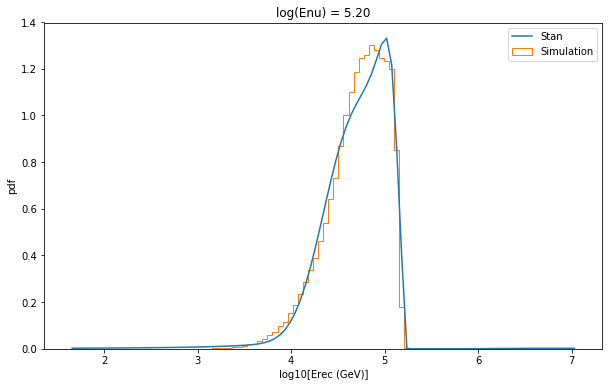

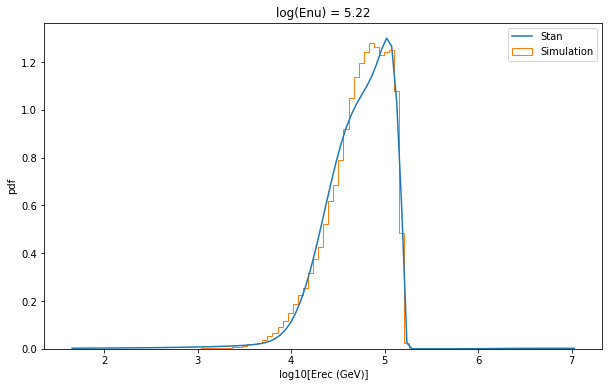

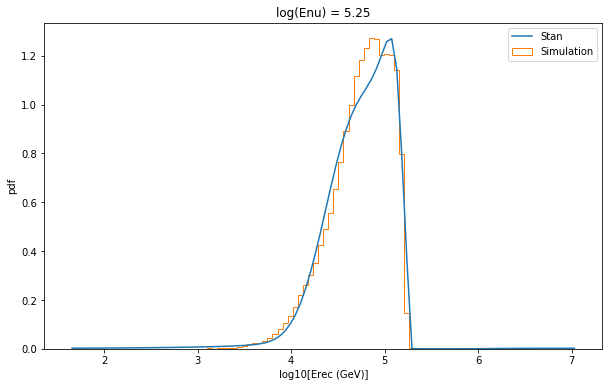

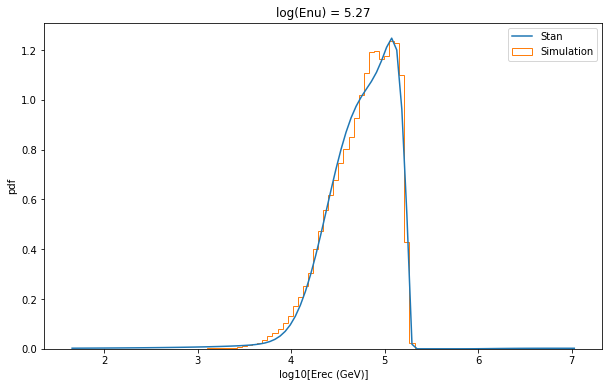

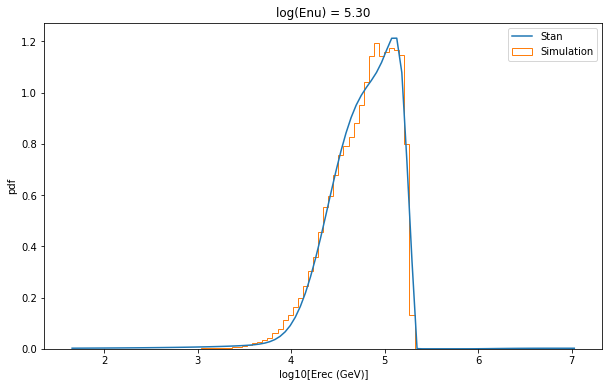

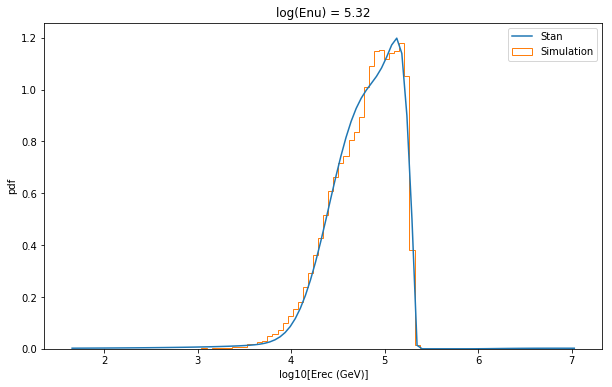

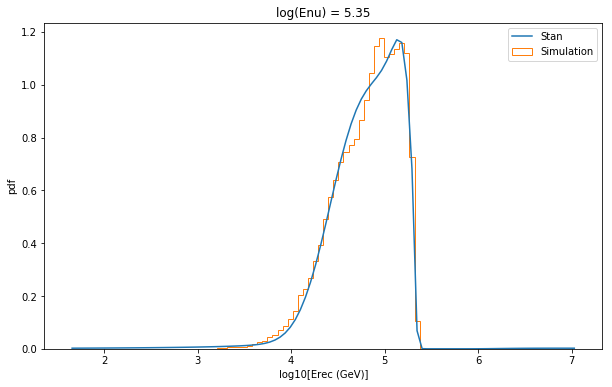

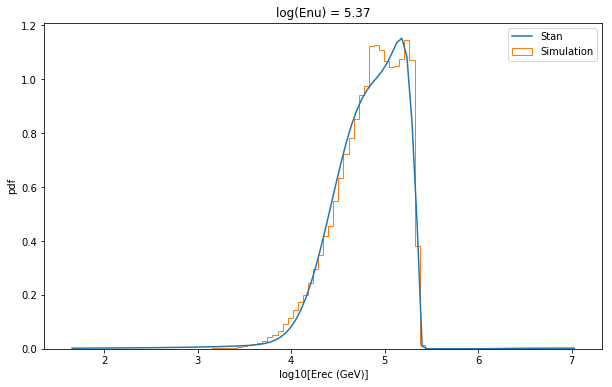

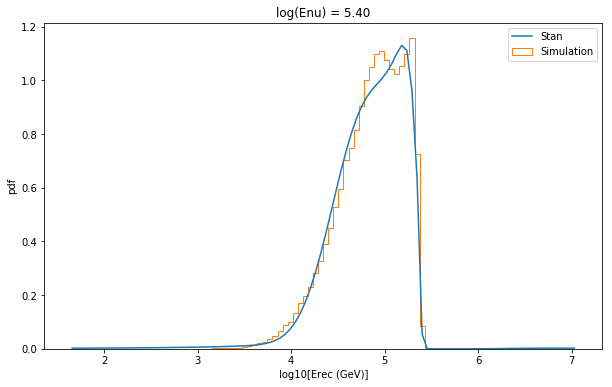

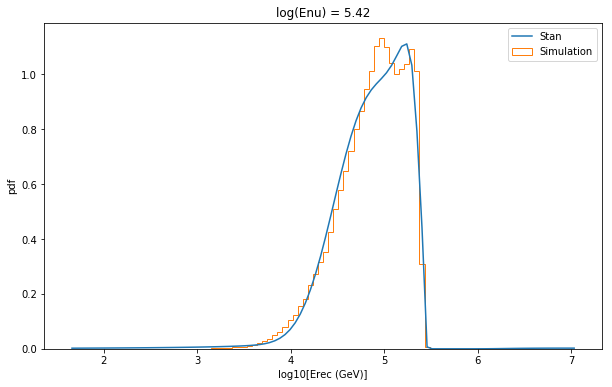

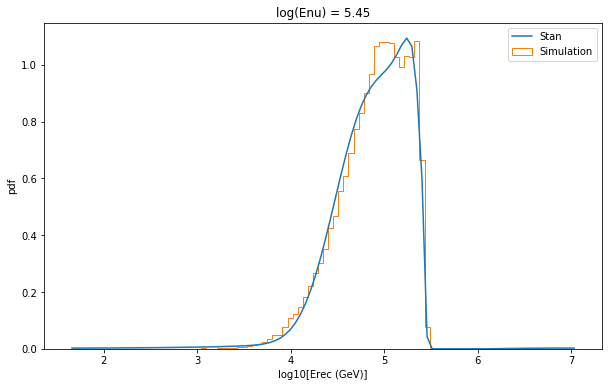

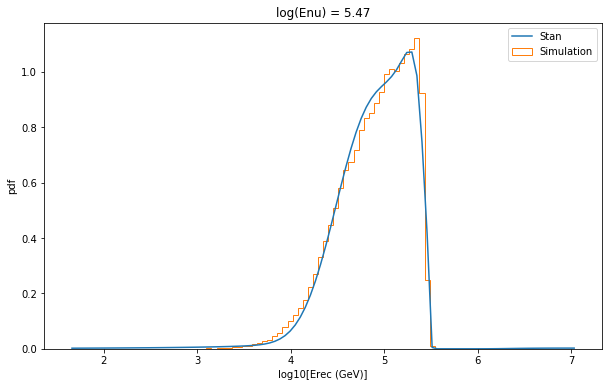

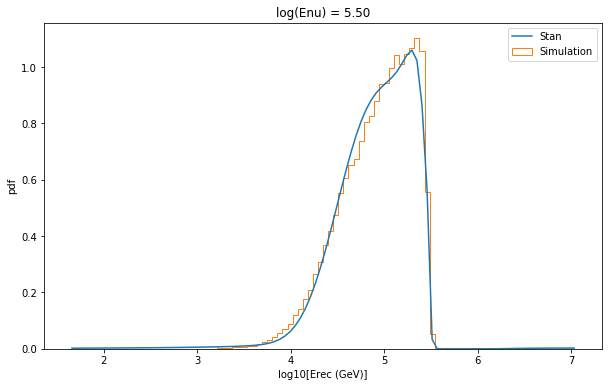

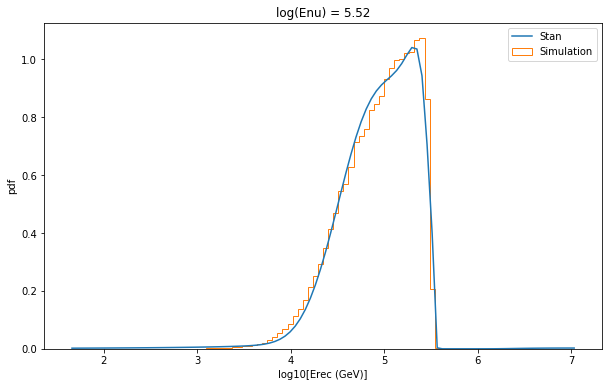

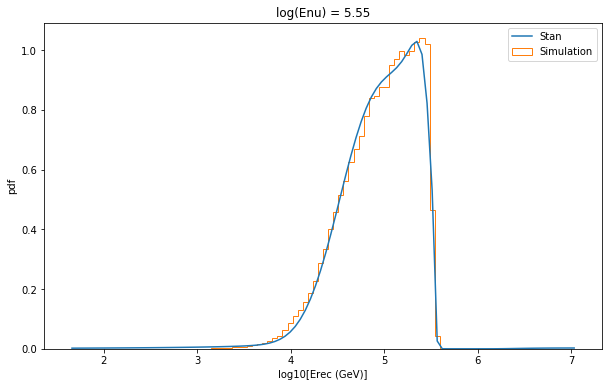

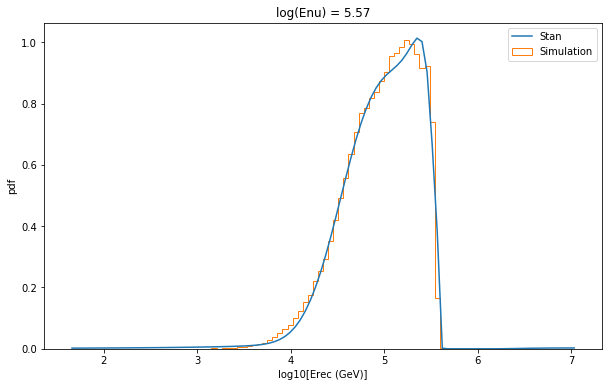

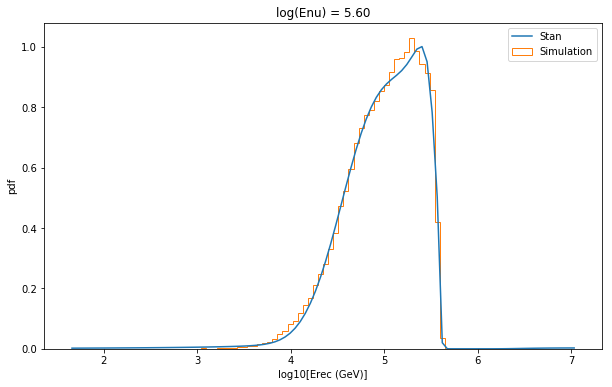

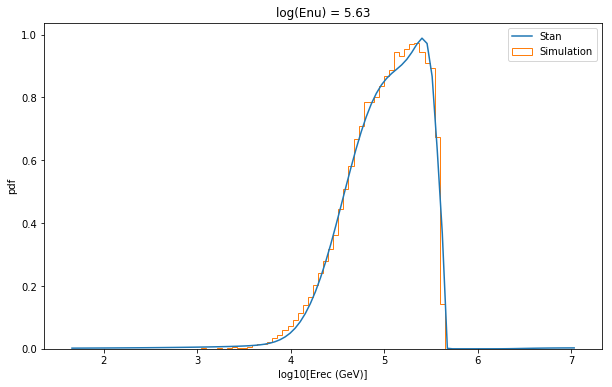

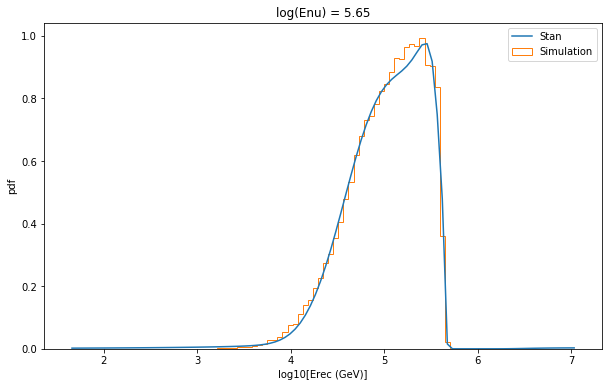

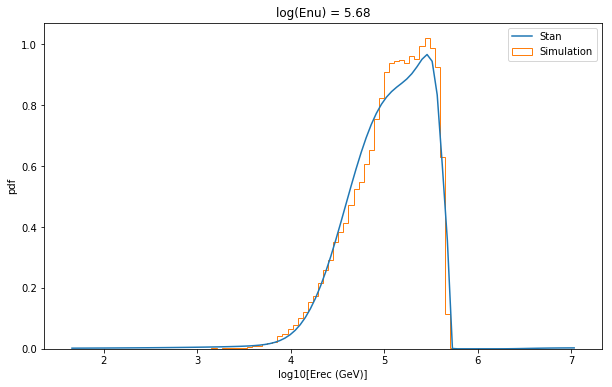

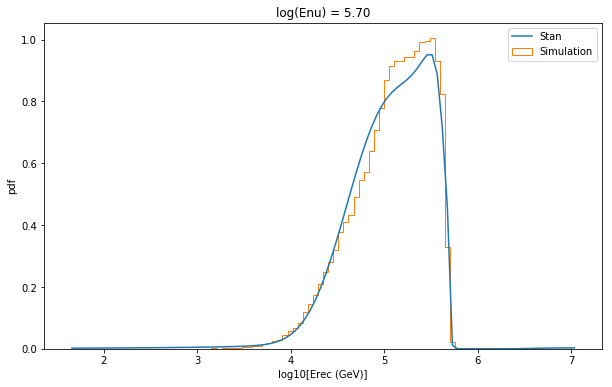

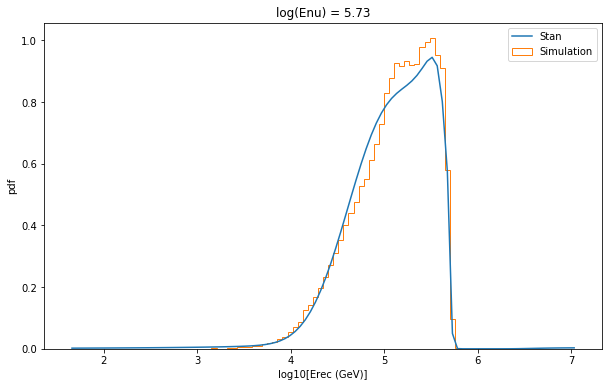

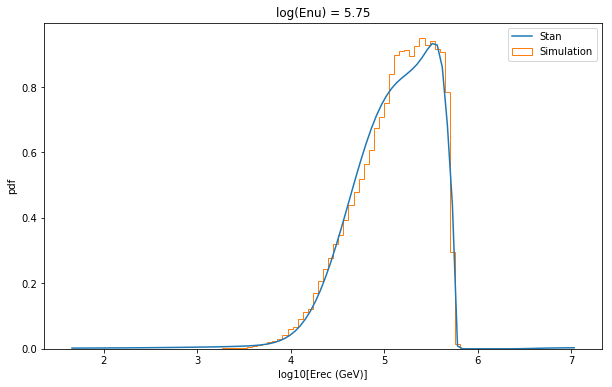

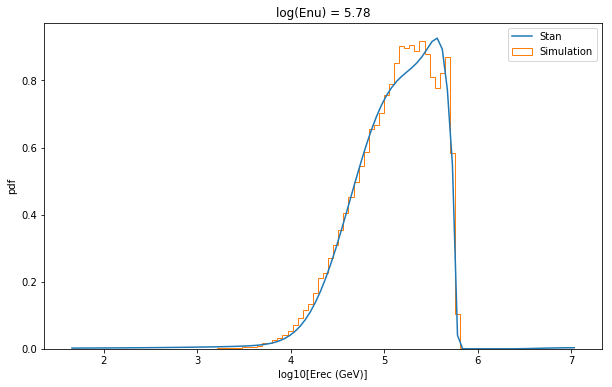

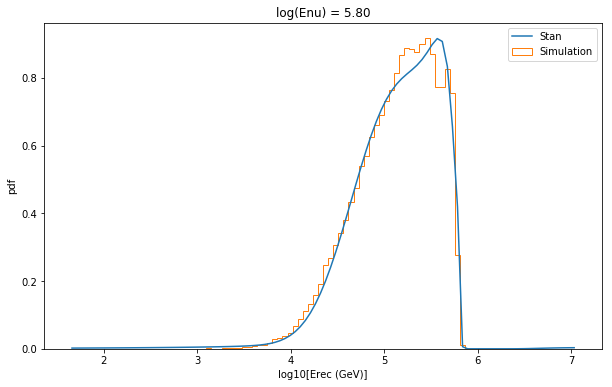

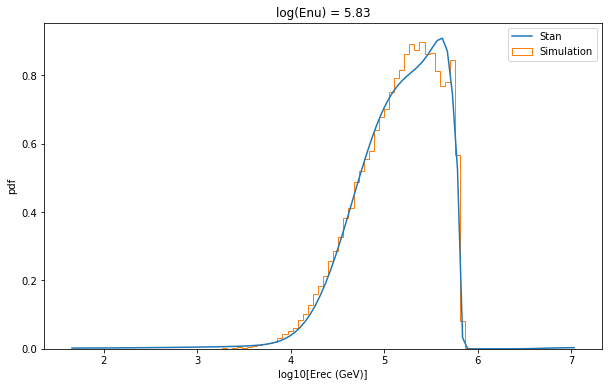

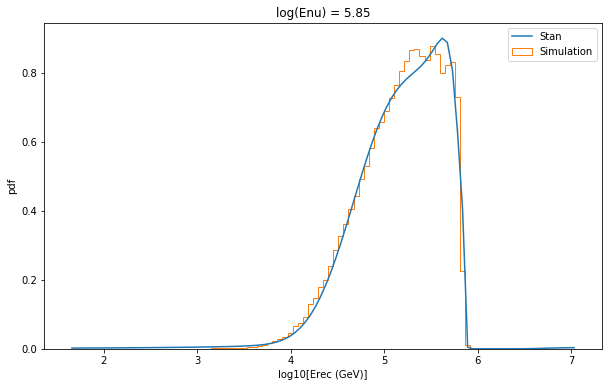

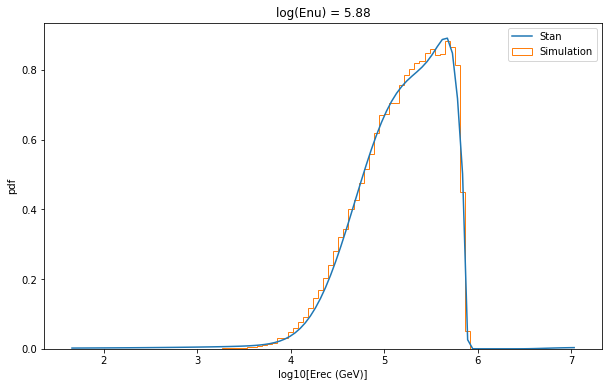

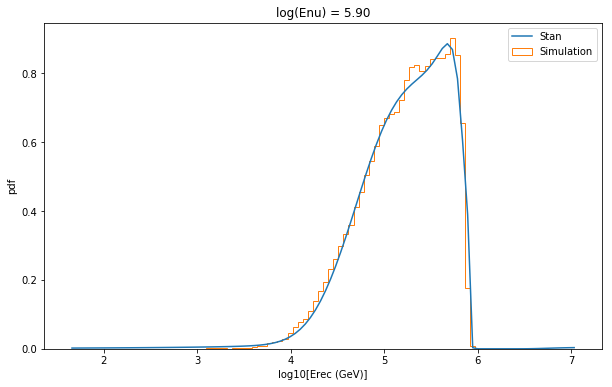

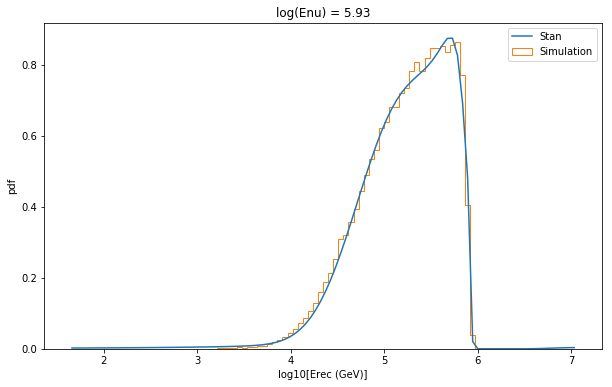

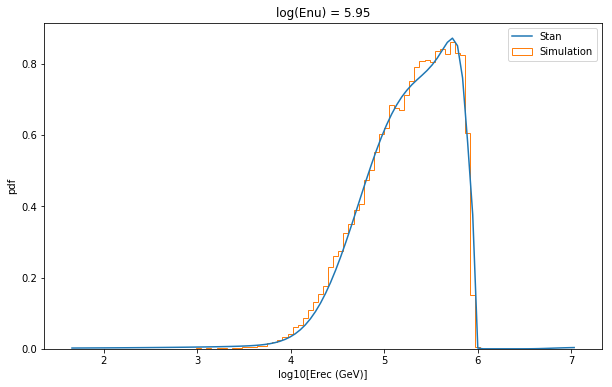

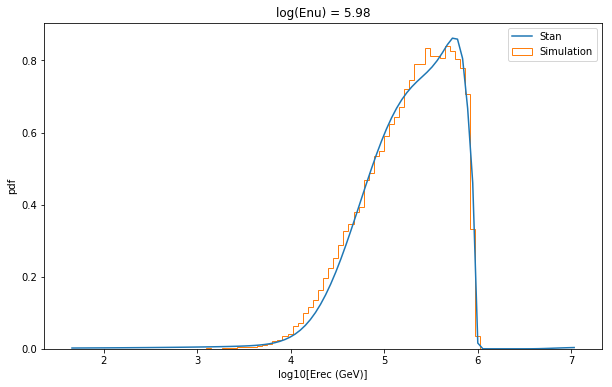

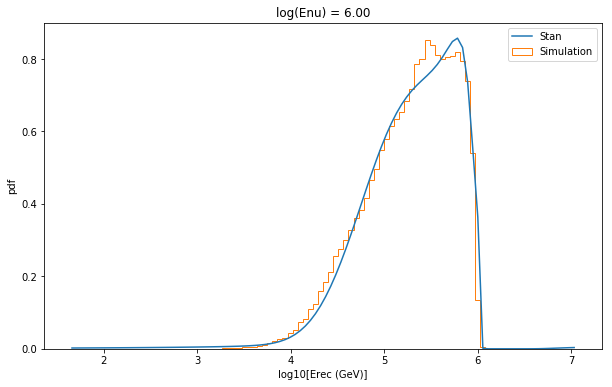

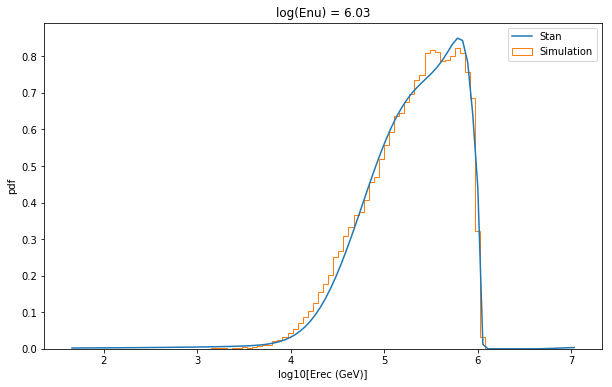

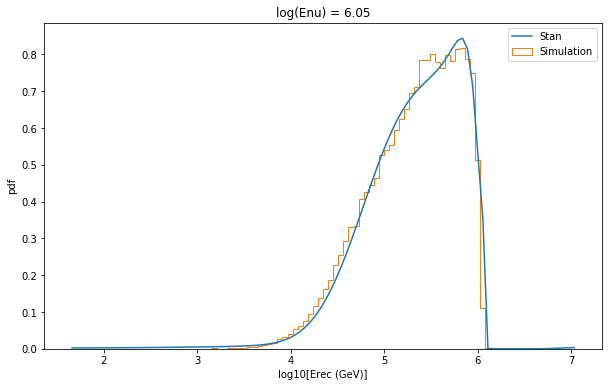

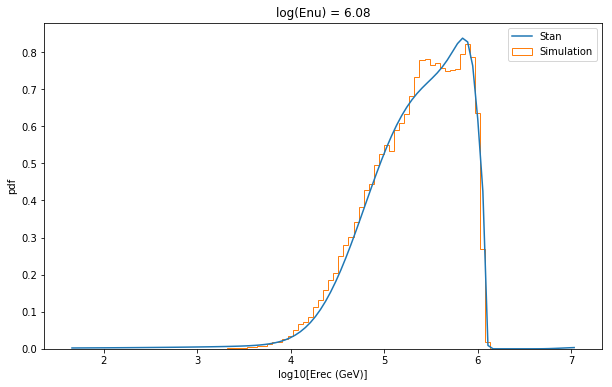

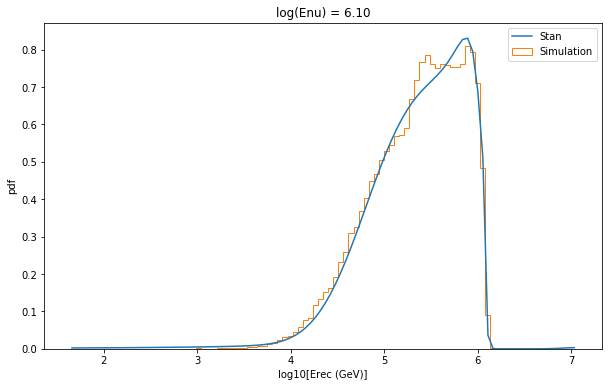

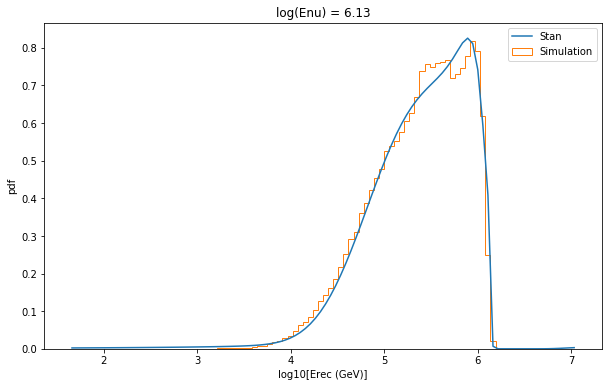

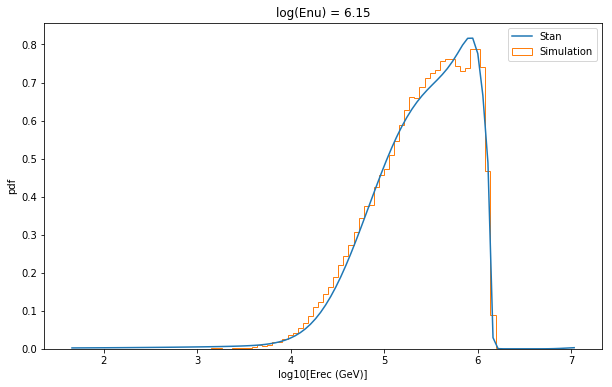

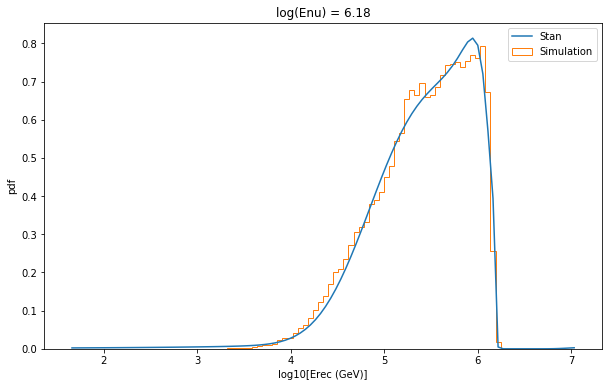

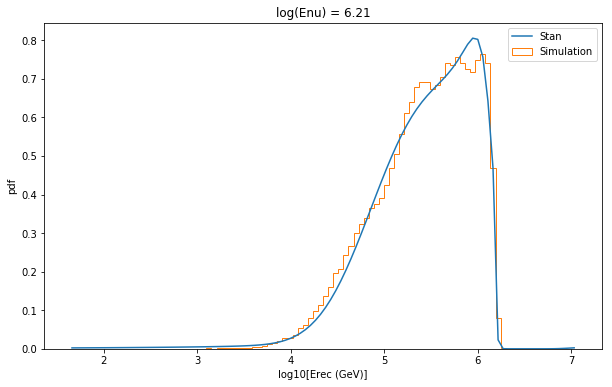

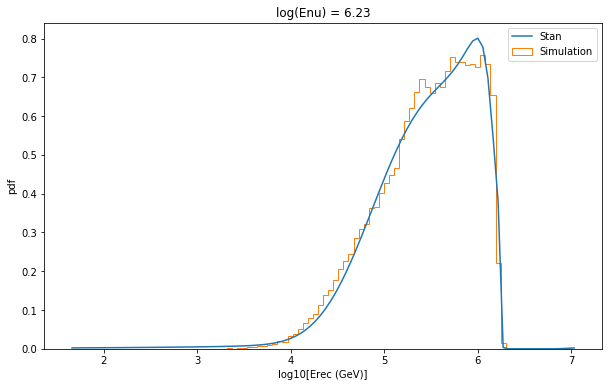

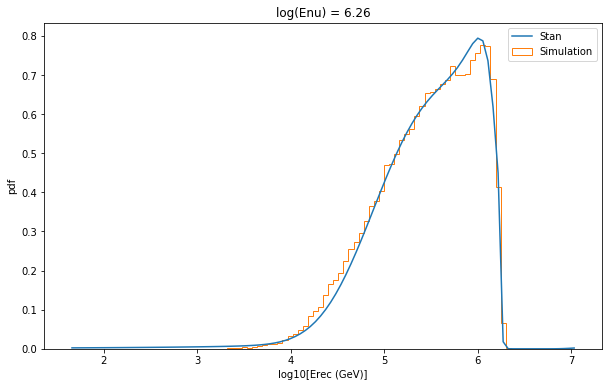

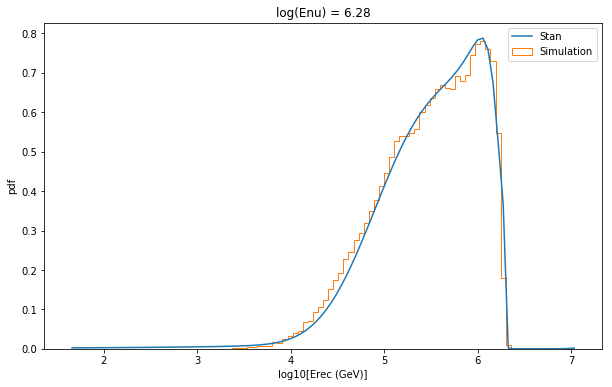

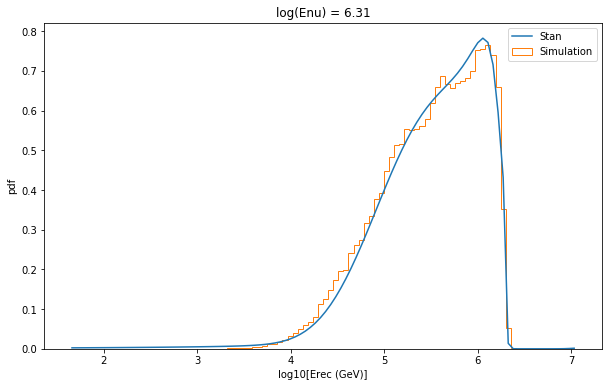

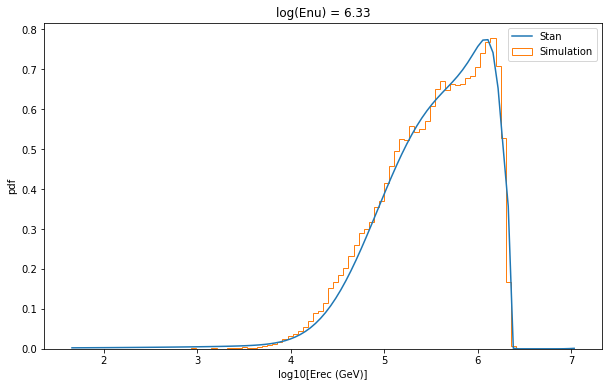

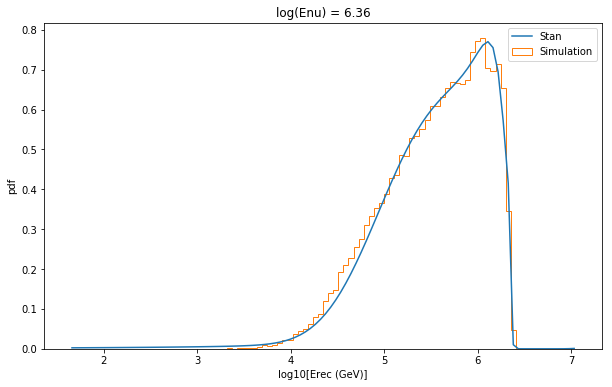

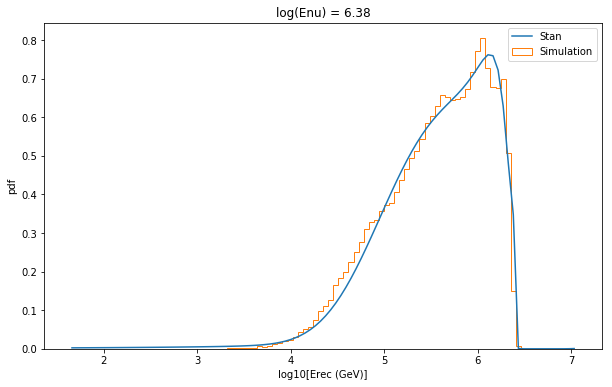

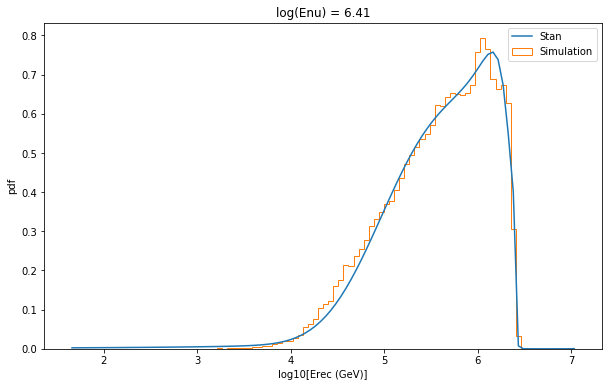

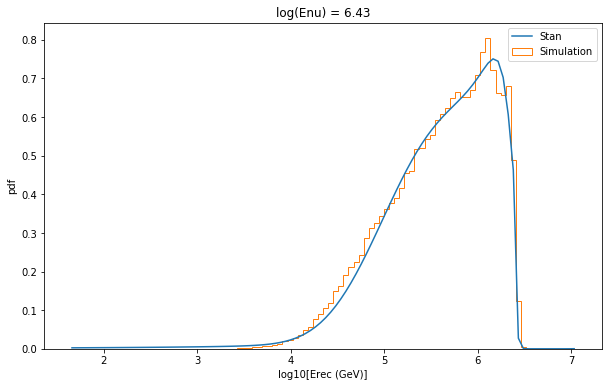

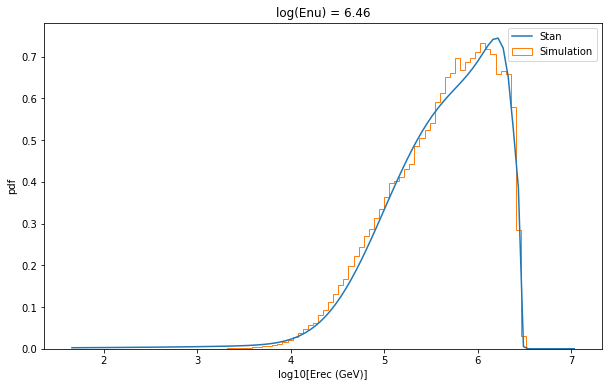

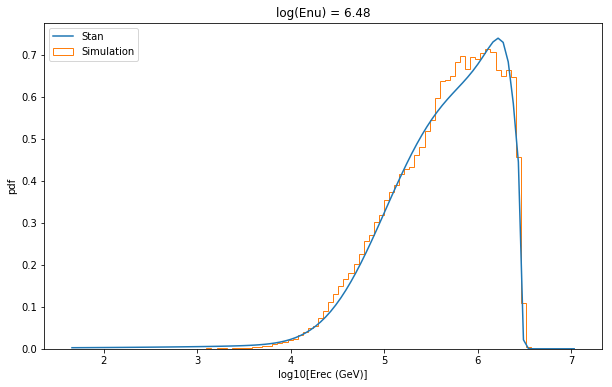

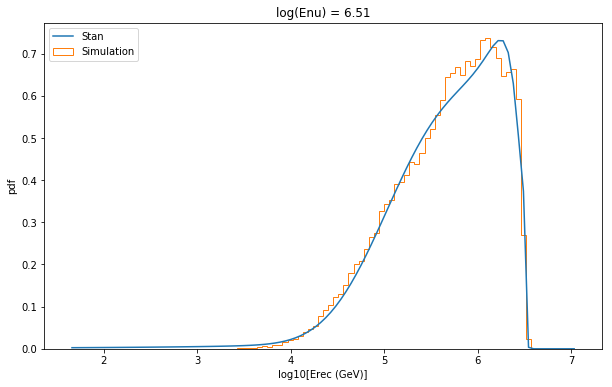

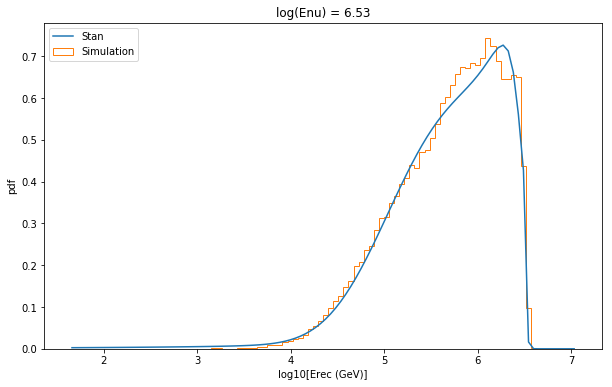

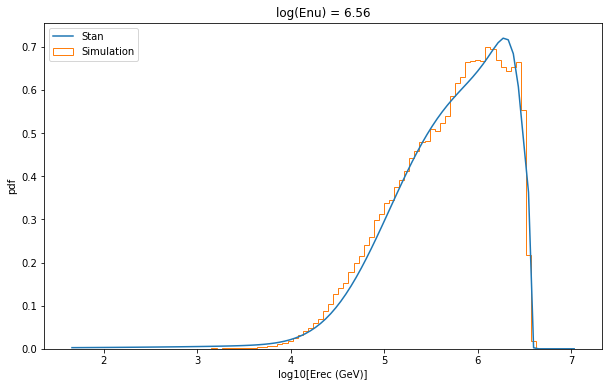

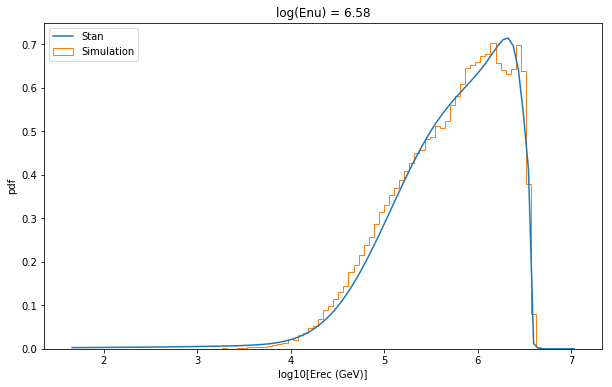

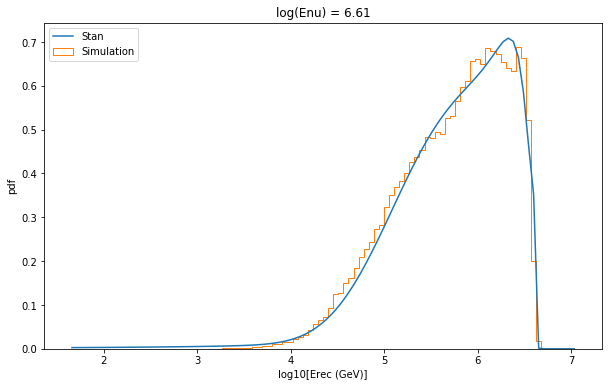

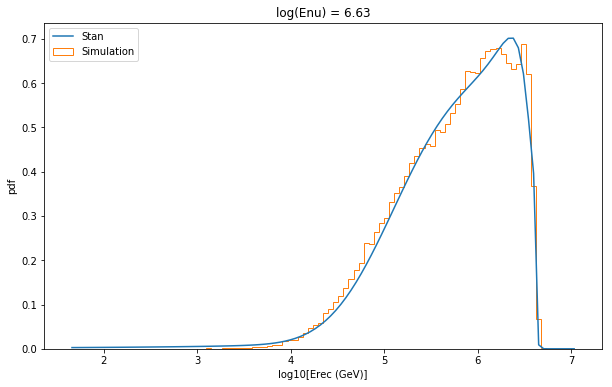

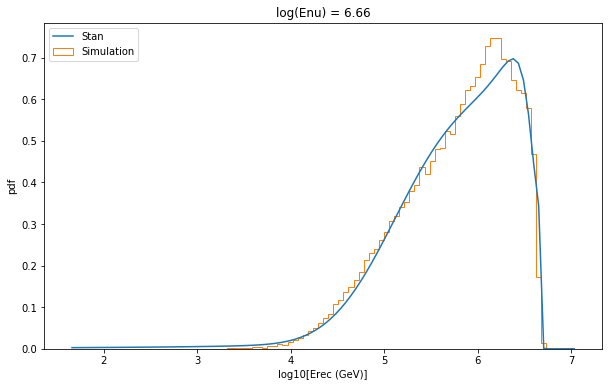

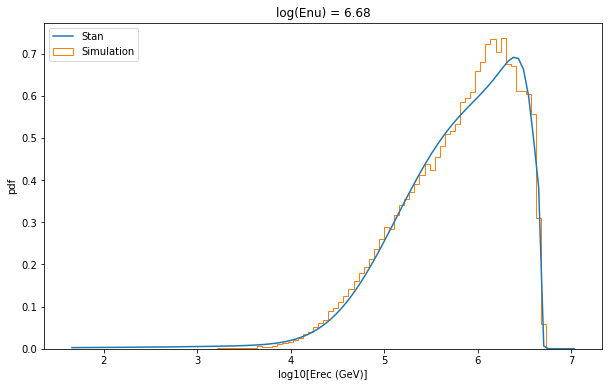

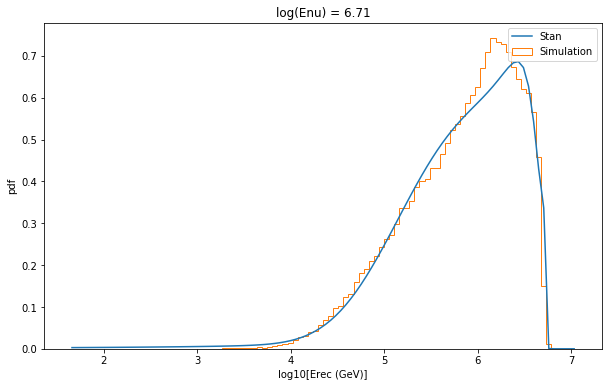

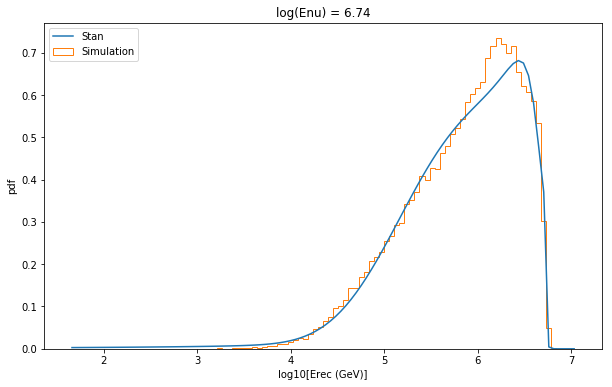

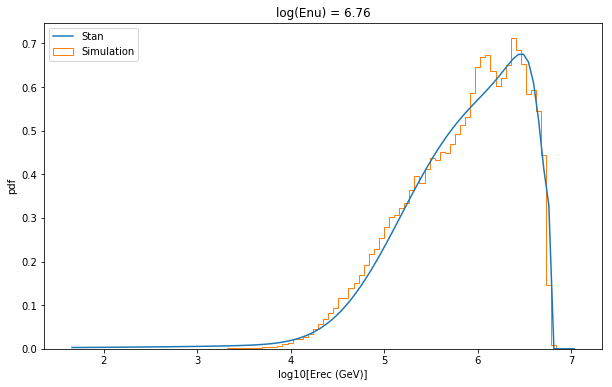

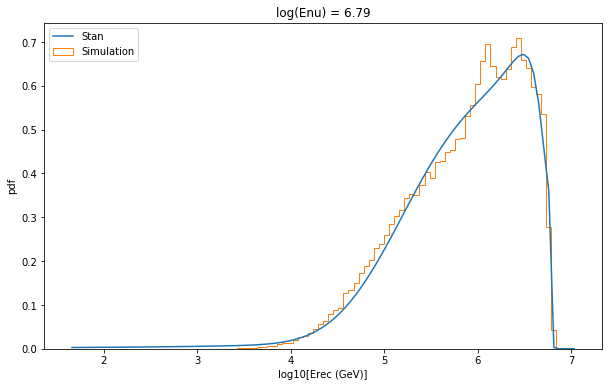

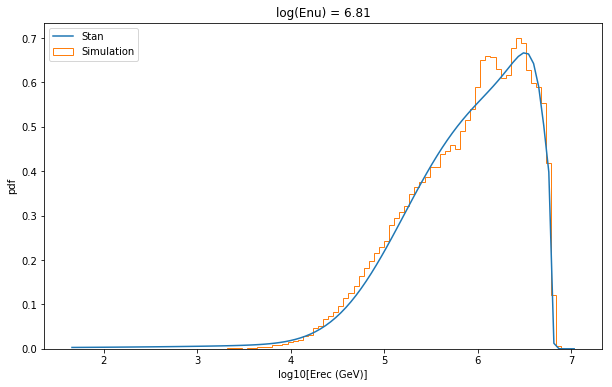

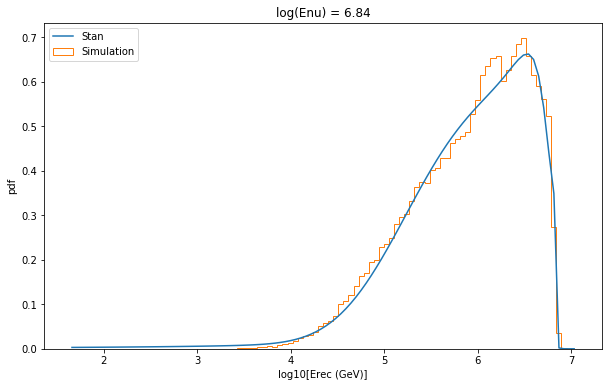

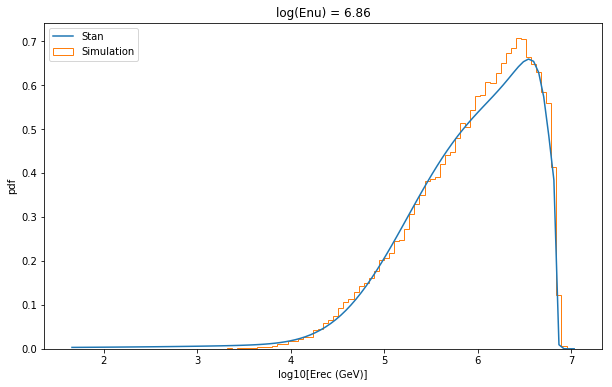

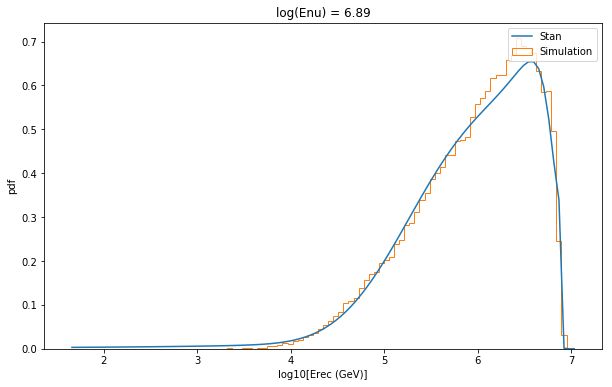

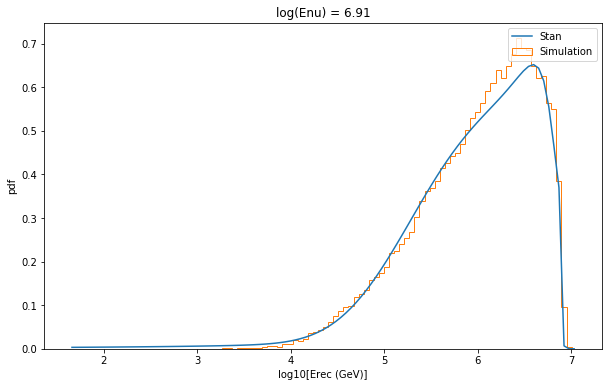

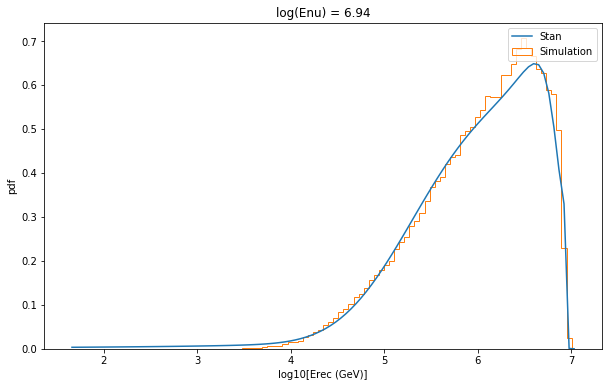

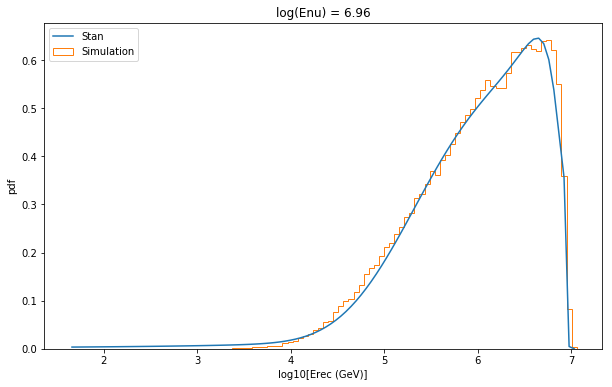

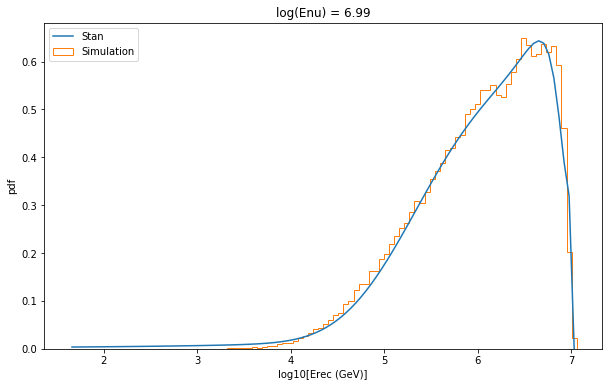

In [29]:
for enu, sl in zip(eprim_bins_NC, binc_NC):
    x = erec_bins_NC
    N = len(erec_bins_NC)
    
    N_pars, N_deg_max = poly_coeffs.shape
    
    
    param_pars = {
        'N': N,
        'x': x,
        'N_pars': N_pars,
        'N_degree_max': N_deg_max,
        'par_coeffs': poly_coeffs,
        'enu': enu
    }
    
    cascade_output = cascade_NC_stan.sampling(data=param_pars, algorithm='Fixed_param', iter=1, chains=1)
    prob = np.exp(cascade_output.extract('y')['y'][0])
    plt.figure(figsize=(10,6))
    plt.title('log(Enu) = %.2f' %(enu))
    plt.plot(erec_bins_NC, prob, label='Stan')
    sl = sl / sl.sum() / erec_binw_NC
    plt.hist(erec_bins_NC, weights=sl, bins = erec_edges_NC, label='Simulation', histtype='step')
    plt.xlabel('log10[Erec (GeV)]')
    plt.ylabel('pdf')
    plt.legend()
    plt.show()

### CC

In [30]:
cascade_CC_code = """
functions {
    real eval_poly1d(real x, row_vector coeffs){
      int N = num_elements(coeffs);
      real res=0;
      for(i in 1:N){
        res += coeffs[i]*pow(x, N-i);
      }
      return res;
    }
    
    vector get_pars(real x, matrix par_coeffs, int N_pars) {
    
        vector[N_pars] pars;
        for (i in 1:N_pars) {
            pars[i] = eval_poly1d(x, par_coeffs[i]);
        }
        return pars;
    }
    real erec_CC_lpdf(real erec, real enu, matrix par_coeffs, int N_pars) {
        vector[N_pars] pars = get_pars(enu, par_coeffs, N_pars);
        return lognormal_lpdf(erec/pars[1]| 0., pars[2]) - log(pars[1]);
    }
}

data {
    int N;
    vector[N] x;
    int N_pars;
    int N_degree_max;
    matrix[N_pars, N_degree_max] par_coeffs;
    real enu;
}

generated quantities {
    vector[N] y;
    vector[N_pars] pars = get_pars(enu, par_coeffs, N_pars);
    for (i in 1:N) {
        y[i] = erec_CC_lpdf(x[i]| enu, par_coeffs, N_pars);
    }
}
"""

In [31]:
cascade_CC_stan = pystan.StanModel(model_code=cascade_CC_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a7418e4f3ec934c7bc770c76cf781f0 NOW.


['generation_weight' 'prim_coszenith' 'rec_coszenith' 'dep_energy'
 'prim_type' 'rec_energy' 'prim_energy' 'prim_azimuth' 'rec_azimuth'
 'bjorken_y' 'conv_flux']
Number of samples: 10000000


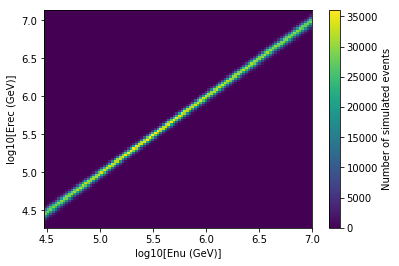

In [32]:
import pandas as pd

pars = {}
pars['neutrino_type']='nue' # nuebar, numu, numubar, nutau, nutaubar
pars['interaction_type']='CC' # CC, NC
pars['gamma']=1.0
pars['lEmin']=np.log10(3e4)  # Emin >= 3.0
pars['lEmax']=7.0  # Emax <= 7.0
pars['event_type'] = 'cascades'

# Load file 
outfile = './output/wconv_for_kde_prod/'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_'+str(pars['event_type'])+'_conv.h5'
df = pd.read_hdf(outfile)
print df.columns.values

print "Number of samples:", len(df)

binc_CC, eprim_edges_CC, erec_edges_CC, _ = plt.hist2d(np.log10(df['prim_energy']), np.log10(df['rec_energy']), bins=[100, 100])
cb = plt.colorbar()
cb.set_label('Number of simulated events')
plt.xlabel('log10[Enu (GeV)]')
plt.ylabel('log10[Erec (GeV)]')
plt.show()

eprim_bins_CC = (eprim_edges_CC[:-1] + eprim_edges_CC[1:]) / 2.
erec_bins_CC = (erec_edges_CC[:-1] + erec_edges_CC[1:]) / 2.
erec_binw_CC = erec_bins_CC[1] - erec_bins_CC[0]

In [33]:
with open('cascade_parametrization/CC_parameters.json', 'r') as fp:
    fitted_pars_CC = json.load(fp)
    
polypars_CC = np.asarray(fitted_pars_CC['numu_CC'])

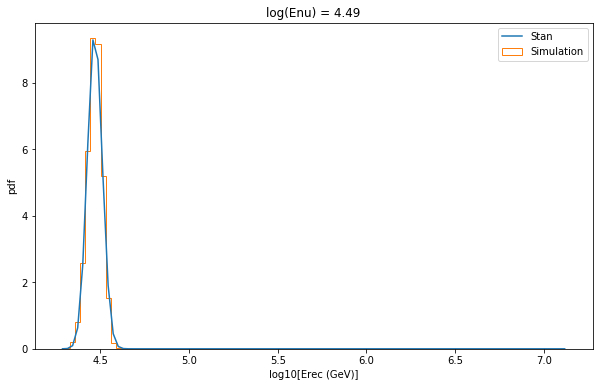

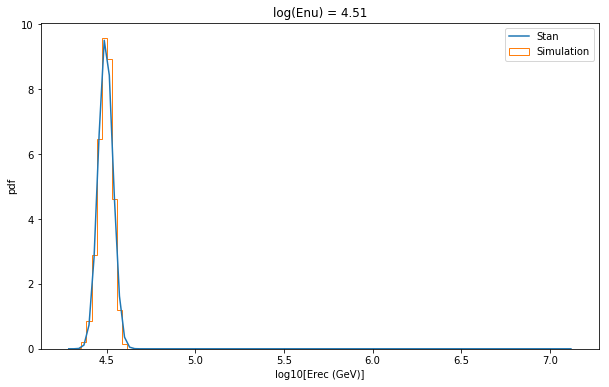

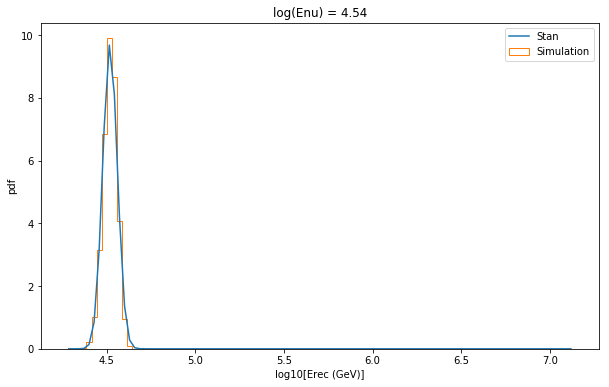

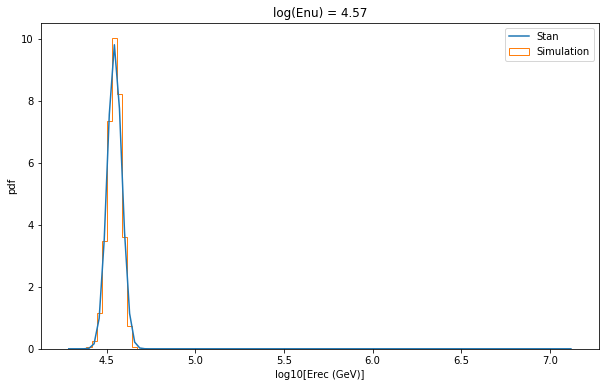

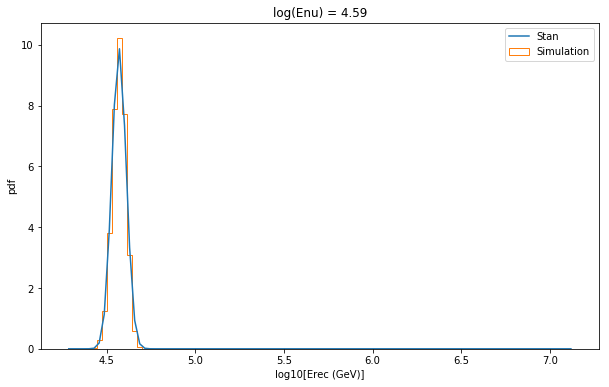

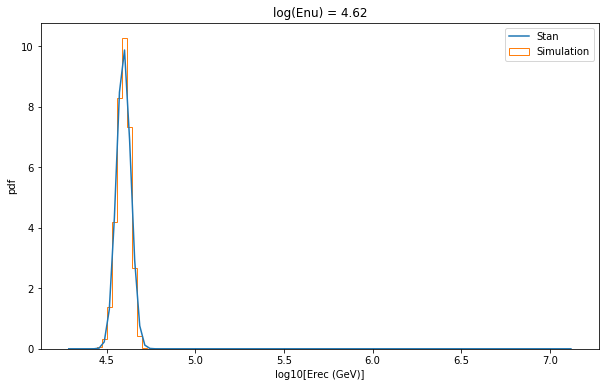

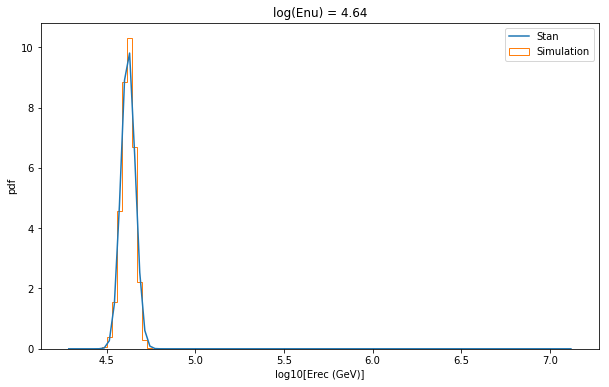

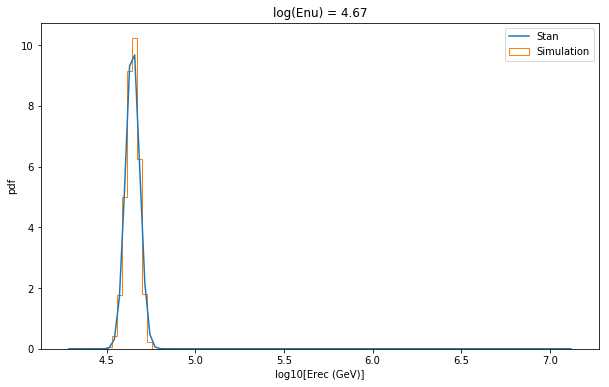

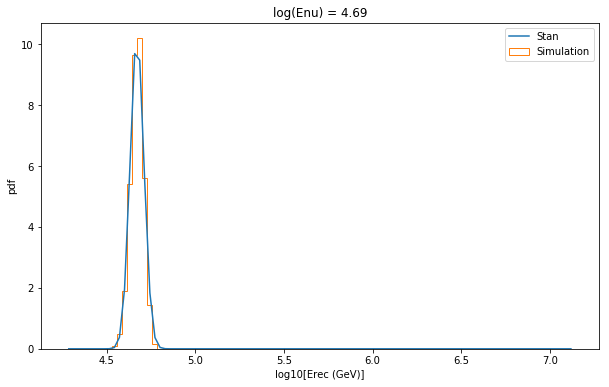

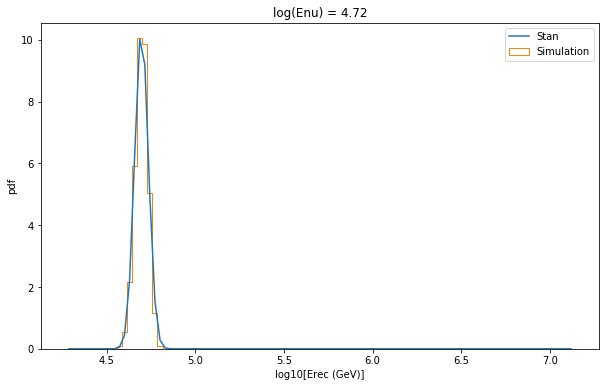

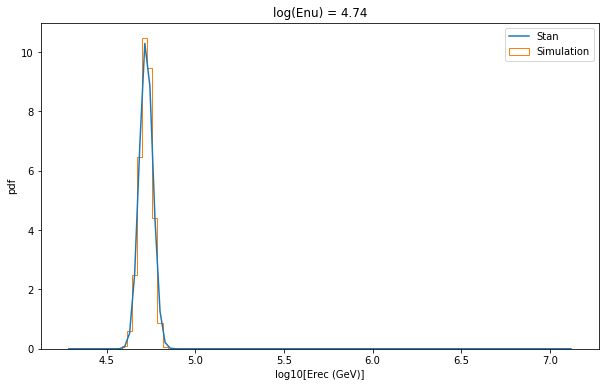

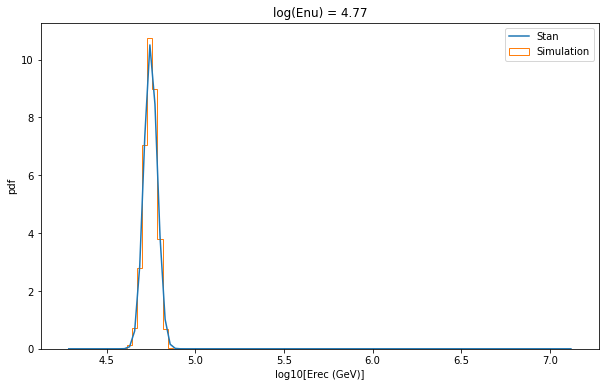

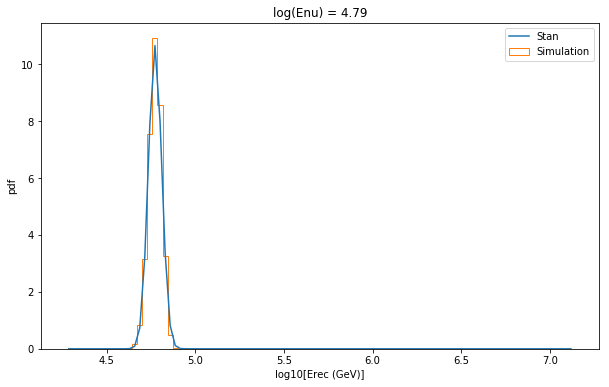

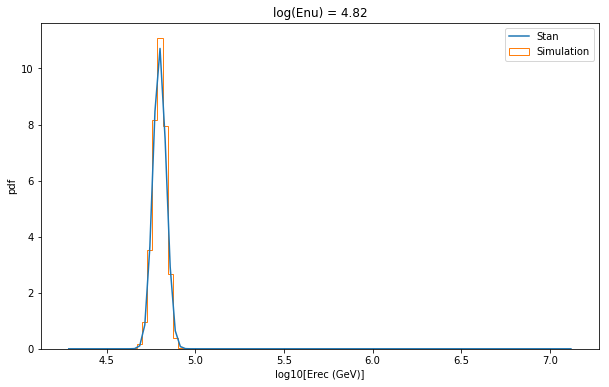

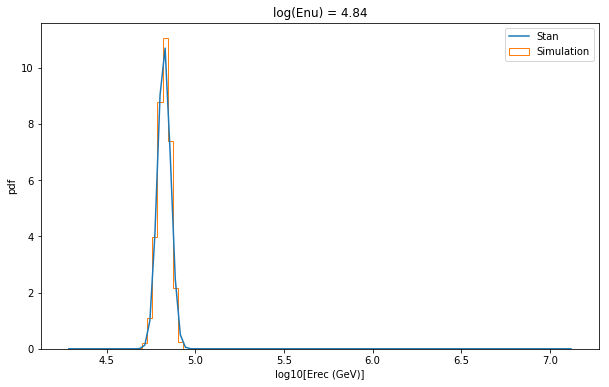

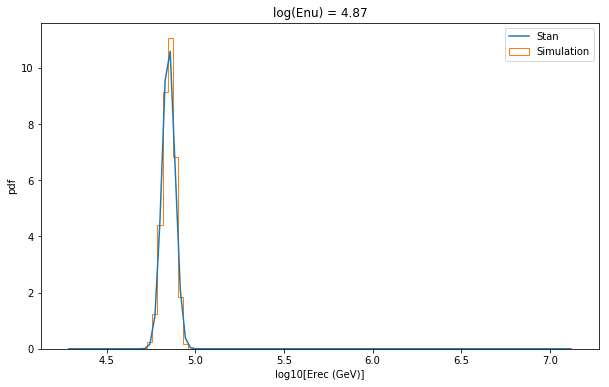

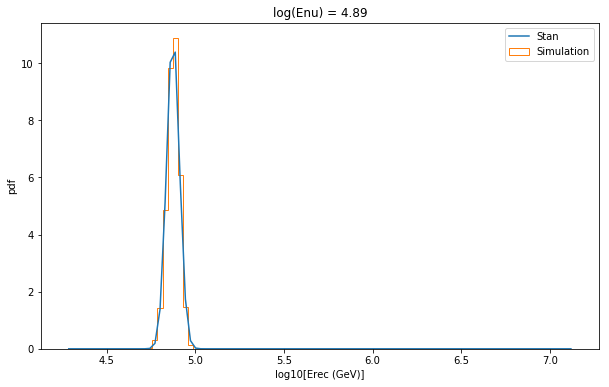

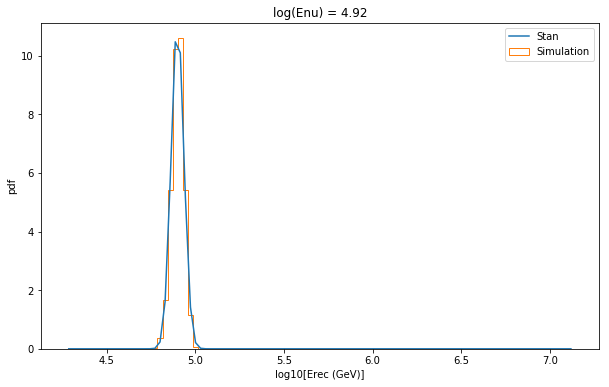

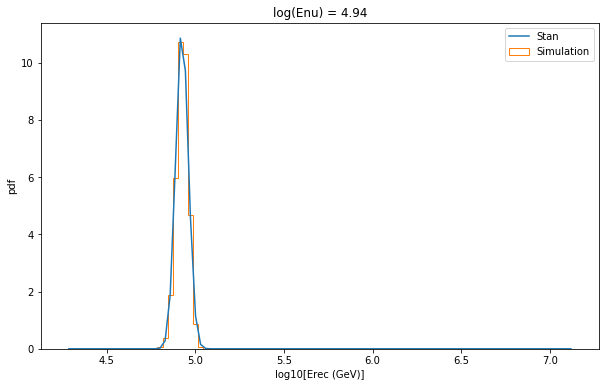

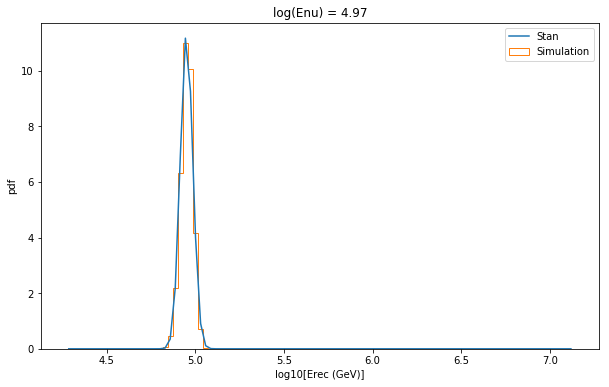

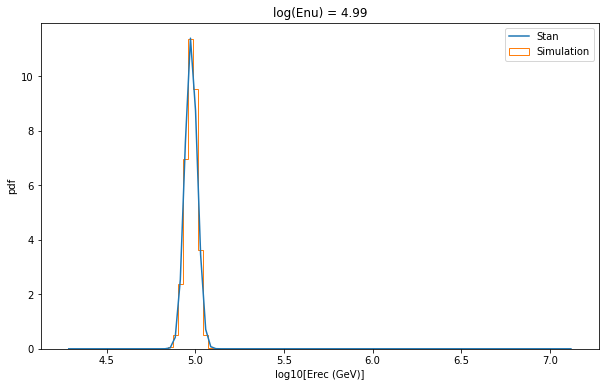

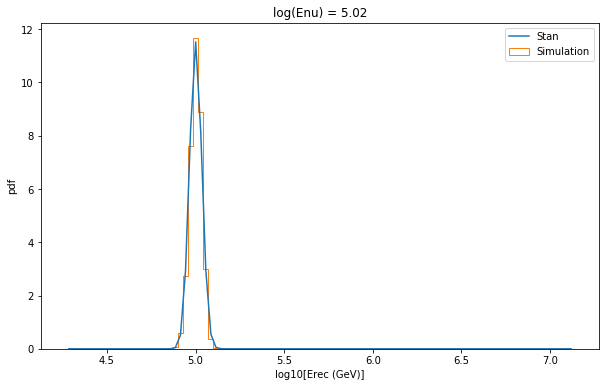

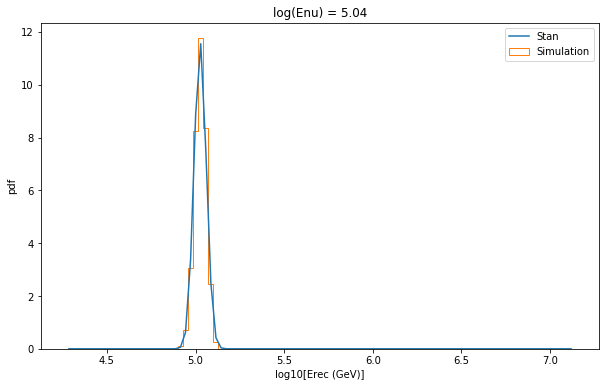

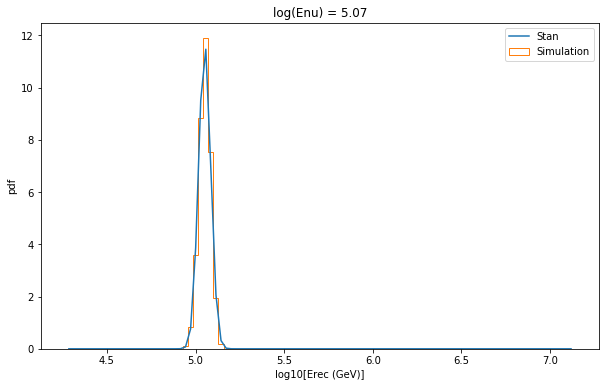

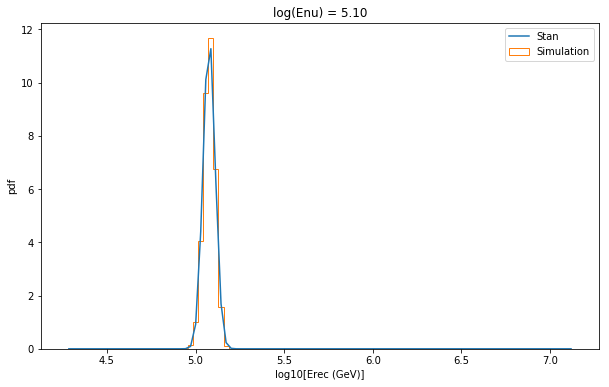

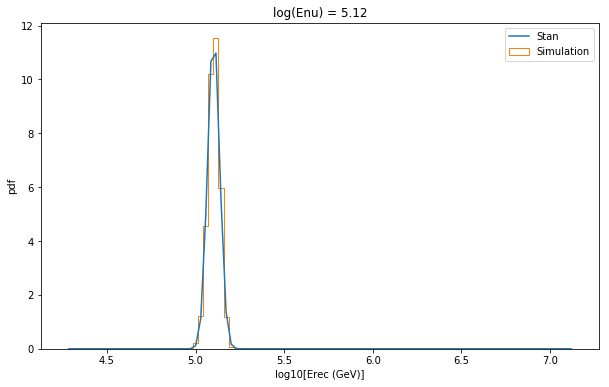

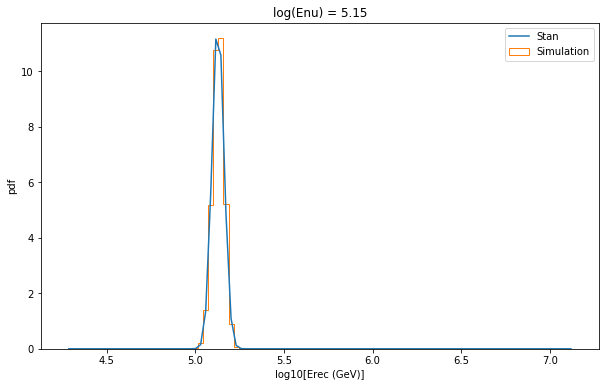

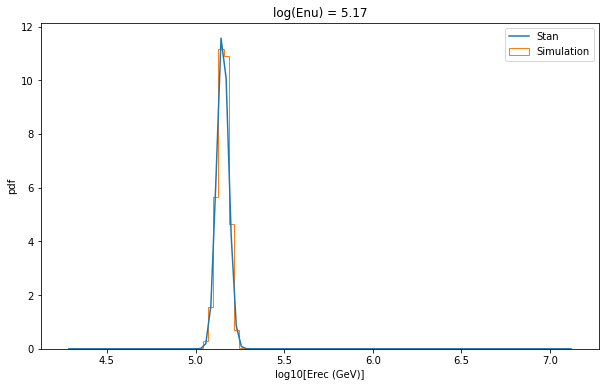

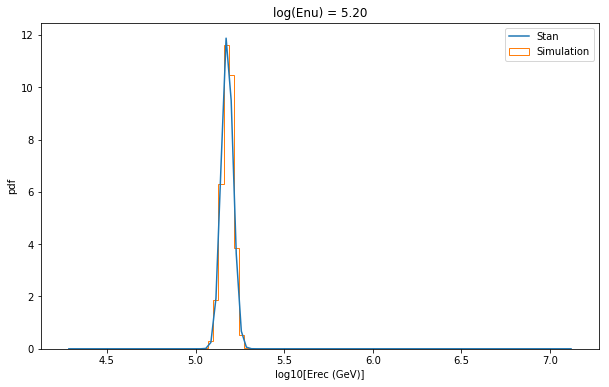

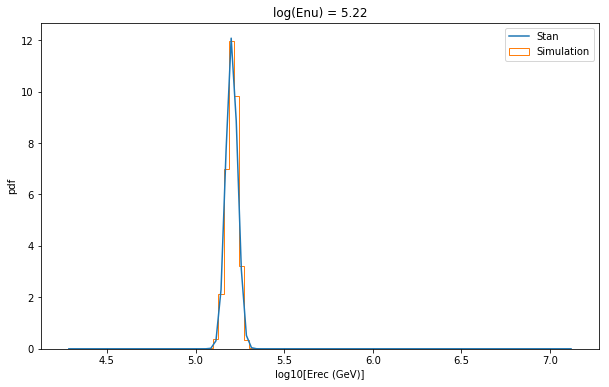

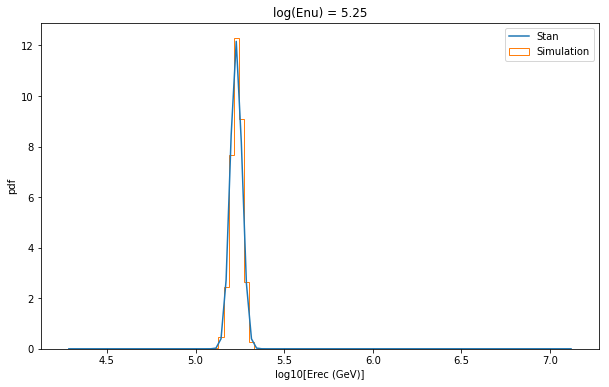

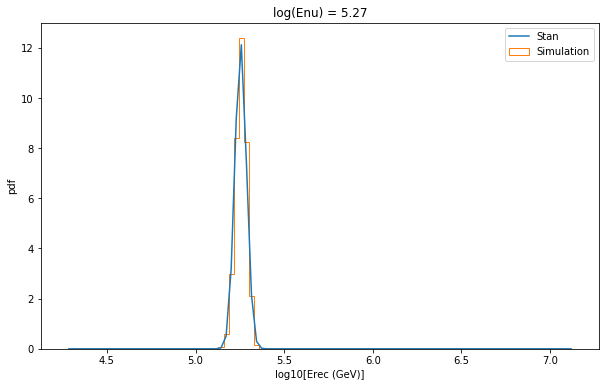

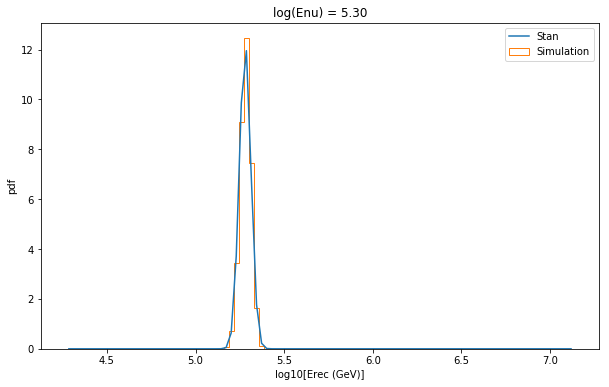

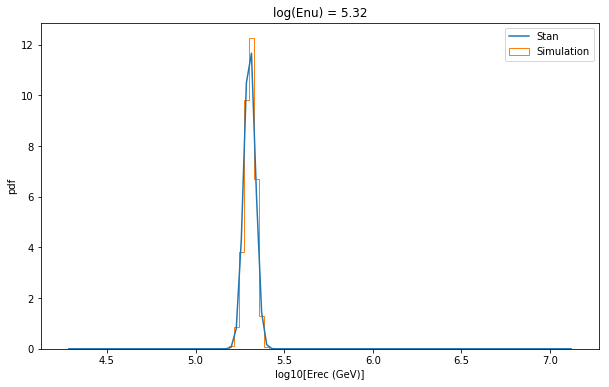

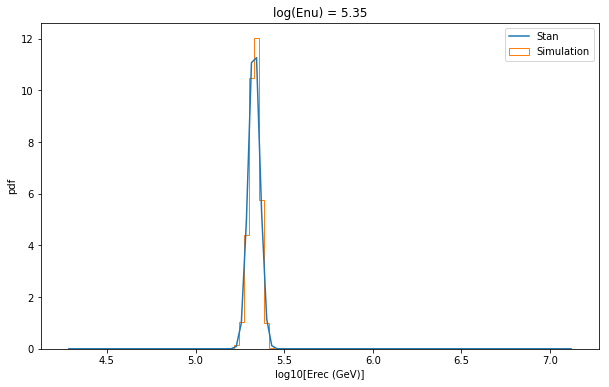

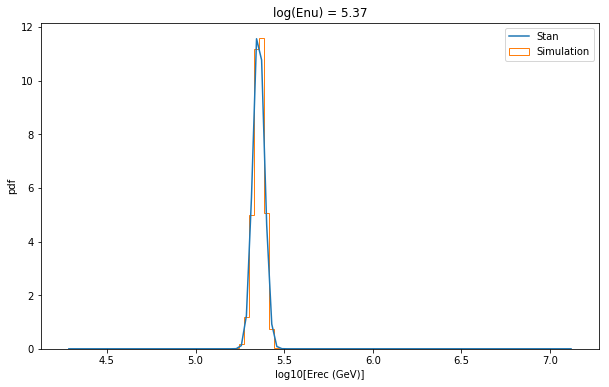

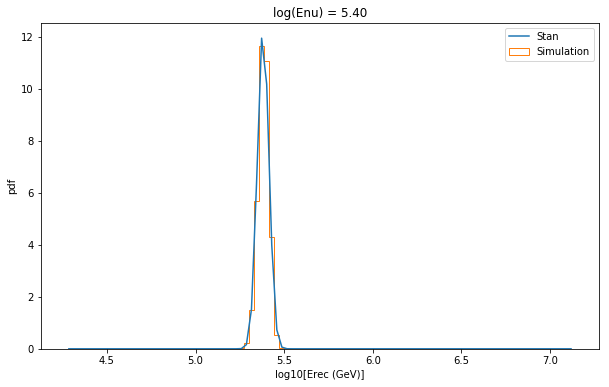

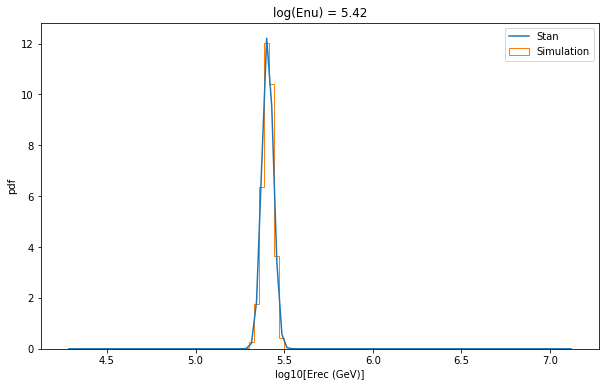

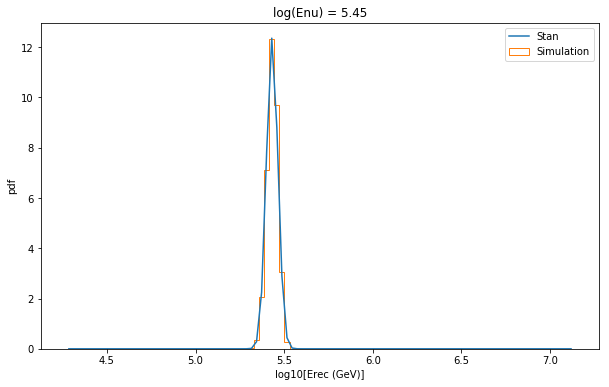

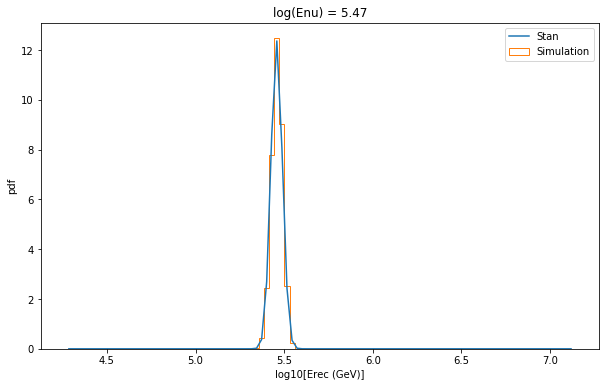

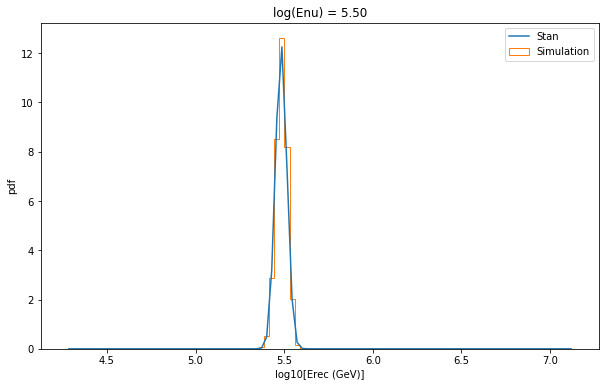

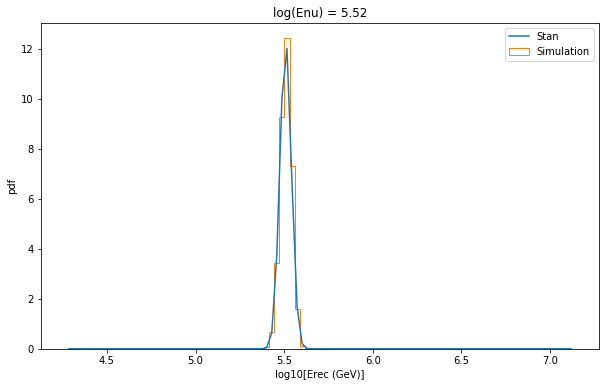

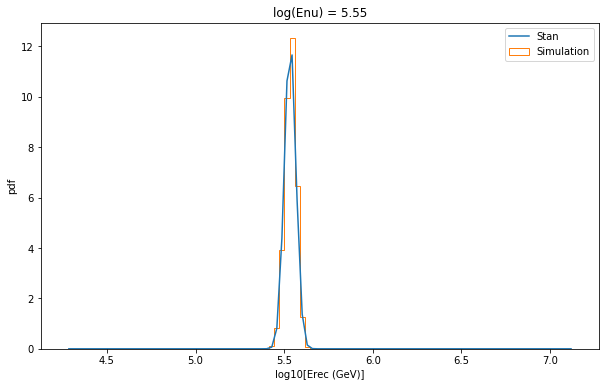

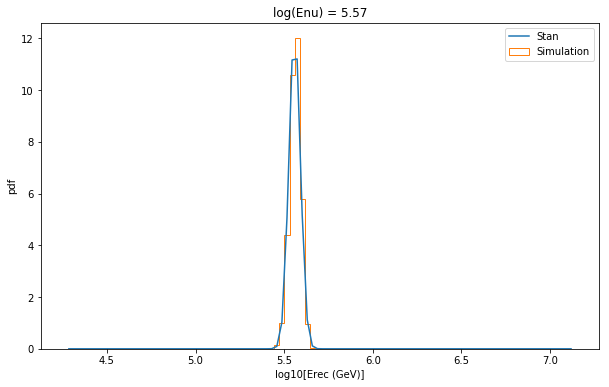

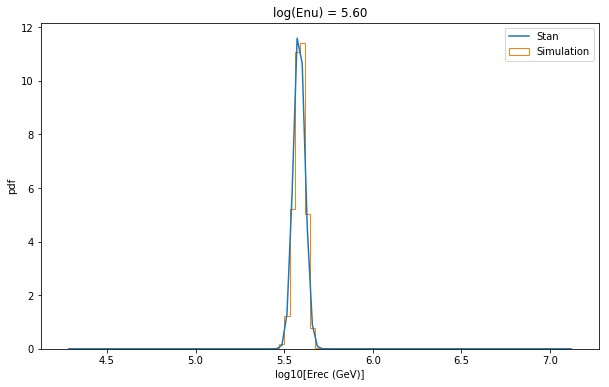

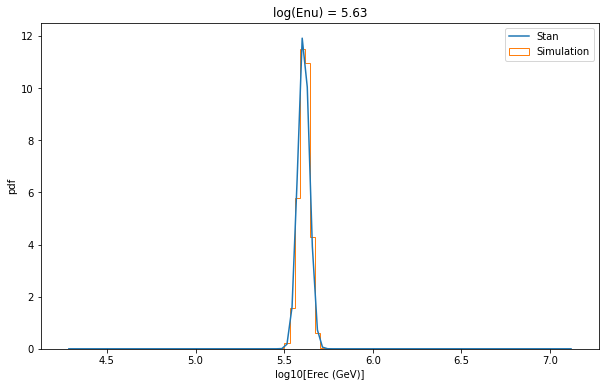

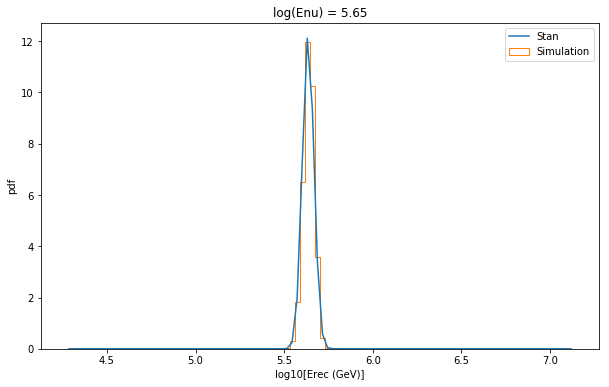

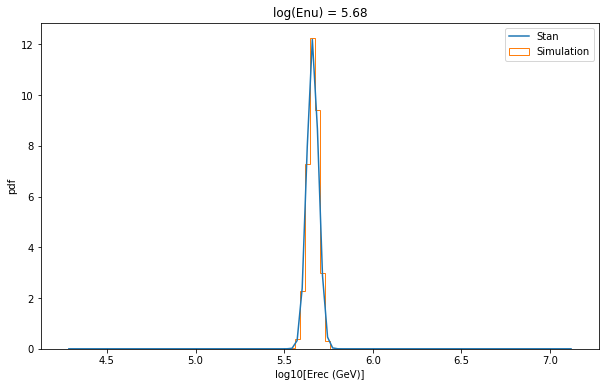

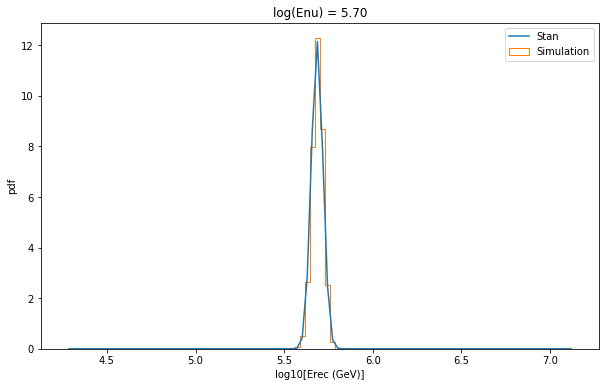

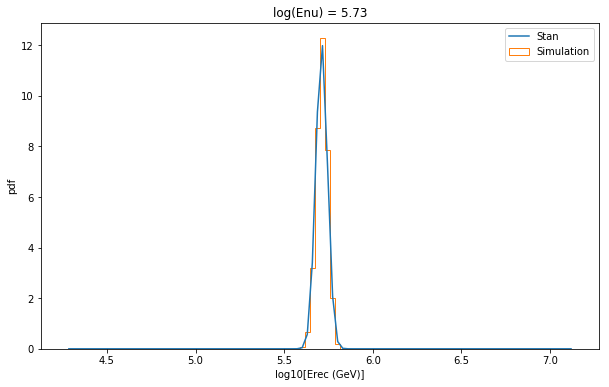

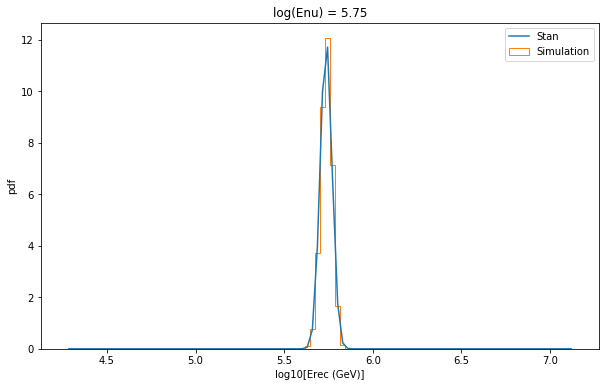

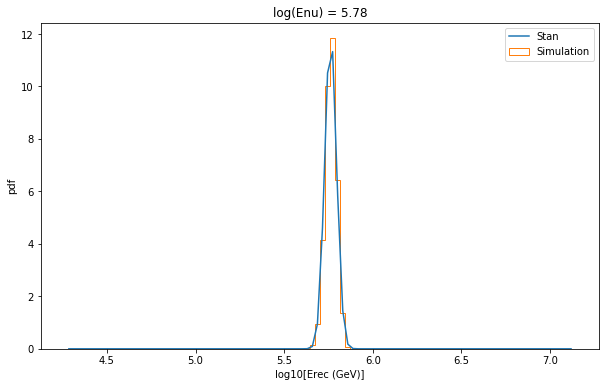

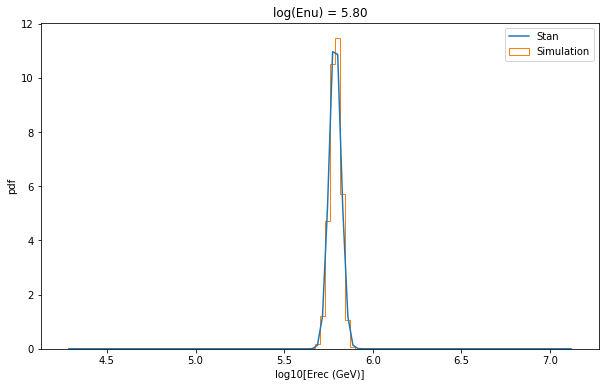

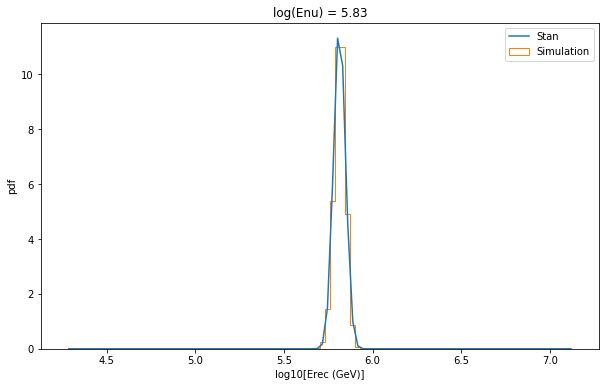

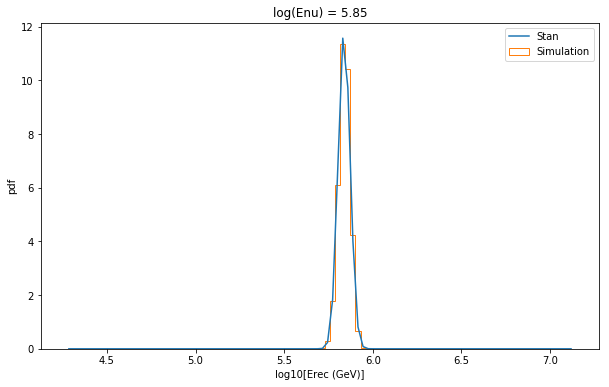

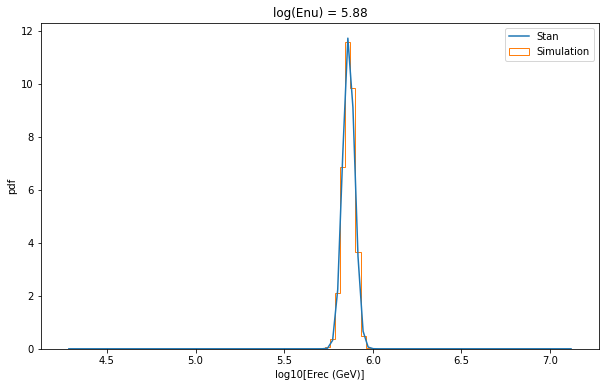

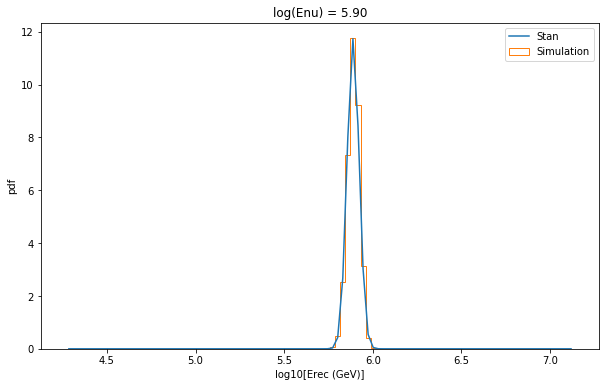

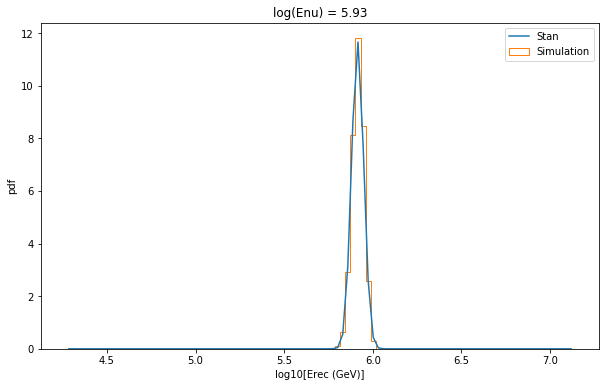

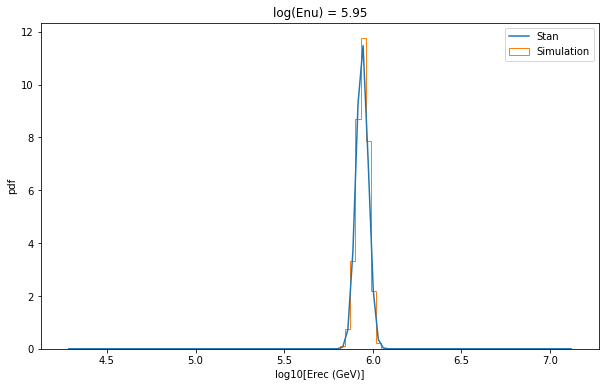

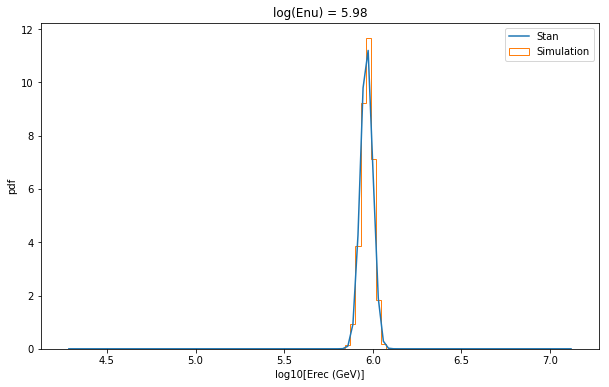

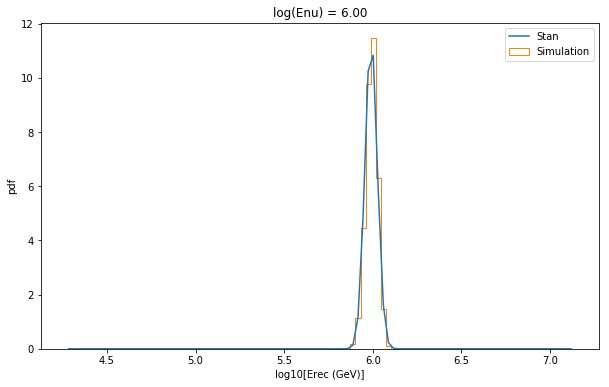

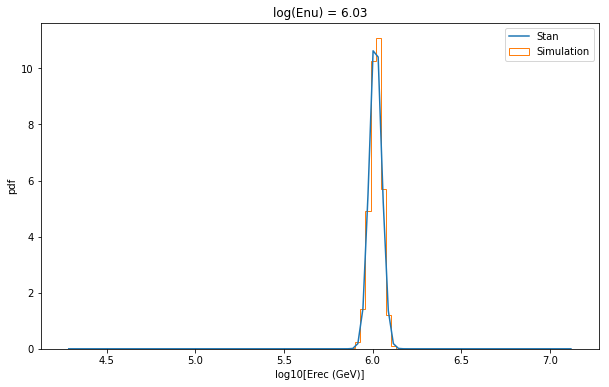

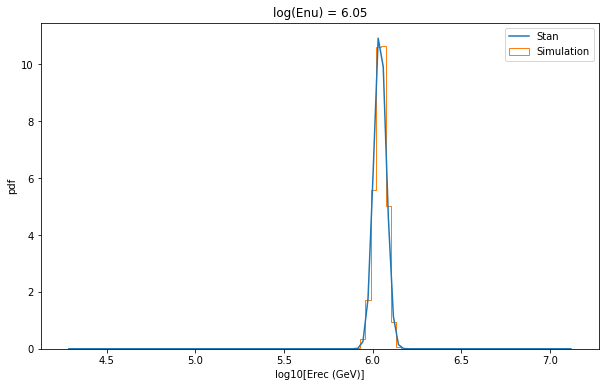

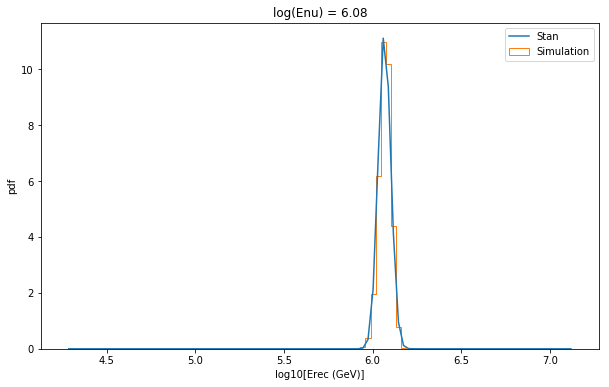

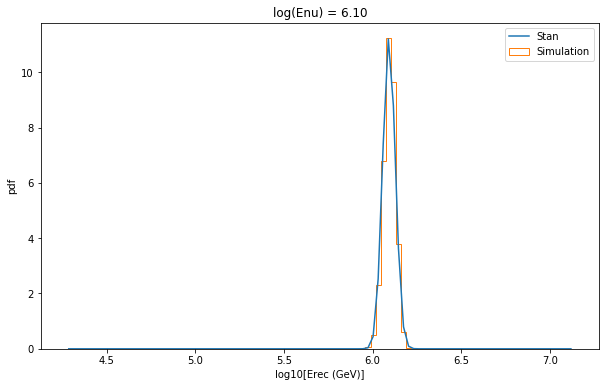

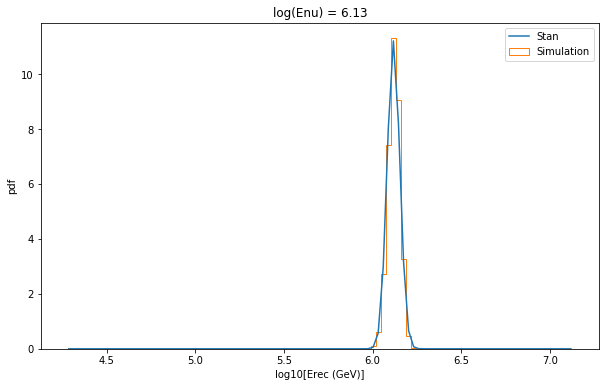

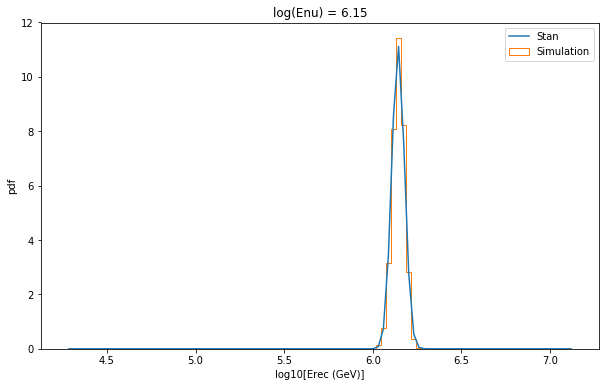

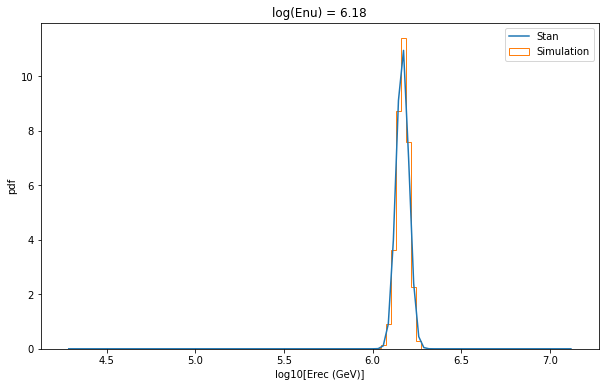

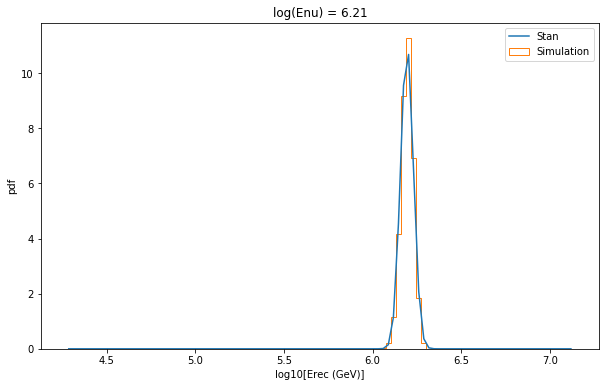

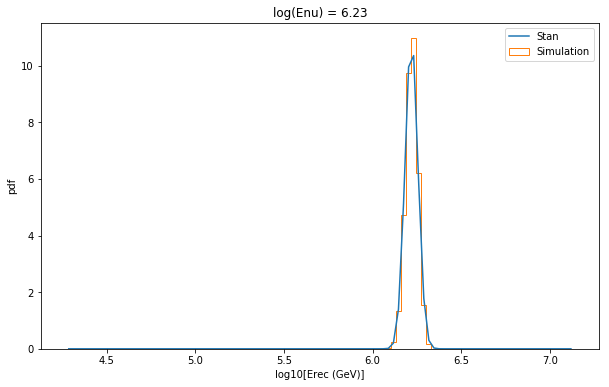

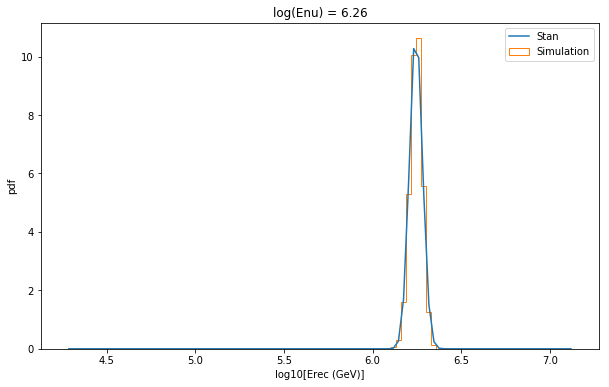

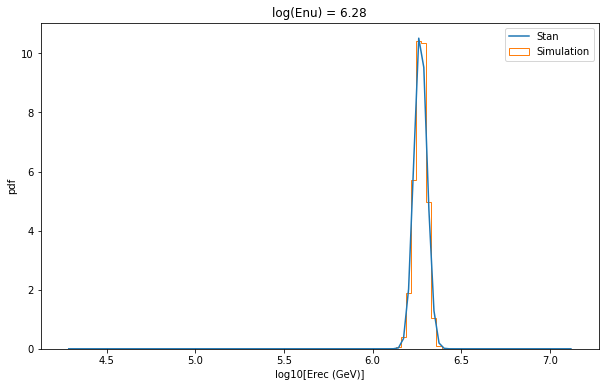

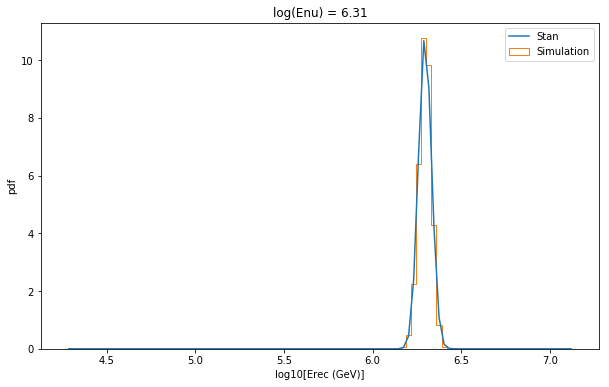

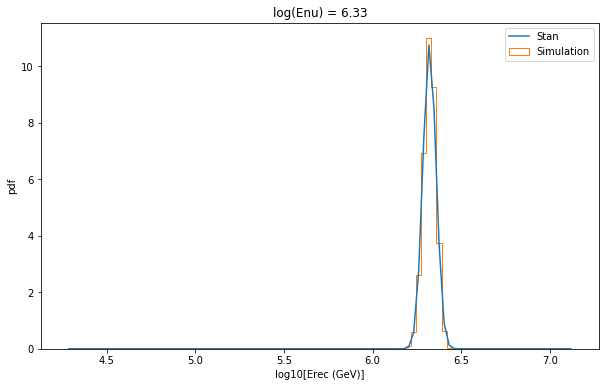

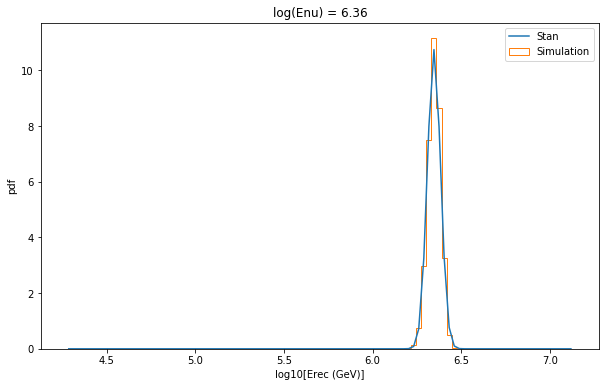

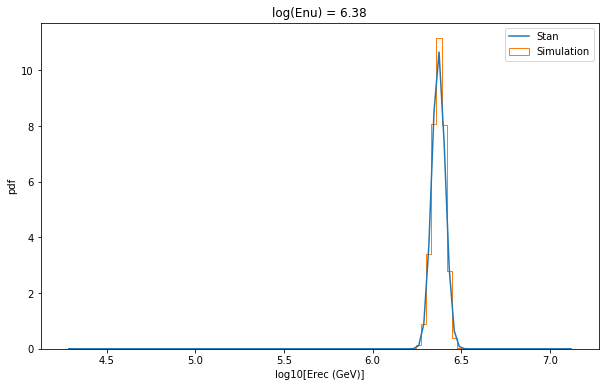

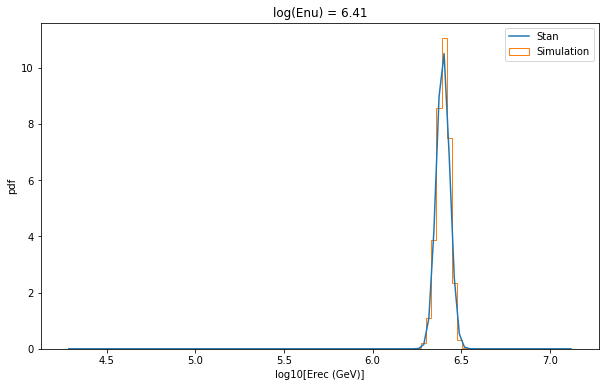

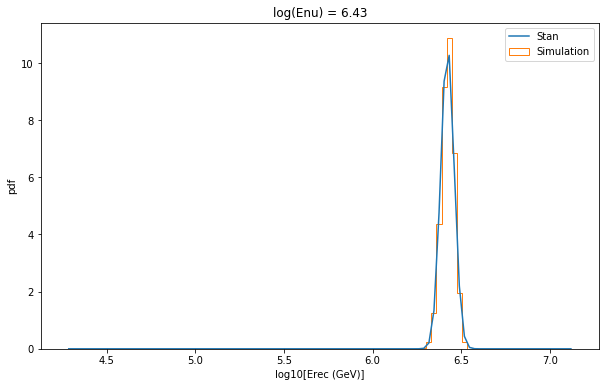

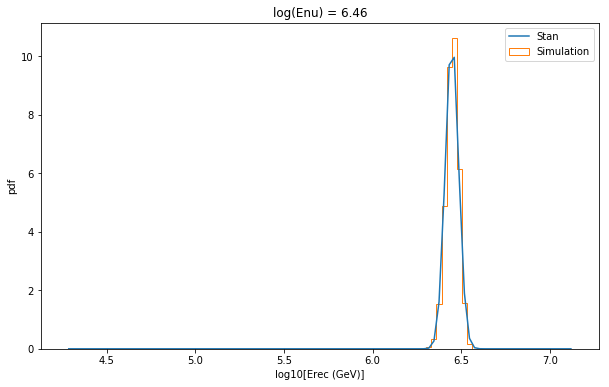

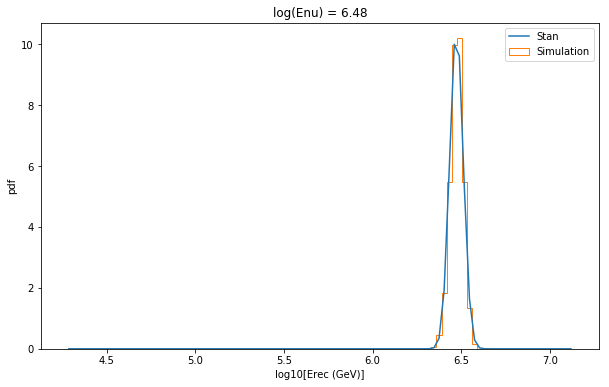

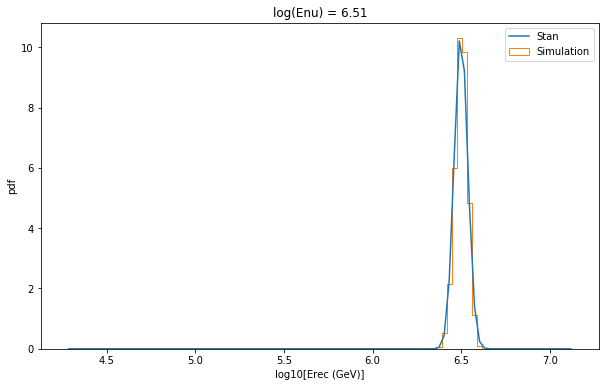

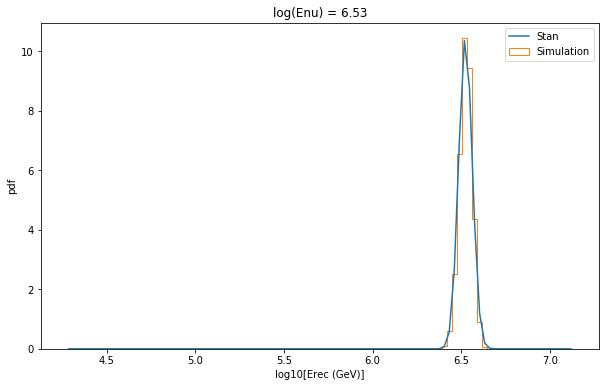

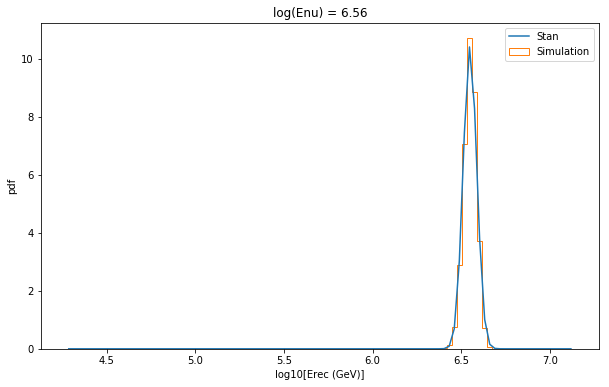

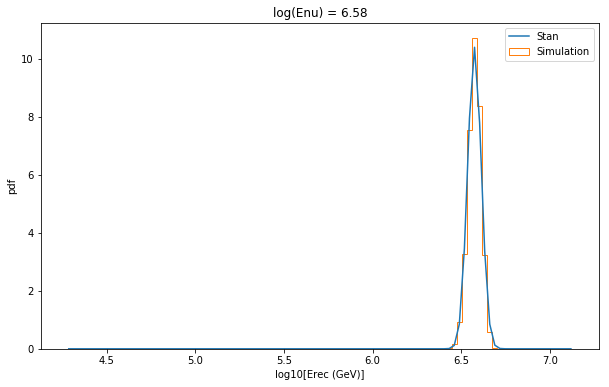

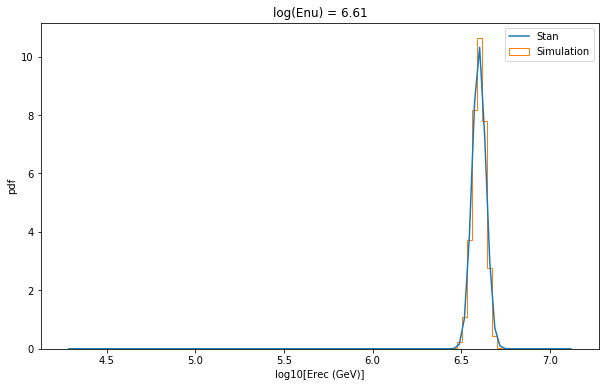

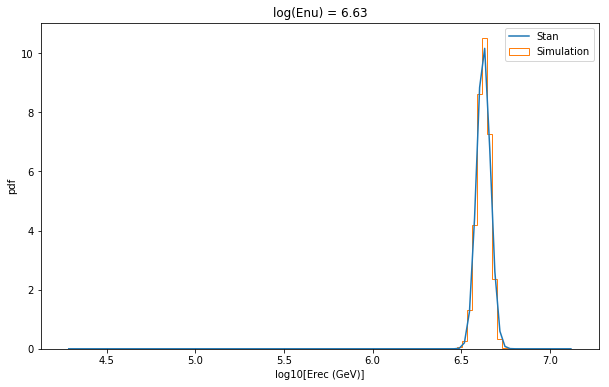

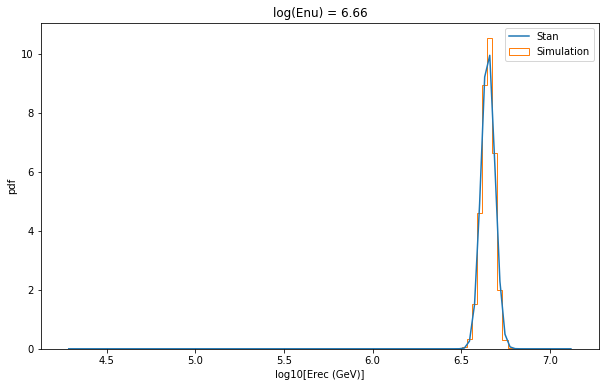

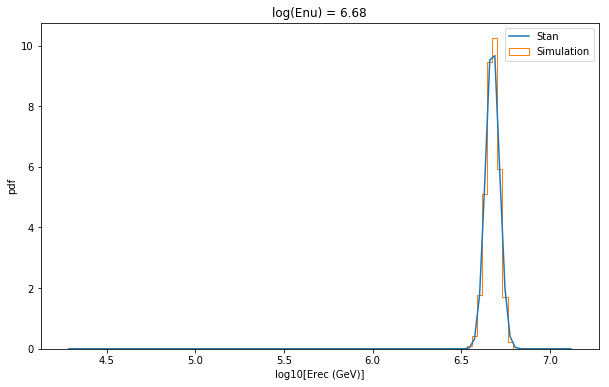

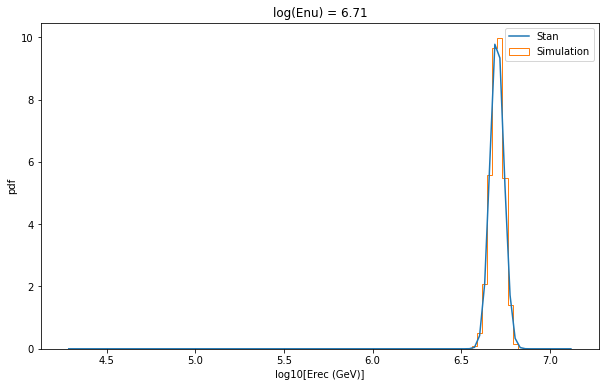

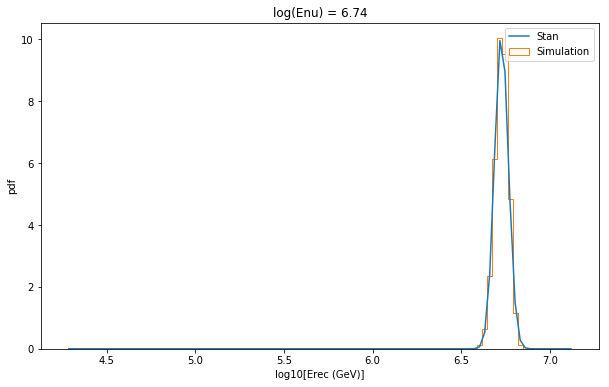

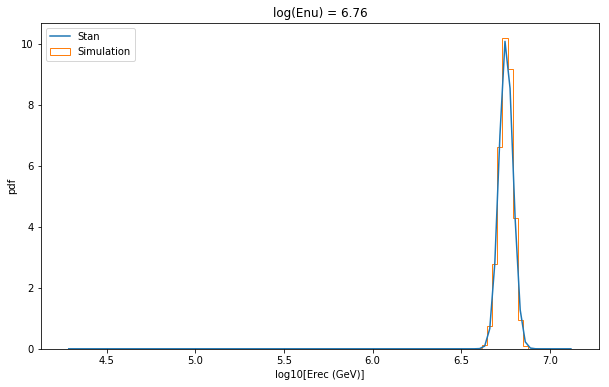

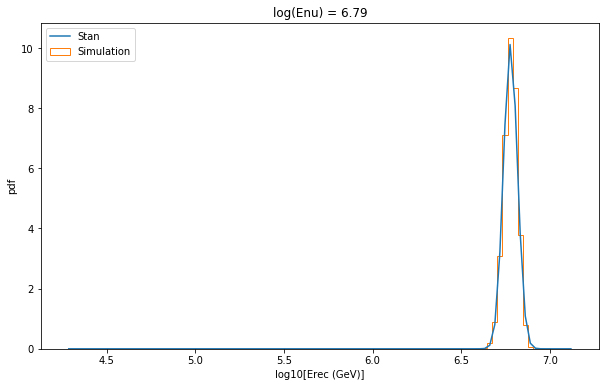

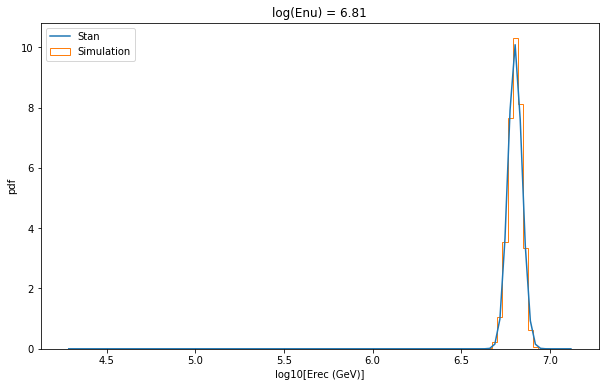

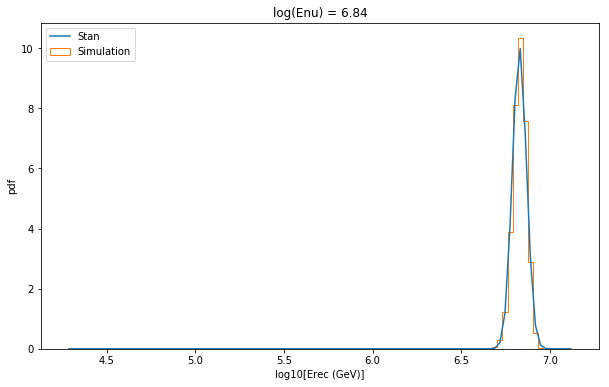

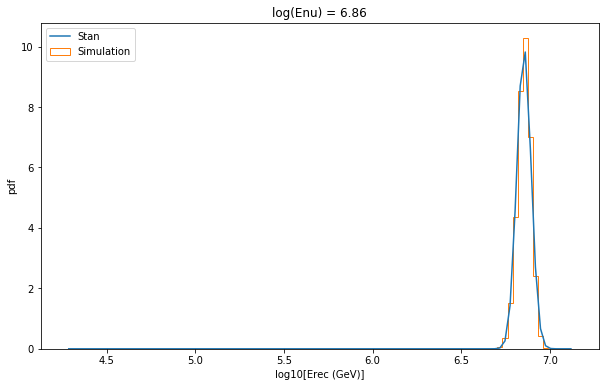

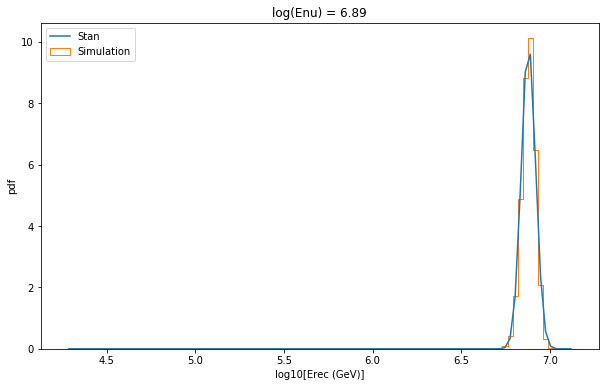

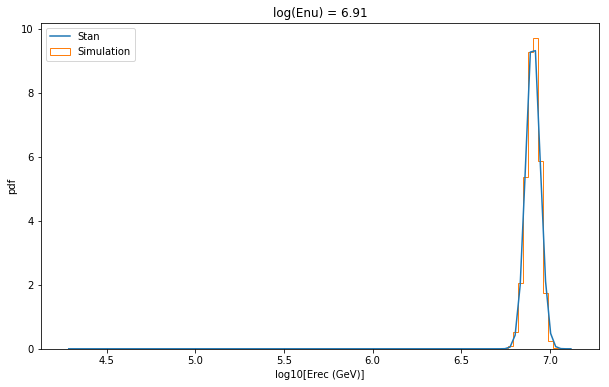

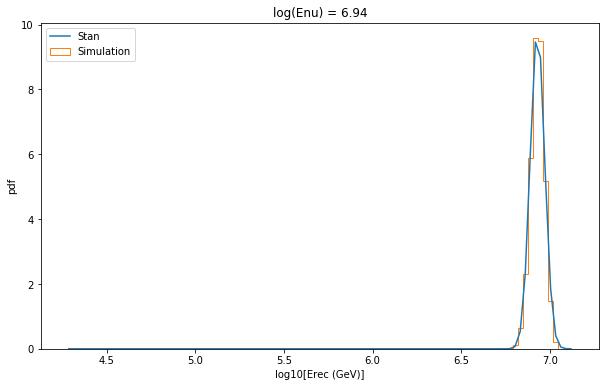

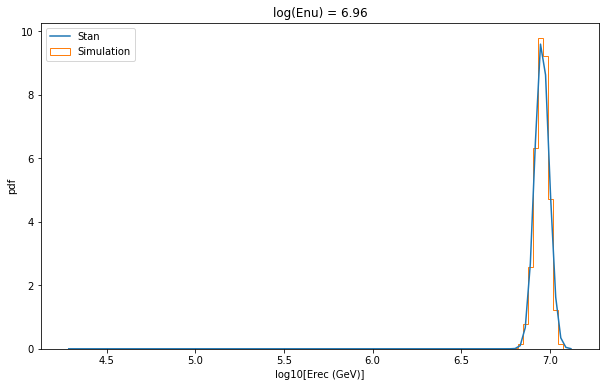

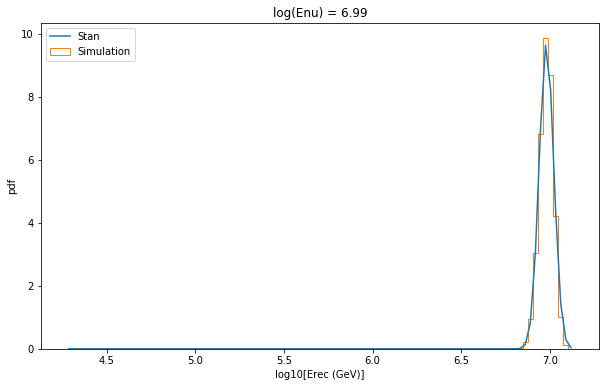

In [34]:
for enu, sl in zip(eprim_bins_CC, binc_CC):
    x = erec_bins_CC
    N = len(erec_bins_CC)
    
    N_pars, N_deg_max = polypars_CC.shape
    
    
    param_pars = {
        'N': N,
        'x': x,
        'N_pars': N_pars,
        'N_degree_max': N_deg_max,
        'par_coeffs': polypars_CC,
        'enu': enu
    }
    
    cascade_output = cascade_CC_stan.sampling(data=param_pars, algorithm='Fixed_param', iter=1, chains=1)
    prob = np.exp(cascade_output.extract('y')['y'][0])
    plt.figure(figsize=(10,6))
    plt.title('log(Enu) = %.2f' %(enu))
    plt.plot(erec_bins_CC, prob, label='Stan')
    sl = sl / sl.sum() / erec_binw_CC
    plt.hist(erec_bins_CC, weights=sl, bins = erec_edges_CC, label='Simulation', histtype='step')
    plt.xlabel('log10[Erec (GeV)]')
    plt.ylabel('pdf')
    plt.legend()
    plt.show()

## HESE cut
The pdf is cut below 60 TeV, here we test the implementation of the NC pdf.

In [35]:
HESE_normalization_code = """
functions {
    real alpha_cdf(real x, real loc, real a) {
        if (x <= loc) {
            return 0;
        }
        else {
            real y = x-loc;
            real integral = erf((a - 1./y) / sqrt(2.)) / (2 * normal_cdf(a, 0., 1.)); 
            real C = -1 / (2 * normal_cdf(a, 0., 1.));
            return integral - C;
        }
    }
    
    real erec_normalization(real upper, vector pars, real enu) {
        // calculate cdf for alpha and truncated lognorm up to HESE cut
        real alpha = 1 - alpha_cdf(-upper, -pars[1], pars[2]);
        real lognorm; 
        real normalization;
        if (upper > enu) {
            lognorm = 1.;
        }
        else {
            lognorm = lognormal_cdf(upper/pars[3], 0., pars[4]) / lognormal_cdf(enu/pars[3], 0., pars[4]);
        }
        
        normalization = pars[5] * (1-alpha) + (1-pars[5]) * (1-lognorm);
        return normalization;
    }
    
    real eval_poly1d(real x, row_vector coeffs){
      int N = num_elements(coeffs);
      real res=0;
      for(i in 1:N){
        res += coeffs[i]*pow(x, N-i);
      }
      return res;
    }
    
    vector get_pars(real x, matrix par_coeffs, int N_pars) {
    
        vector[N_pars] pars;
        for (i in 1:N_pars) {
            pars[i] = eval_poly1d(x, par_coeffs[i]);
        }
        return pars;
    }
}
    
data {
    real enu;
    int N_pars;
    int N_deg_max;
    real upper;
    matrix[N_pars, N_deg_max] par_coeffs;
}

generated quantities {
    vector[N_pars] pars = get_pars(enu, par_coeffs, N_pars);
    real norm = erec_normalization(upper, pars, enu);
}

"""

In [36]:
HESE_normalization_stan = pystan.StanModel(model_code=HESE_normalization_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1fa1ea3903396123a310b95de0a1a28 NOW.


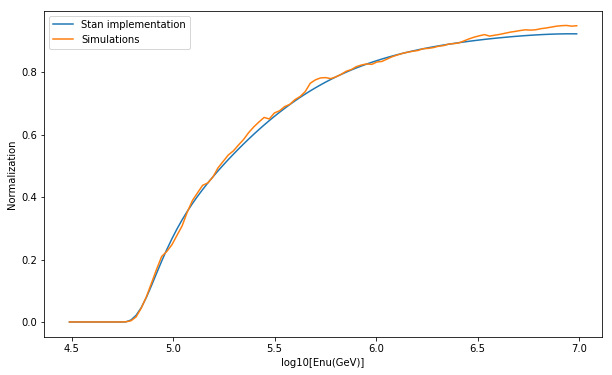

In [37]:
stan_norms = []
sim_norms = []
alpha = []
lognorm = []
for enu, sl in zip(eprim_bins_NC, binc_NC):
    
    N_pars, N_deg_max = poly_coeffs.shape
    
    data = {
        'enu': enu,
        'N_pars': N_pars,
        'N_deg_max': N_deg_max,
        'par_coeffs': poly_coeffs,
        'upper': np.log10(6e4)
        
    }
    output_normalization = HESE_normalization_stan.sampling(data=data, algorithm='Fixed_param', iter=1, chains=1)
    stan_norms.append(output_normalization.extract('norm')['norm'][0])
    
    sl = sl / sl.sum() / erec_binw_NC
    idx = np.where(erec_bins_NC > np.log10(6e4))
    sim_norms.append(np.sum(sl[idx])*erec_binw_NC)
    
plt.figure(figsize=(10,6))
plt.plot(eprim_bins_NC, stan_norms, label='Stan implementation')
plt.plot(eprim_bins_NC, sim_norms, label='Simulations')
plt.legend()
plt.xlabel('log10[Enu(GeV)]')
plt.ylabel('Normalization')
plt.show()

Don't mind the jumps in 'Simulations' curve as it's just the sums of the histogram bin contents in each $E_\nu$ slice. The 'Stan' curve is the analytic normalization from the implementation of the pdf. The latter is not a fit of the former or whatever, they're just plotted together to make sure the Stan implementation looks correct.

# Full implementation
With HESE cut etc.

In [38]:
cascade_CC = pystan.StanModel(file='./stan/CC_demo.stan', include_paths='./stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8eb0fc20989b1f289e314826a52a6976 NOW.


/home/mhaminh/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


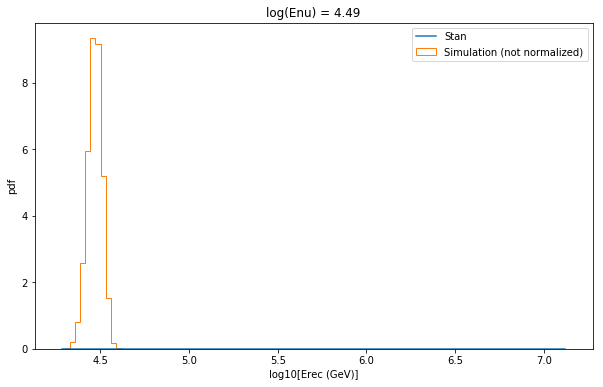

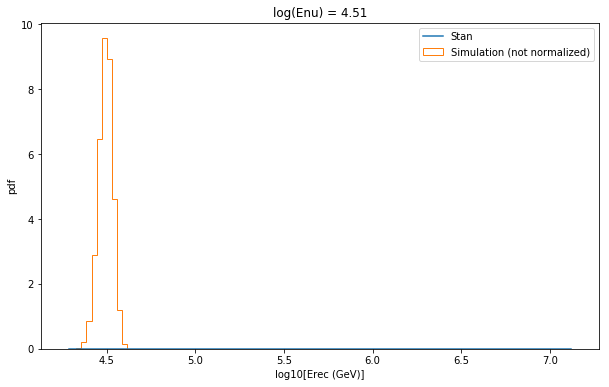

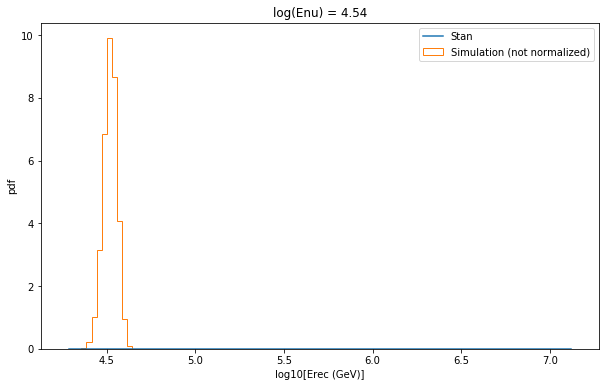

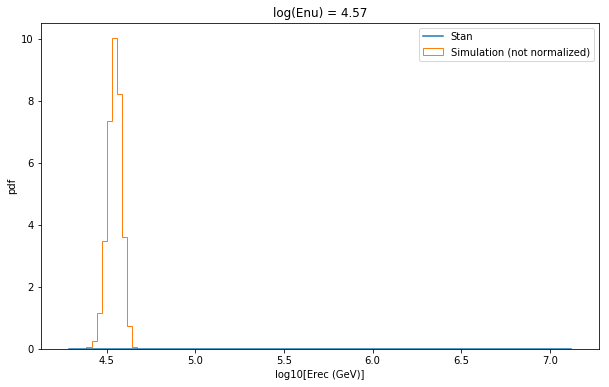

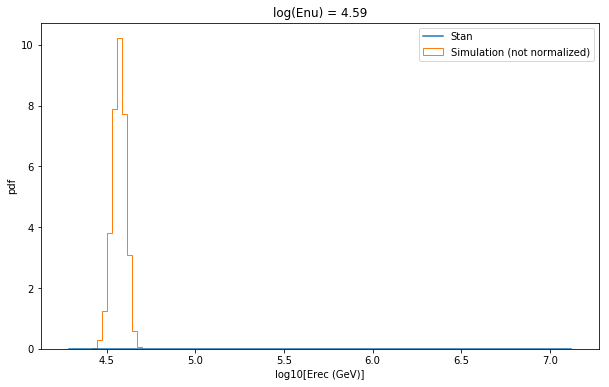

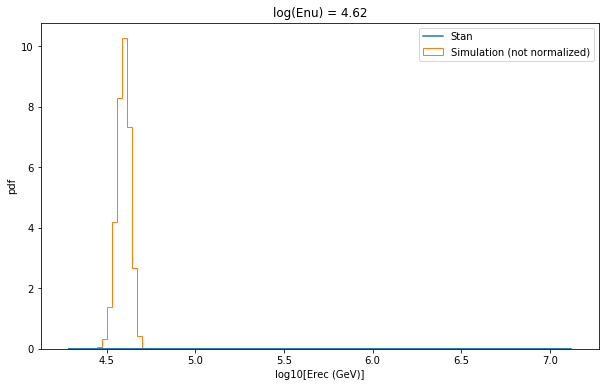

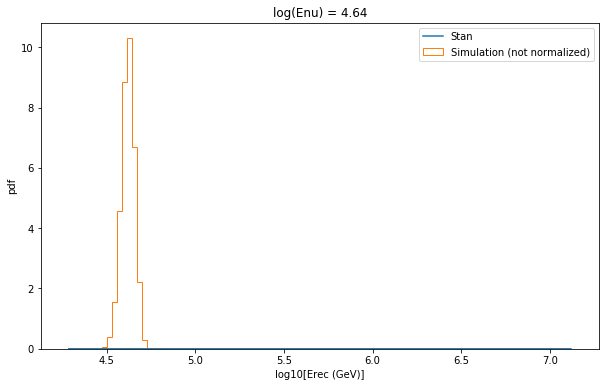

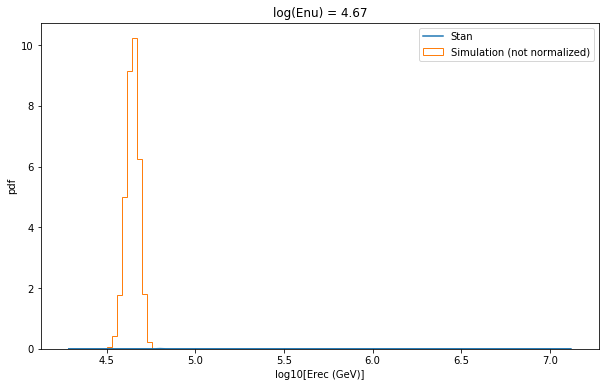

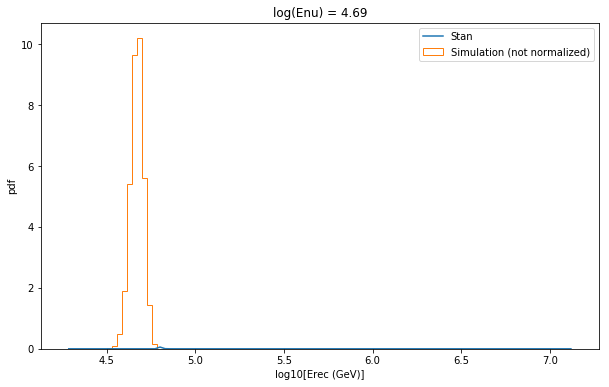

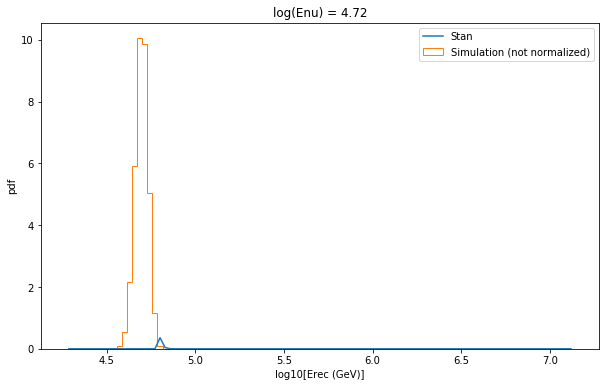

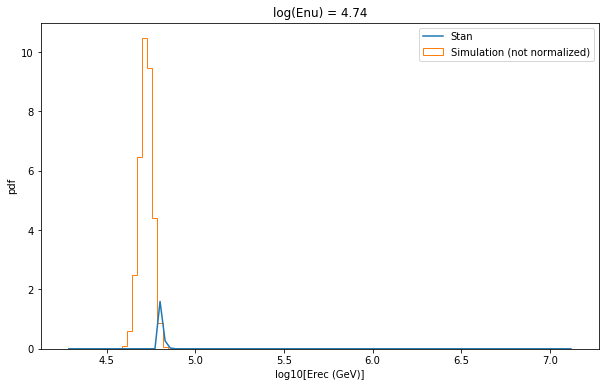

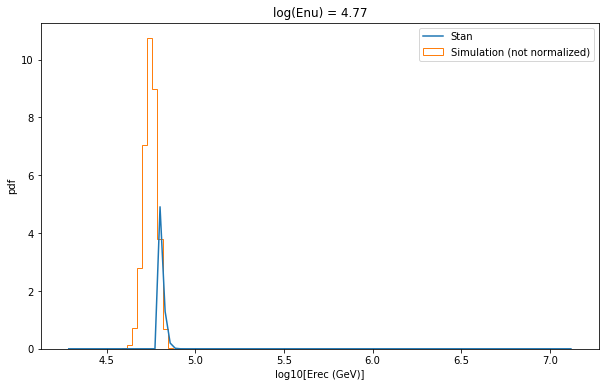

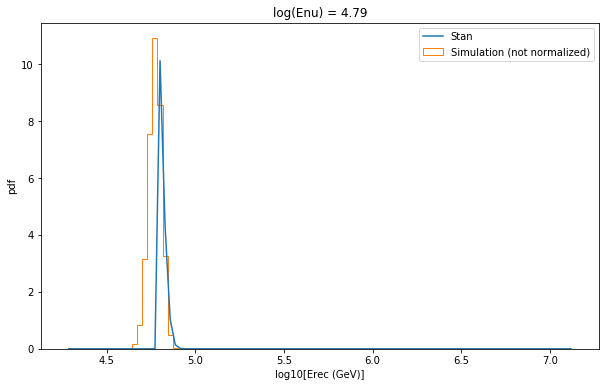

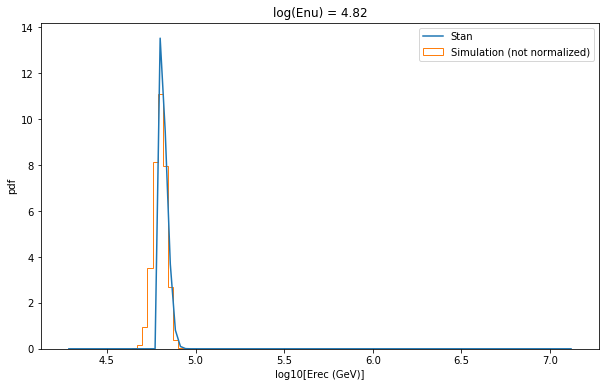

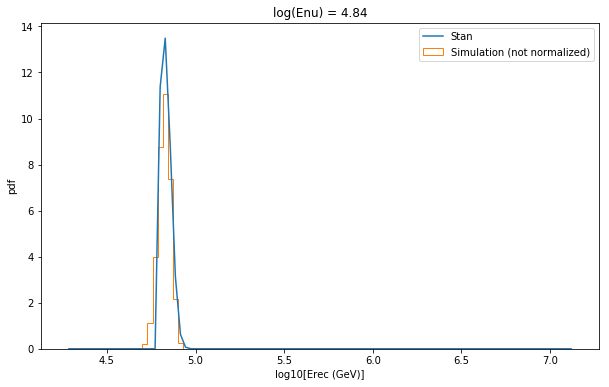

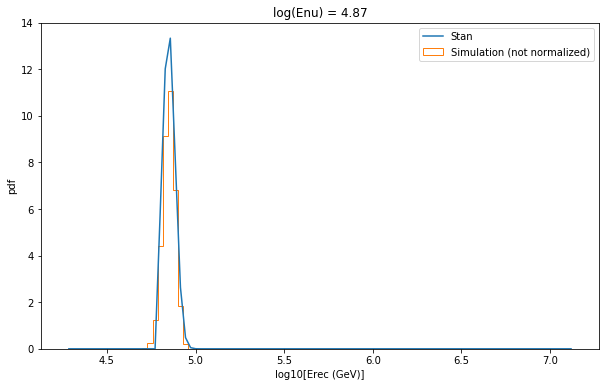

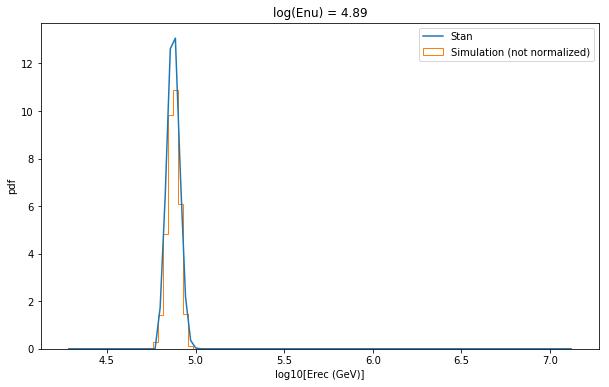

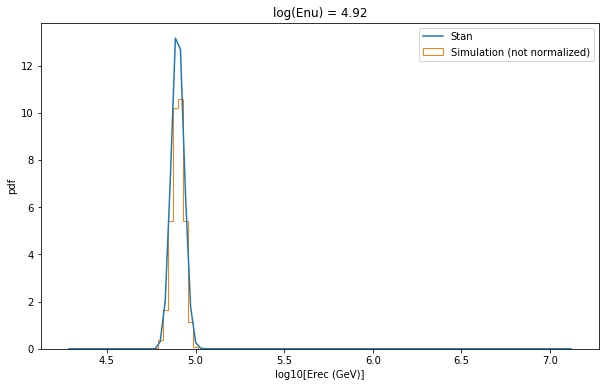

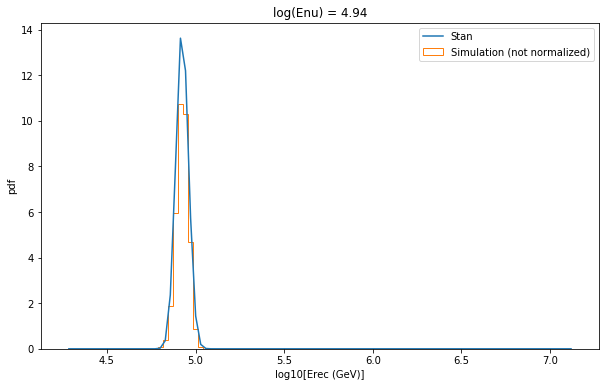

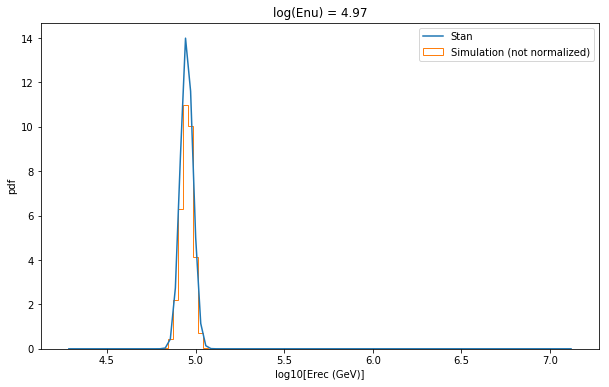

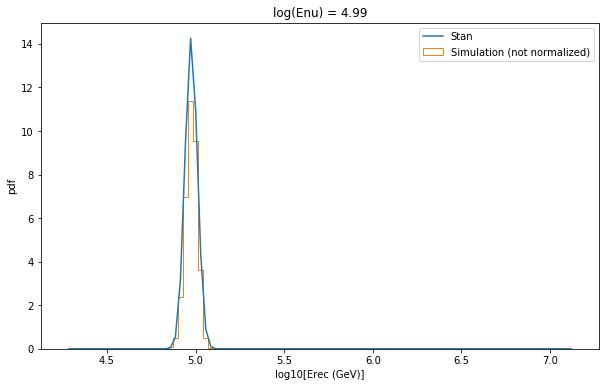

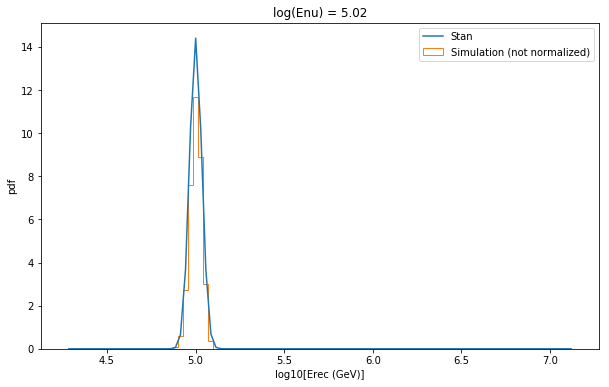

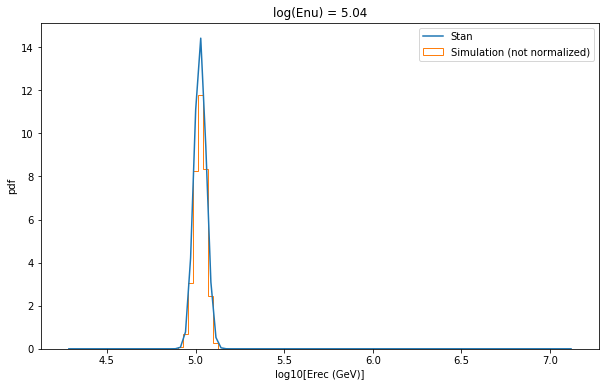

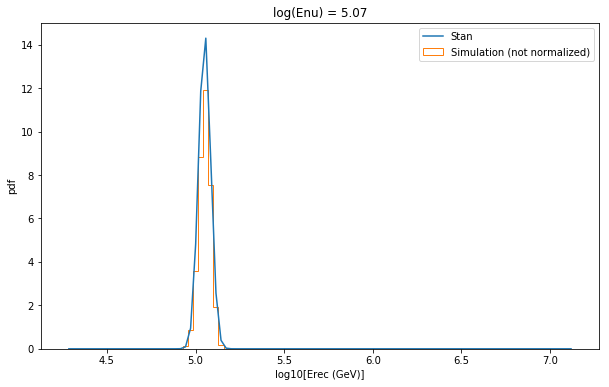

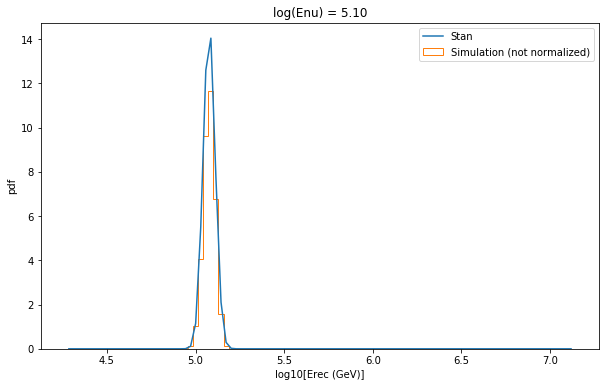

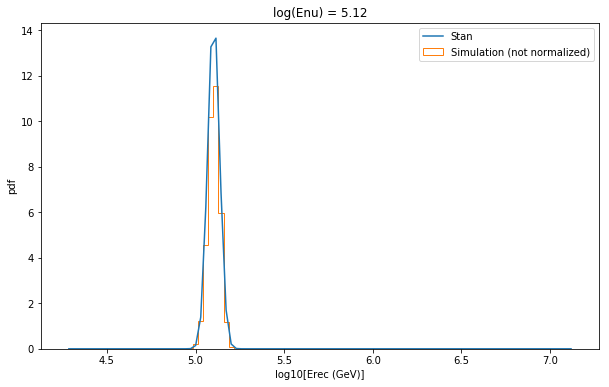

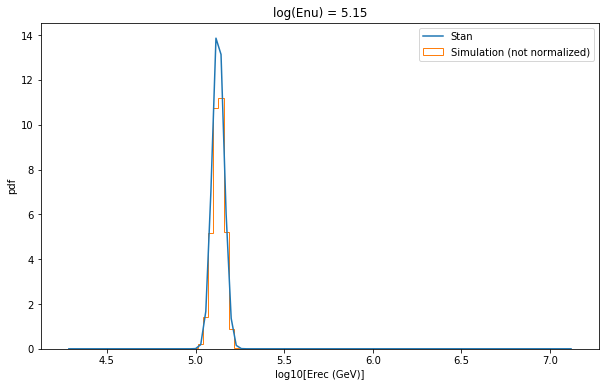

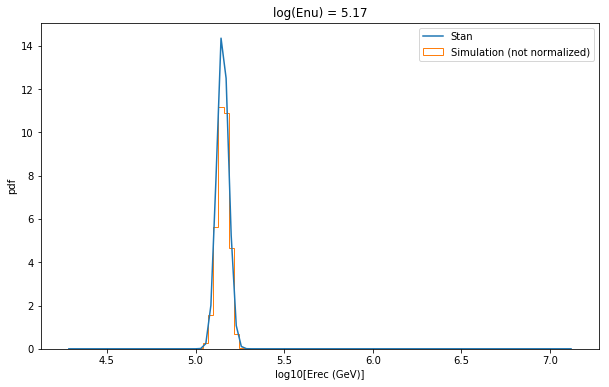

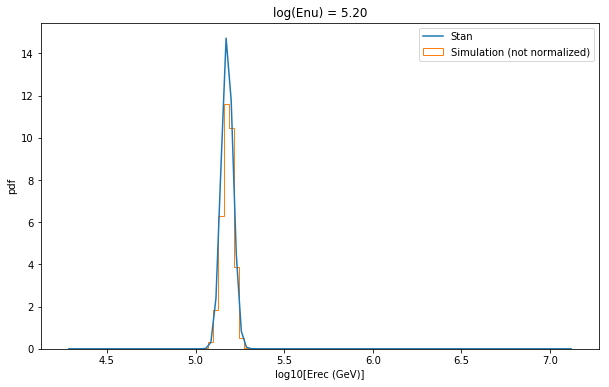

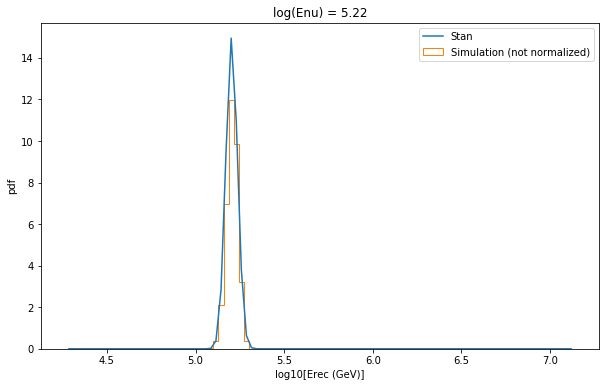

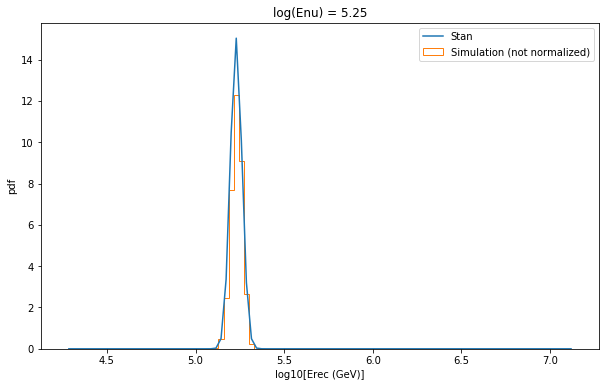

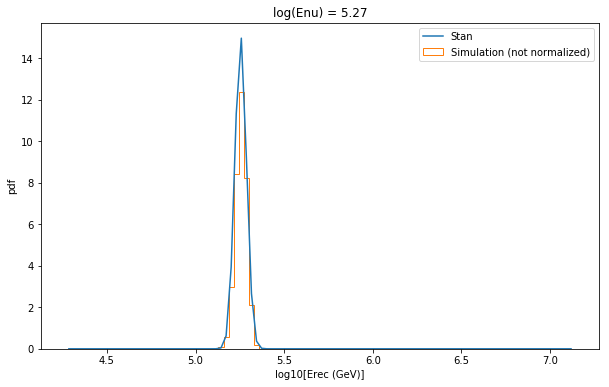

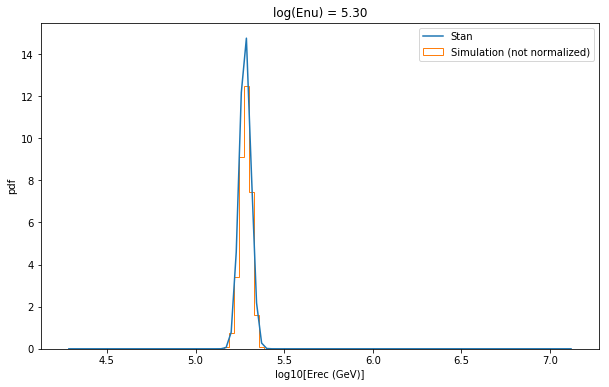

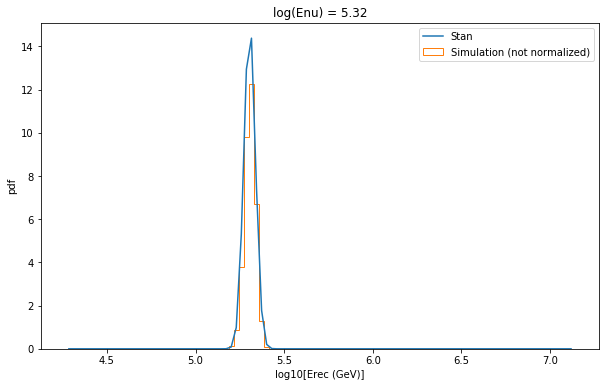

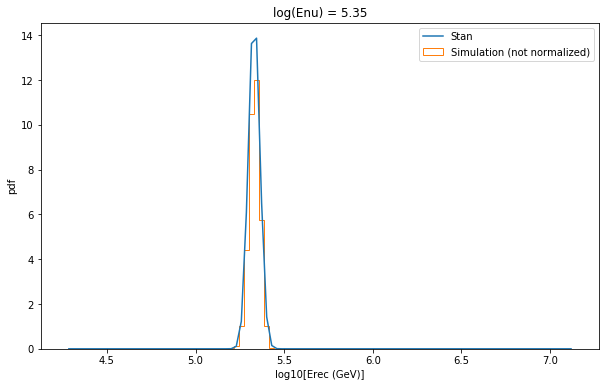

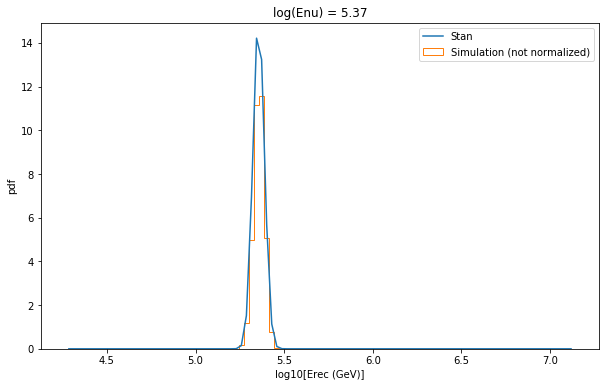

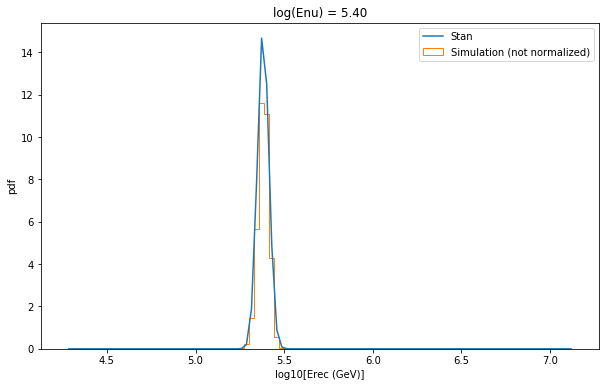

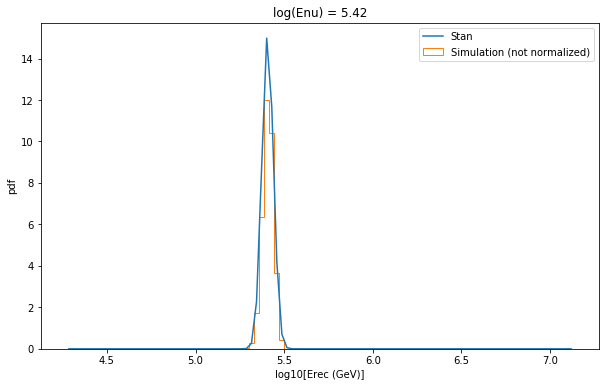

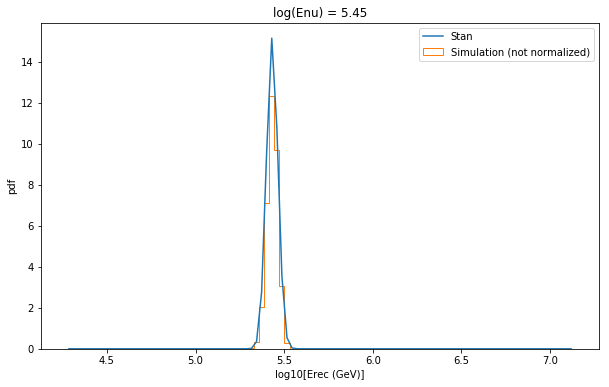

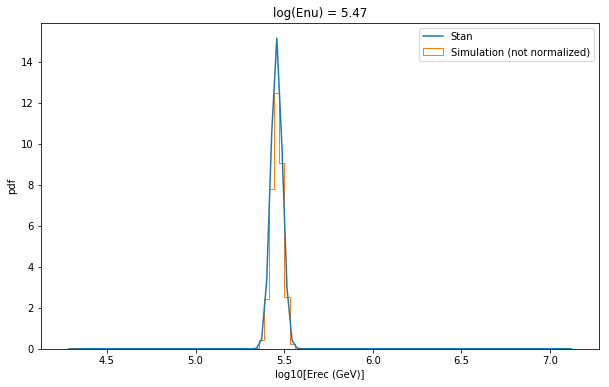

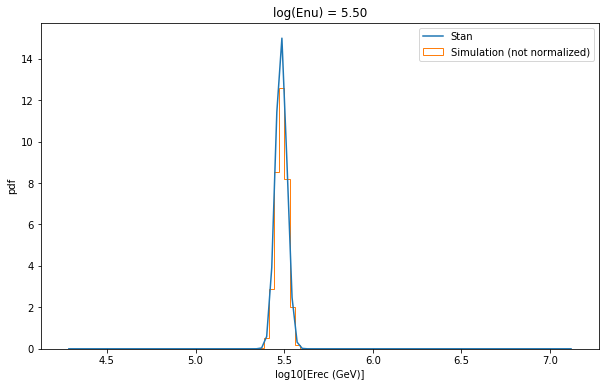

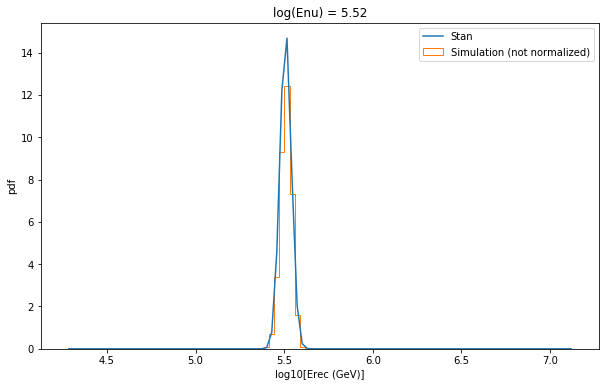

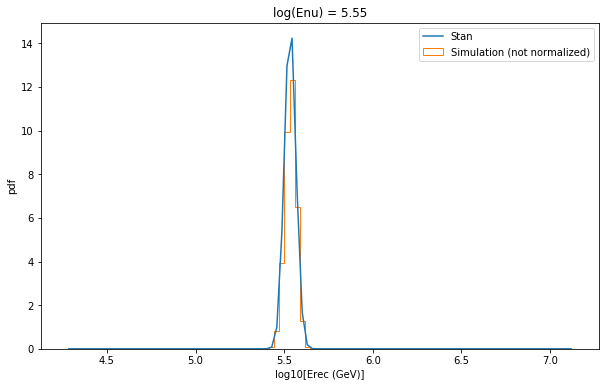

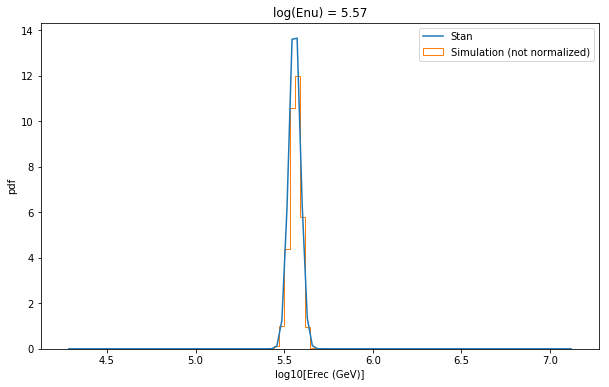

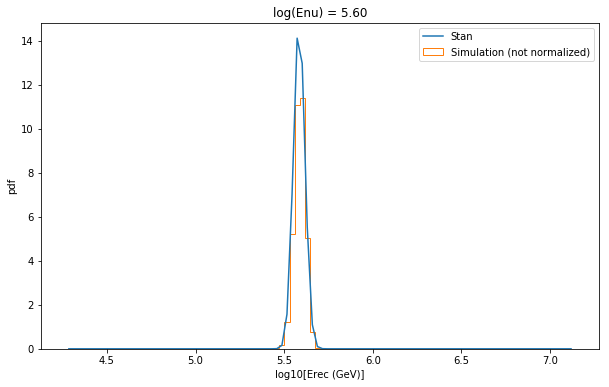

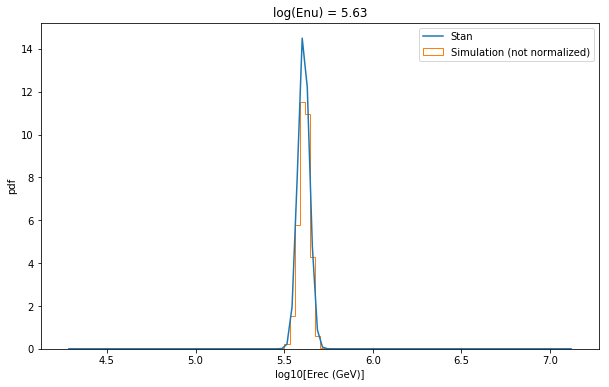

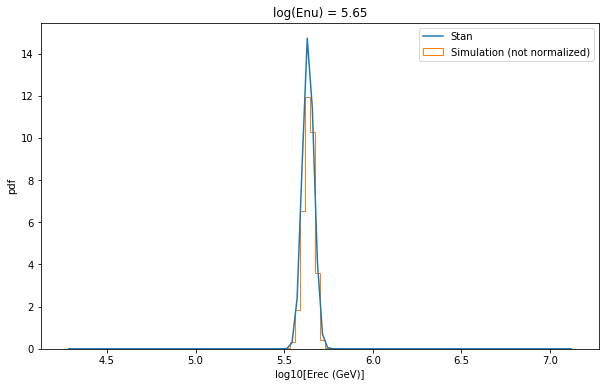

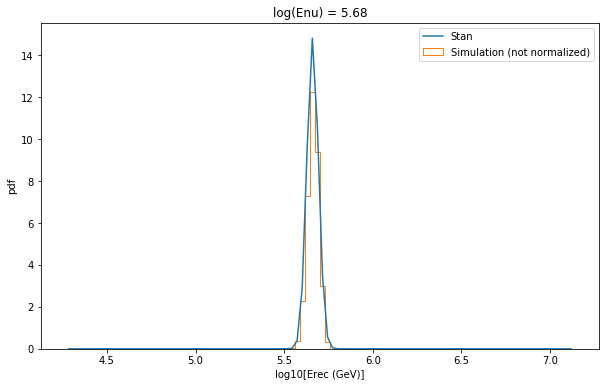

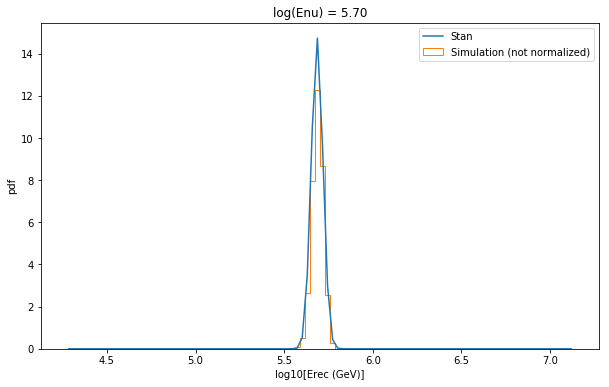

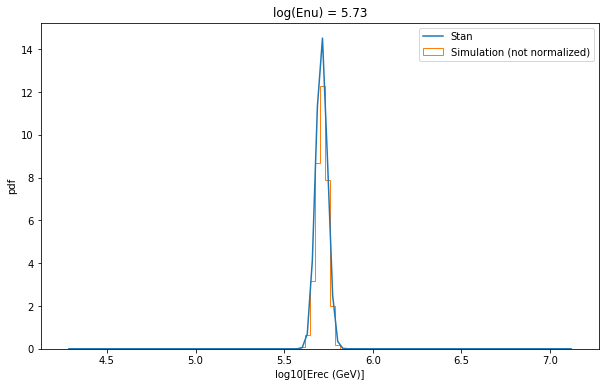

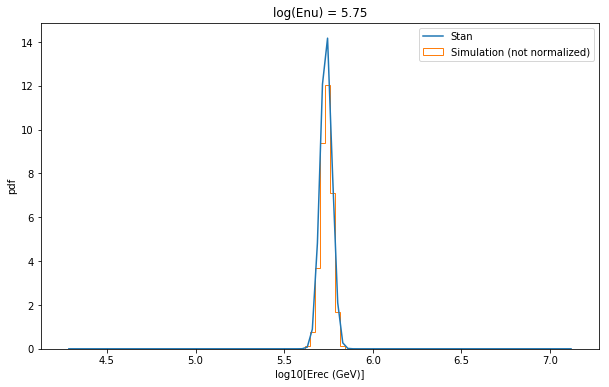

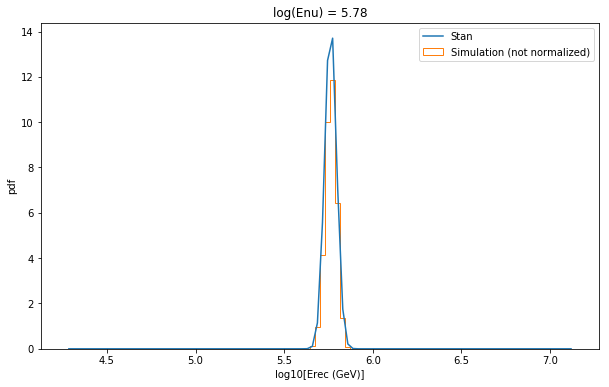

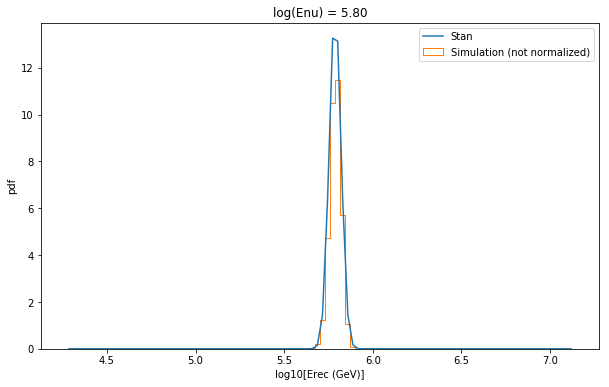

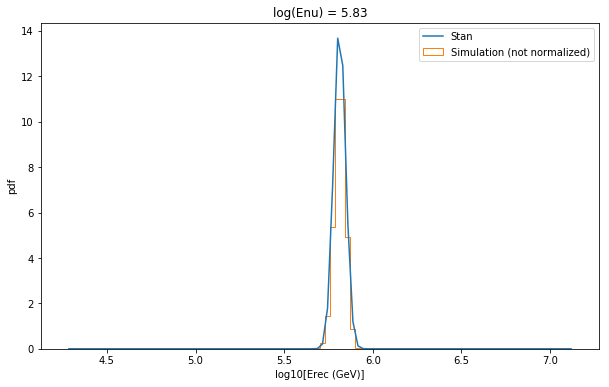

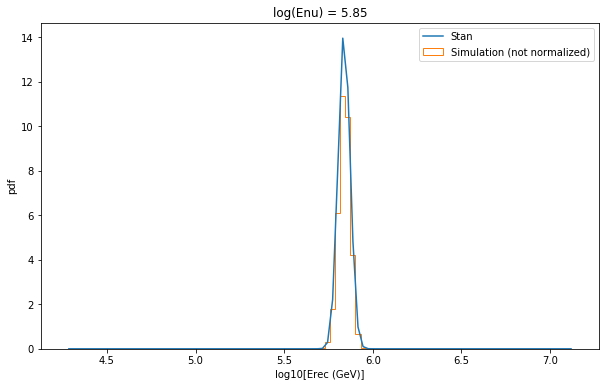

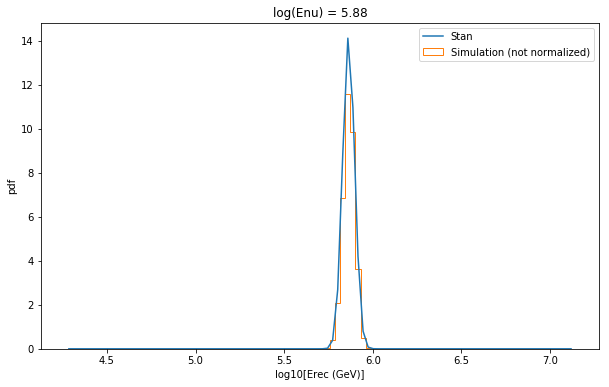

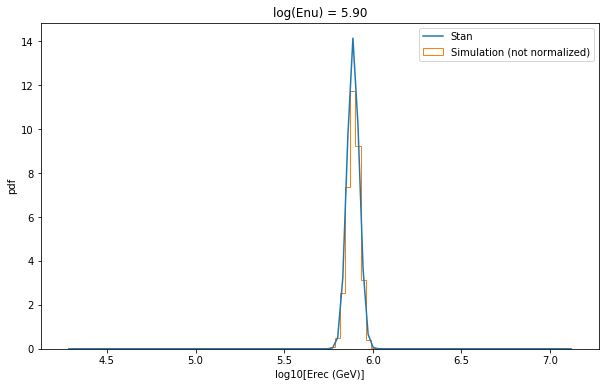

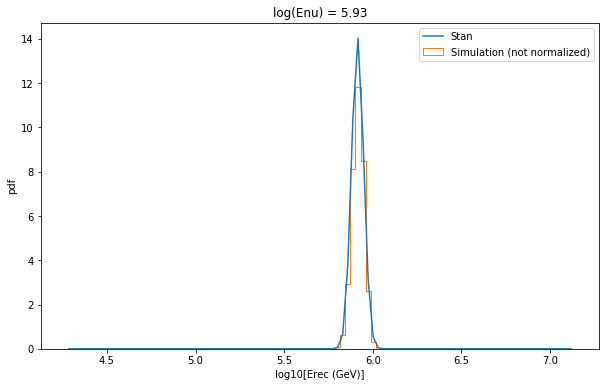

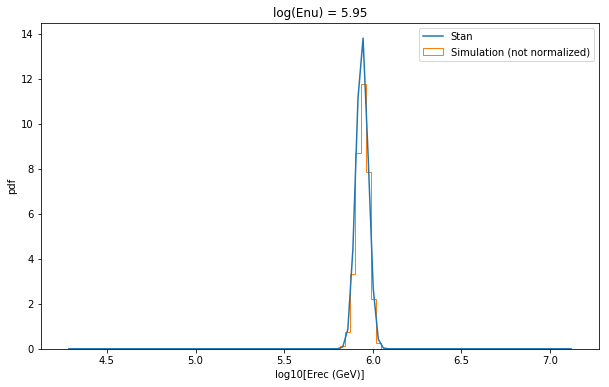

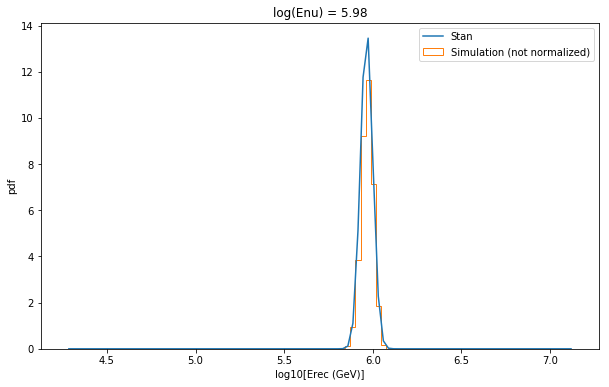

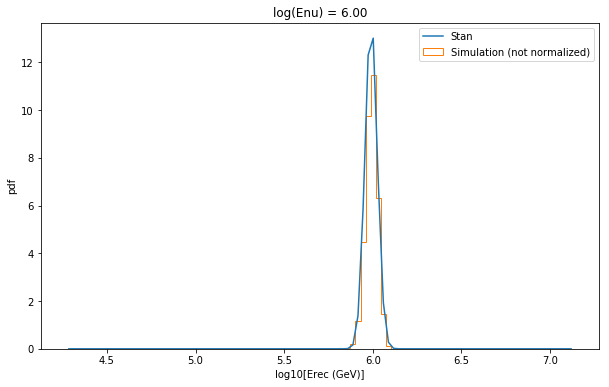

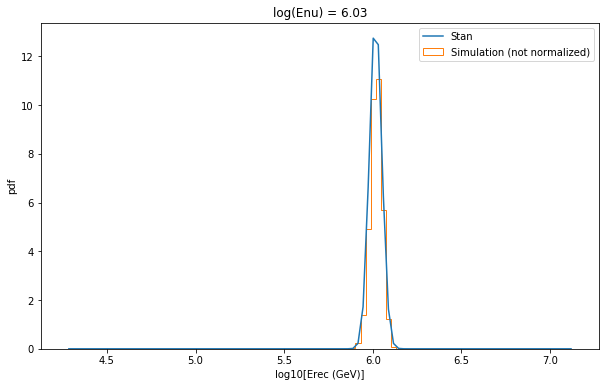

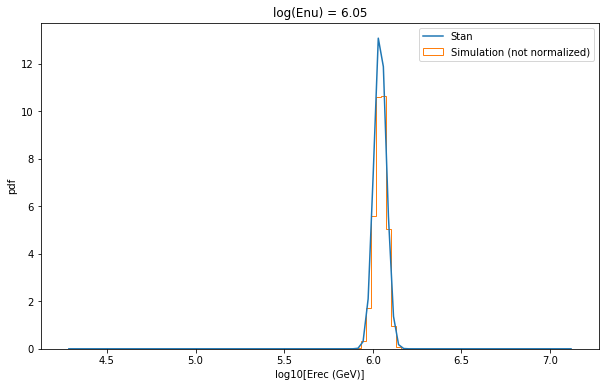

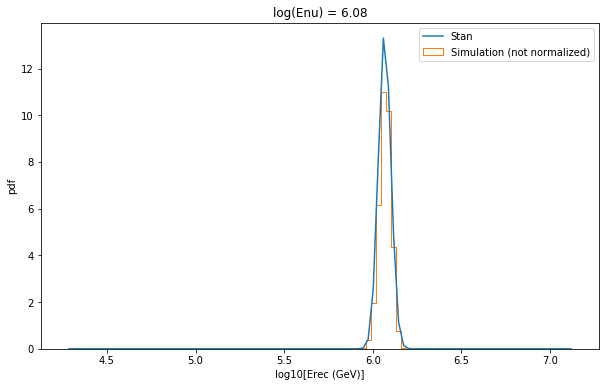

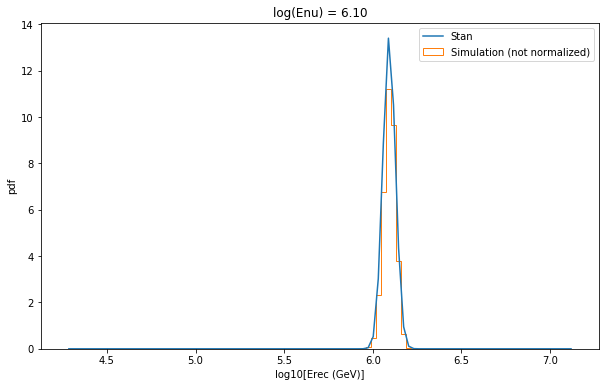

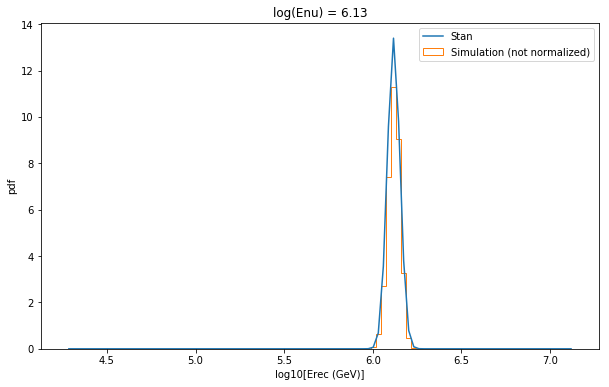

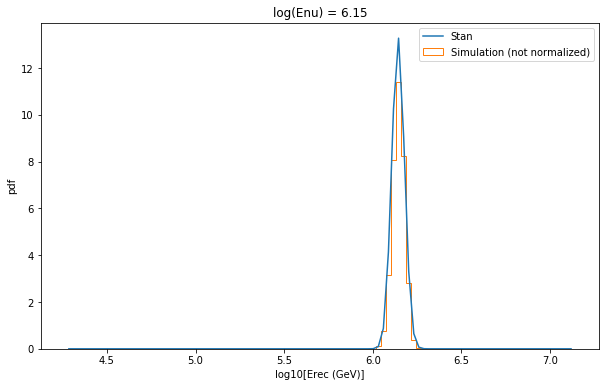

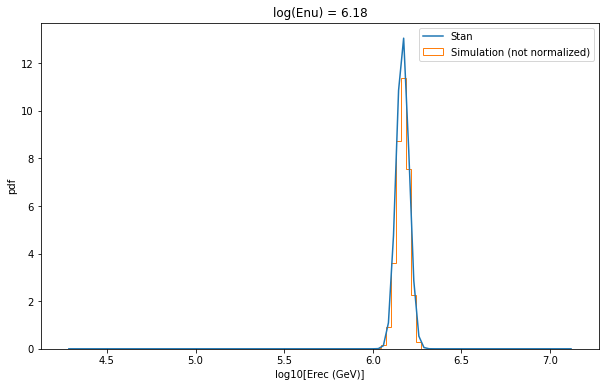

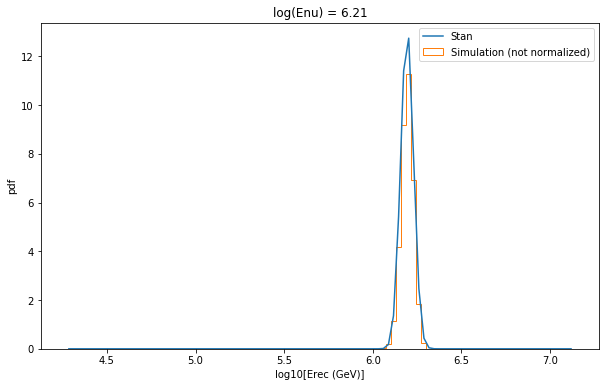

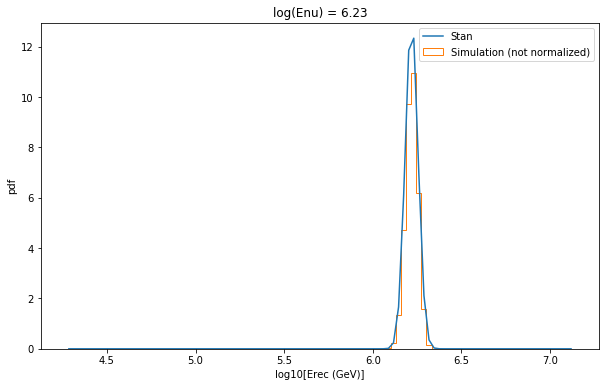

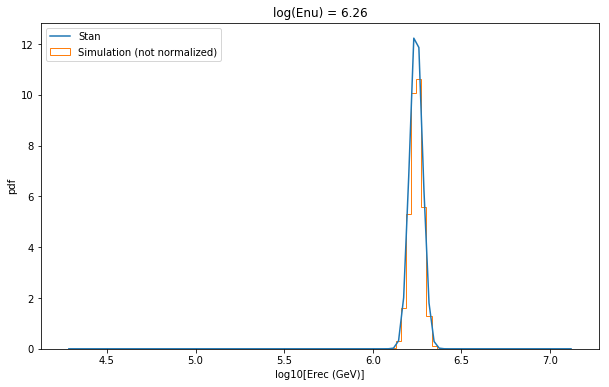

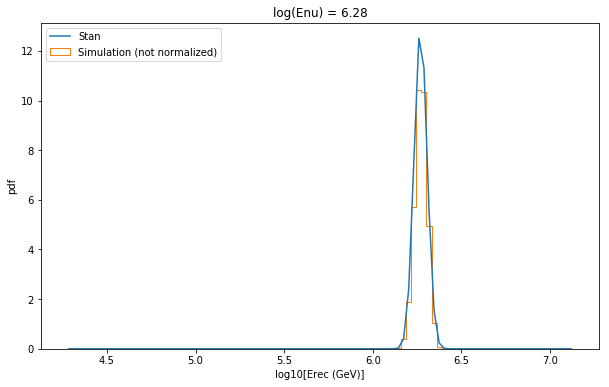

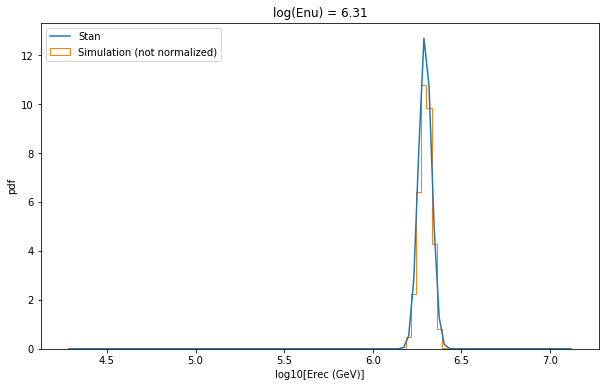

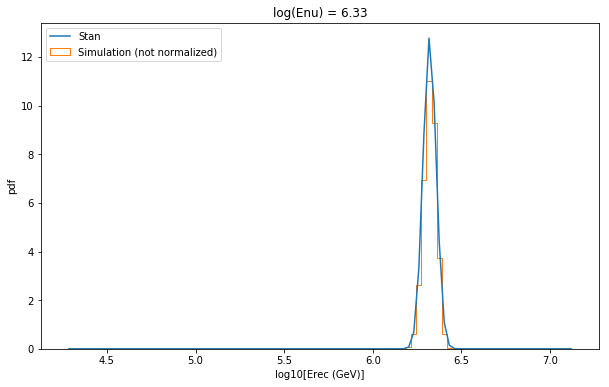

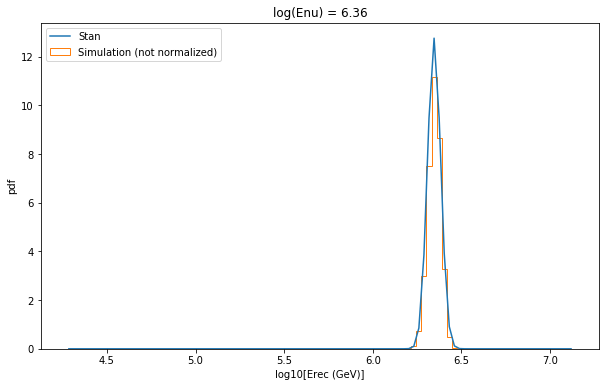

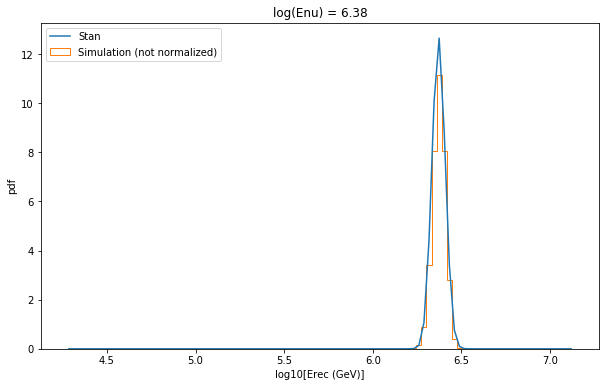

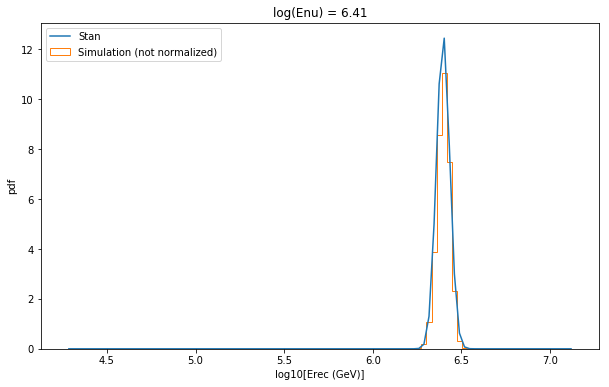

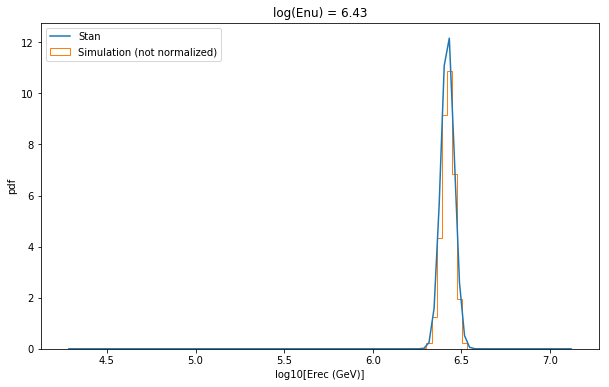

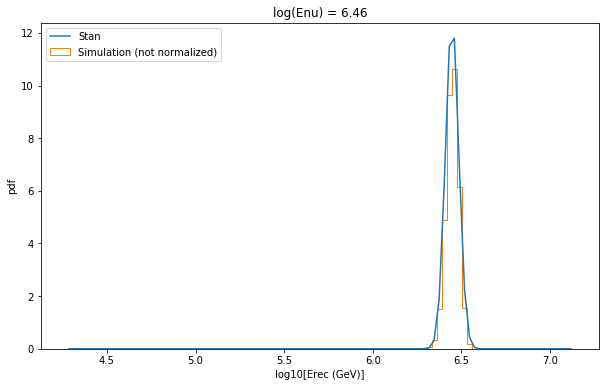

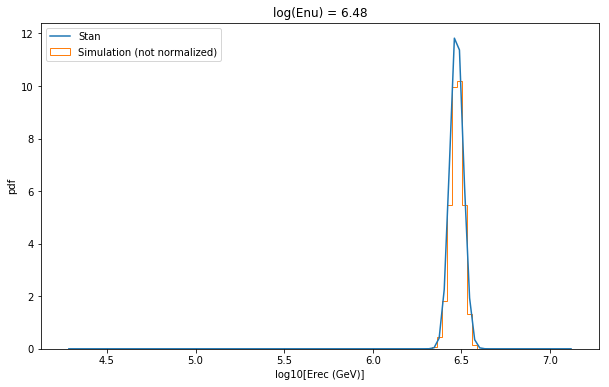

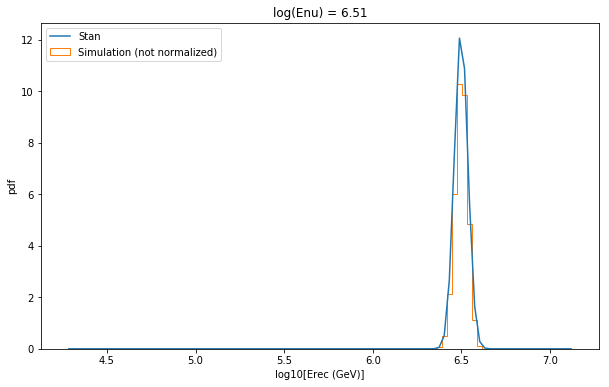

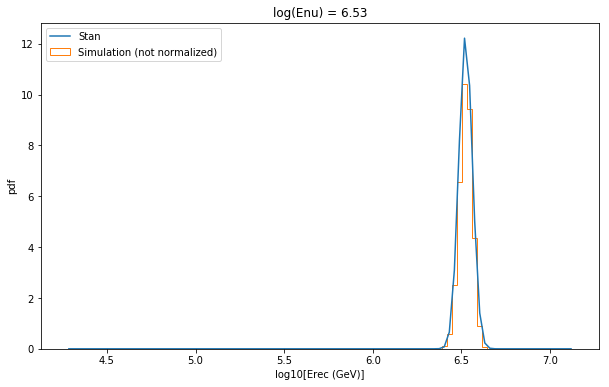

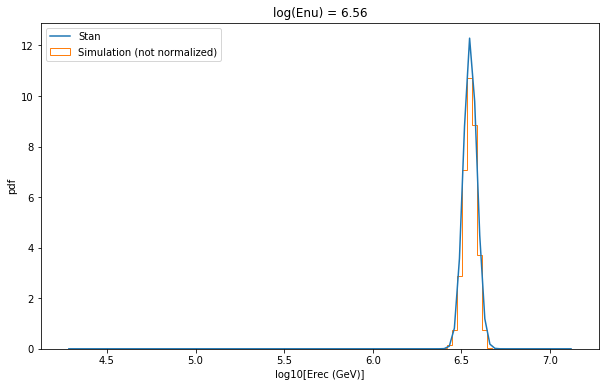

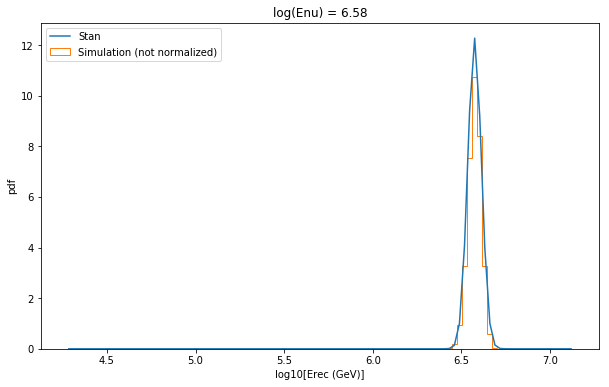

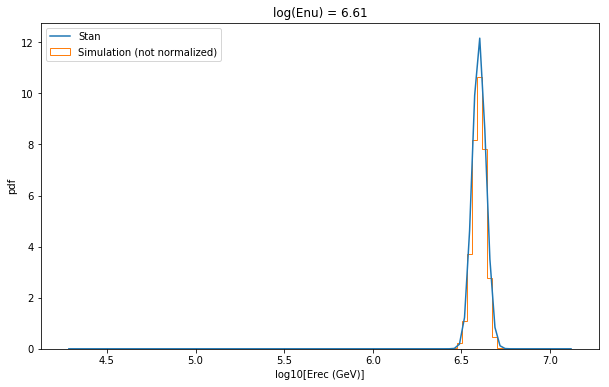

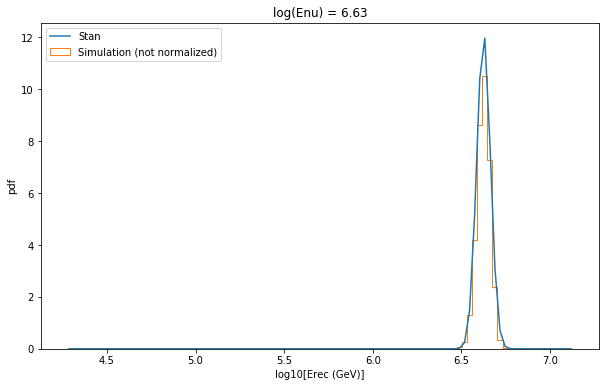

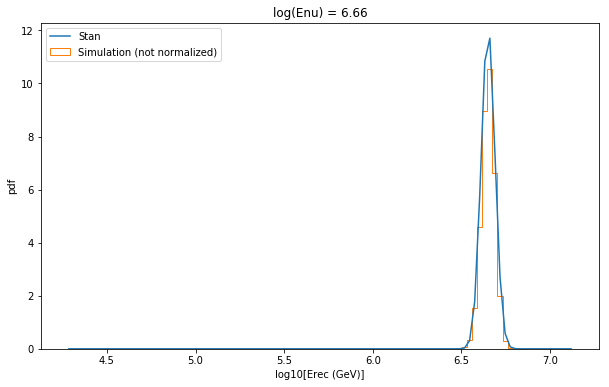

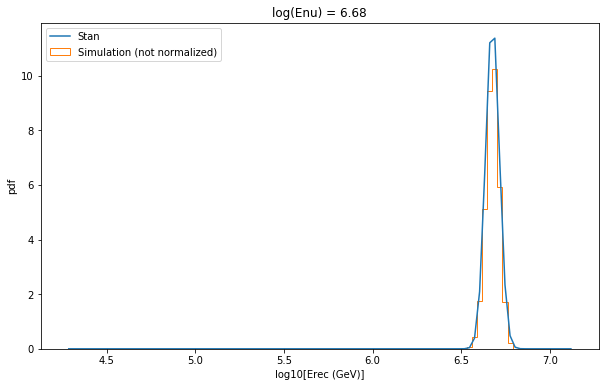

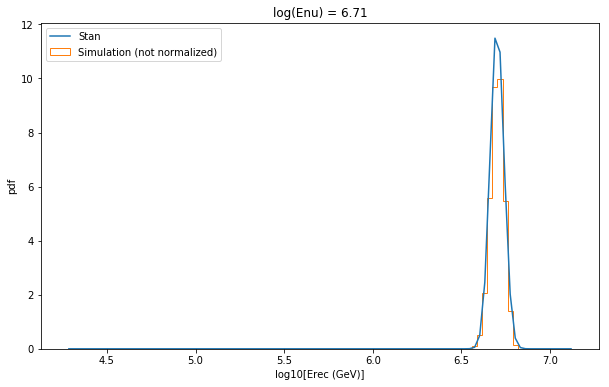

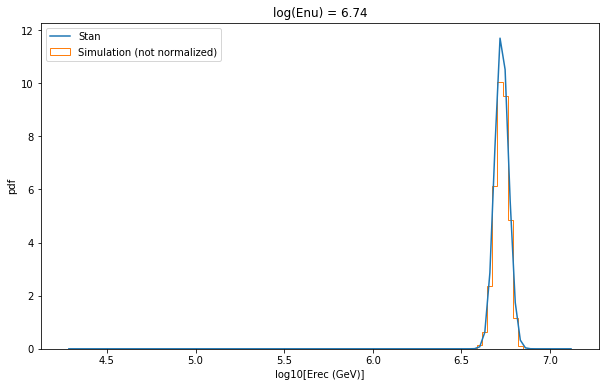

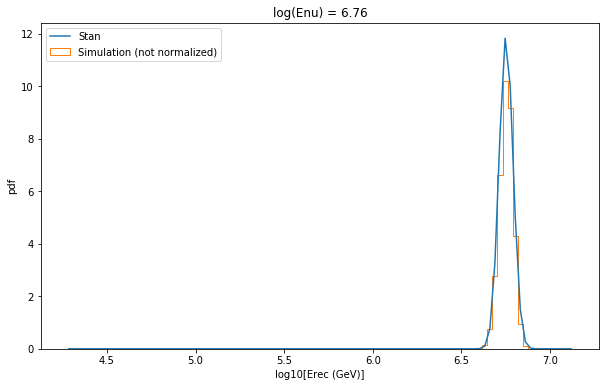

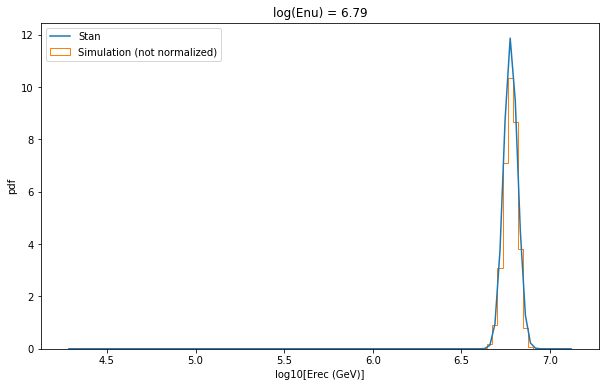

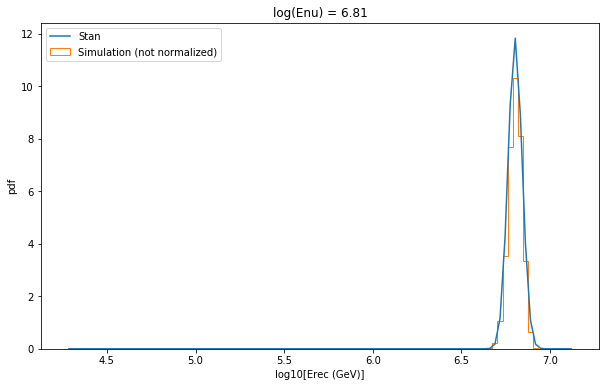

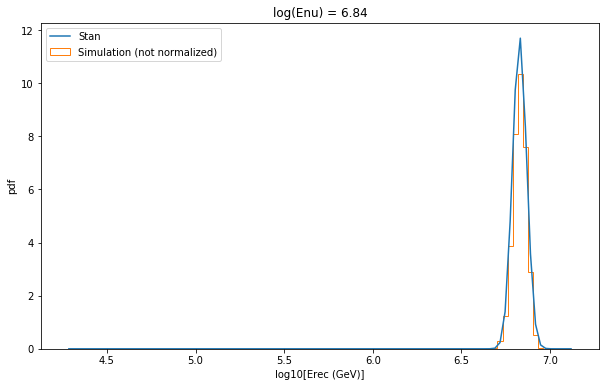

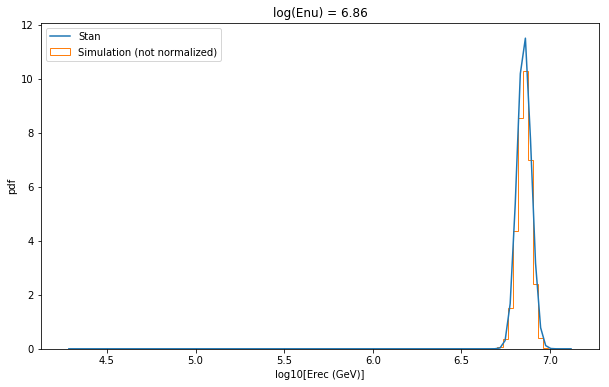

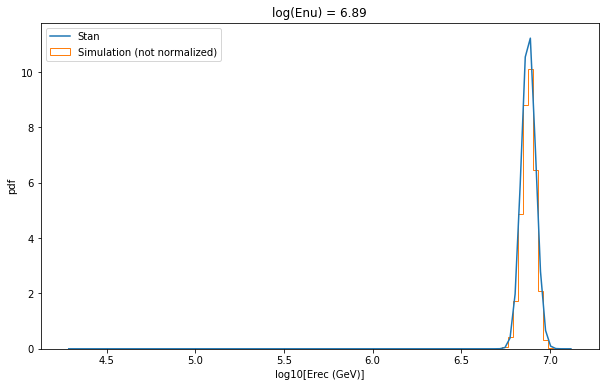

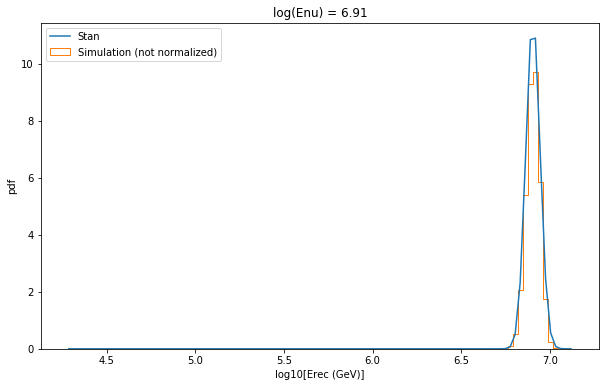

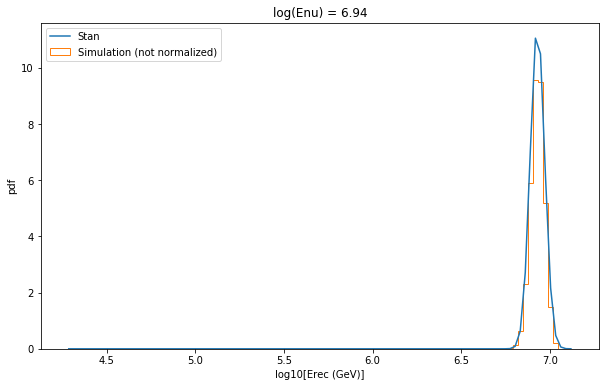

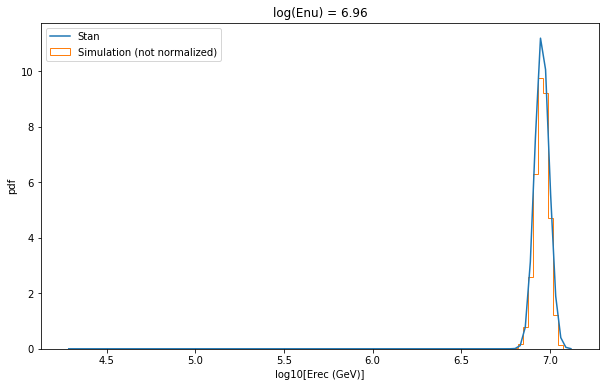

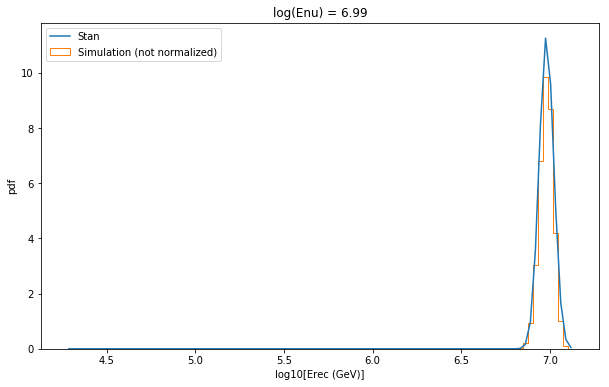

In [39]:
for enu, sl in zip(eprim_bins_CC, binc_CC):
    x = erec_bins_CC
    N = len(erec_bins_CC)
    
    N_pars, N_deg_max = polypars_CC.shape
    
    
    param_pars = {
        'N': N,
        'x': x,
        'N_pars': N_pars,
        'N_degree_max': N_deg_max,
        'par_coeffs': polypars_CC,
        'enu': enu
    }
    
    cascade_output = cascade_CC.sampling(data=param_pars, algorithm='Fixed_param', iter=1, chains=1)
    prob = np.exp(cascade_output.extract('y')['y'][0])
    plt.figure(figsize=(10,6))
    plt.title('log(Enu) = %.2f' %(enu))
    plt.plot(erec_bins_CC, prob, label='Stan')
    # normalize sim
    sl = sl / sl.sum() / erec_binw_CC
    # HESE cut
    norm = np.sum(sl[idx]) * erec_binw_CC
    idx = np.where(erec_bins_CC > np.log10(6e4))
    norm = np.sum(sl[idx])
    plt.hist(erec_bins_CC, weights=sl, bins = erec_edges_CC, label='Simulation (not normalized)', histtype='step')
    plt.xlabel('log10[Erec (GeV)]')
    plt.ylabel('pdf')
    plt.legend()

In [40]:
cascade_NC = pystan.StanModel(file='./stan/NC_demo.stan', include_paths='./stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dee05b9c13bcc388f29fbf7e4753c426 NOW.


/home/mhaminh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide
/home/mhaminh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


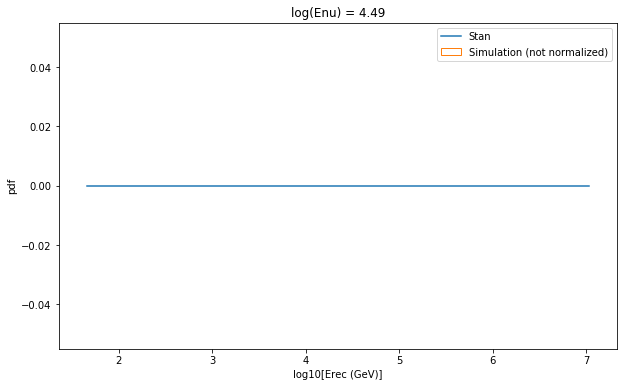

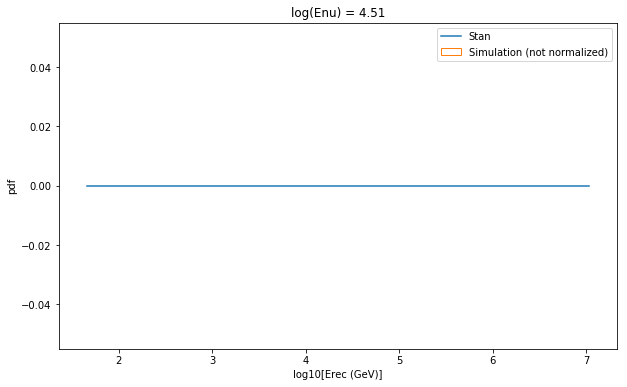

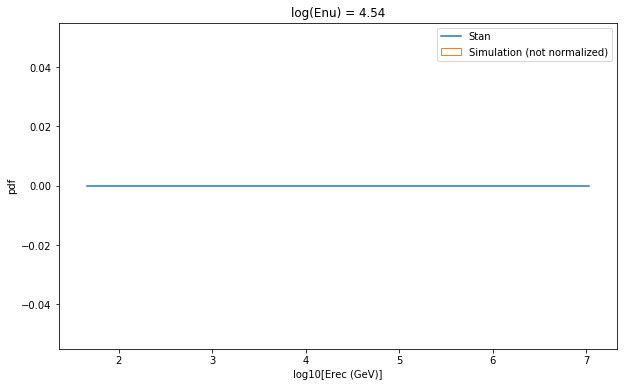

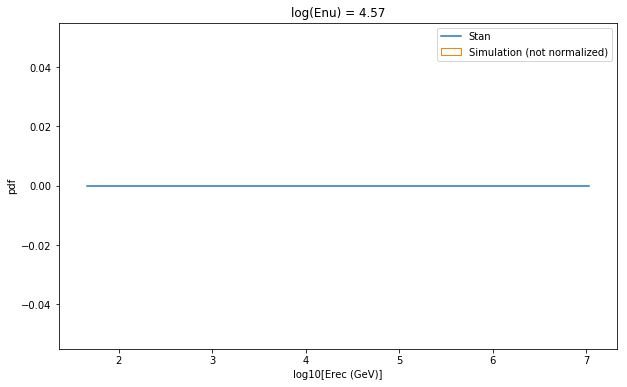

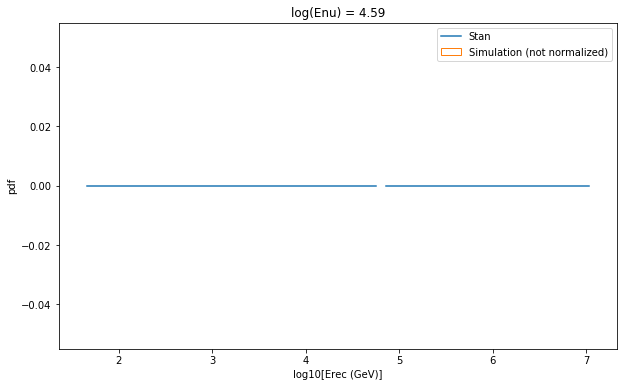

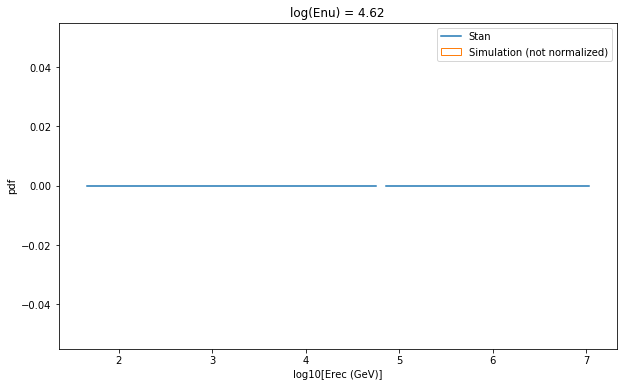

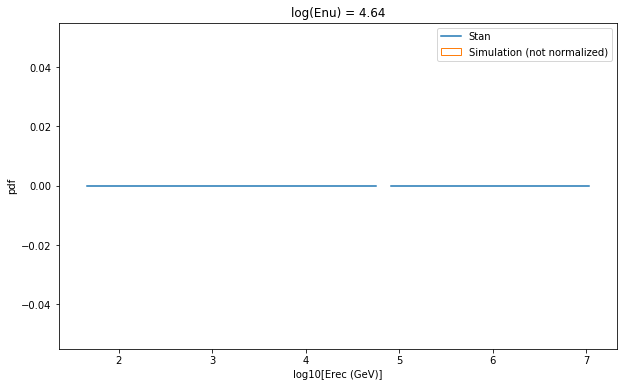

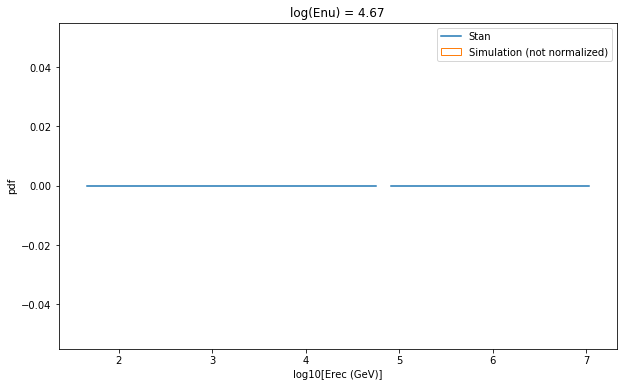

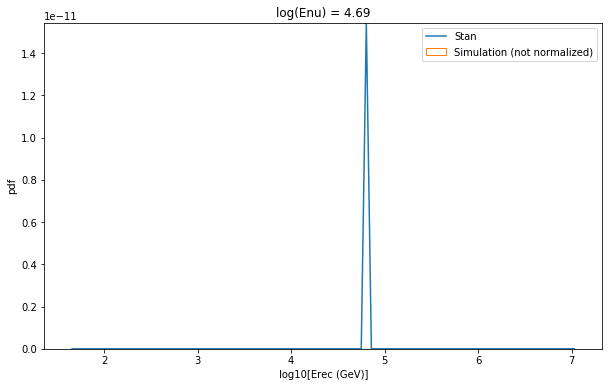

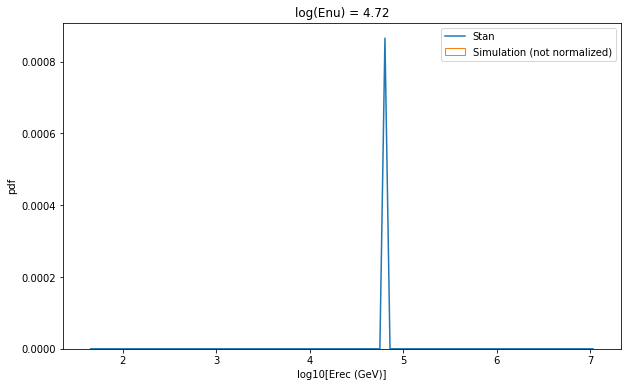

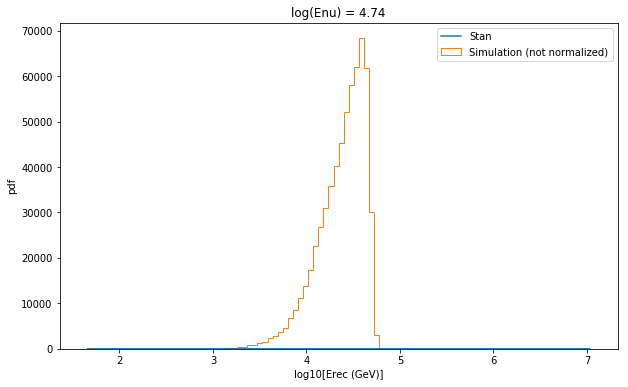

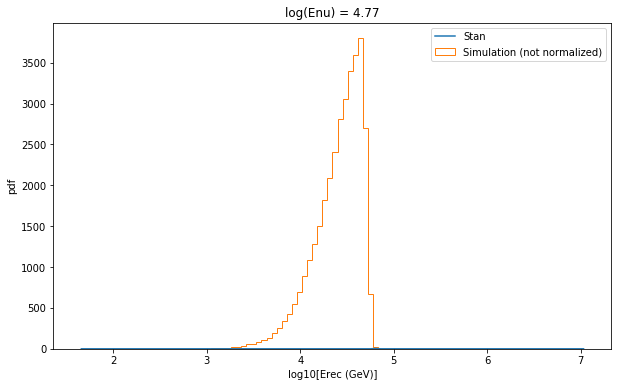

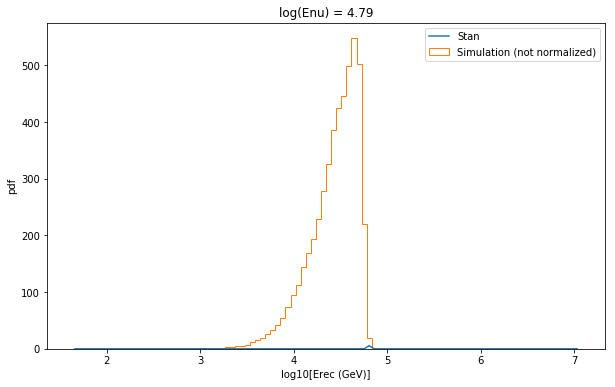

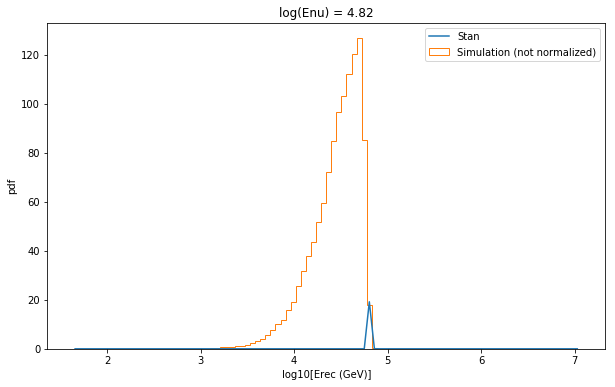

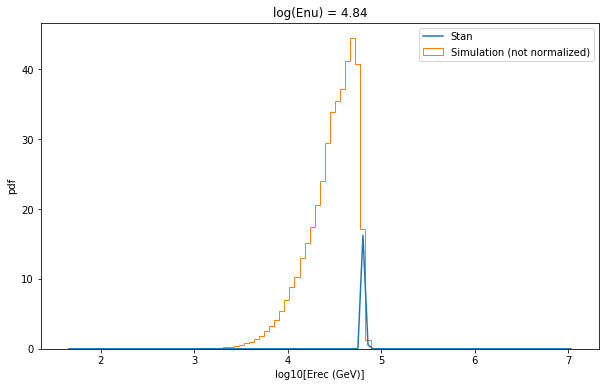

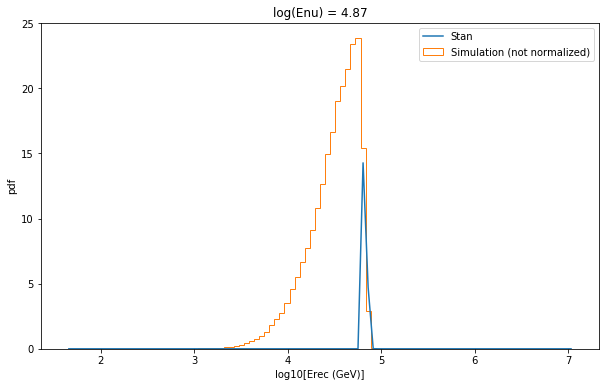

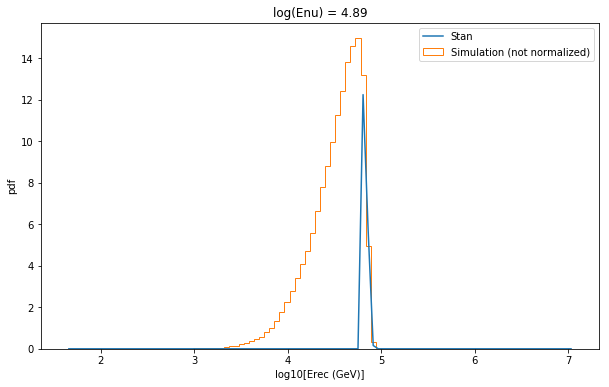

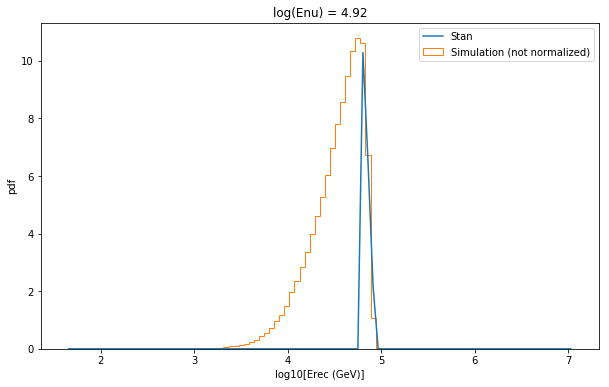

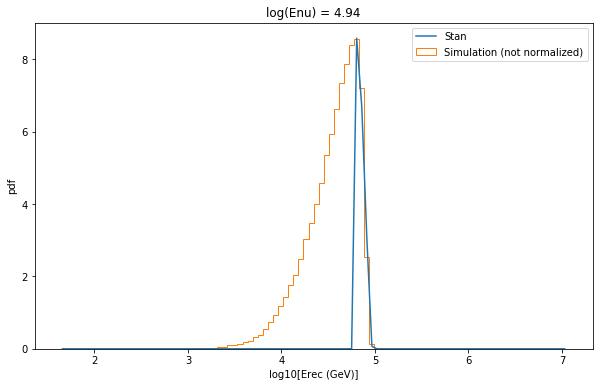

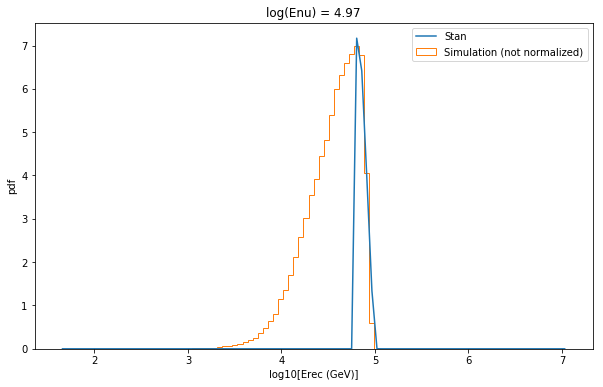

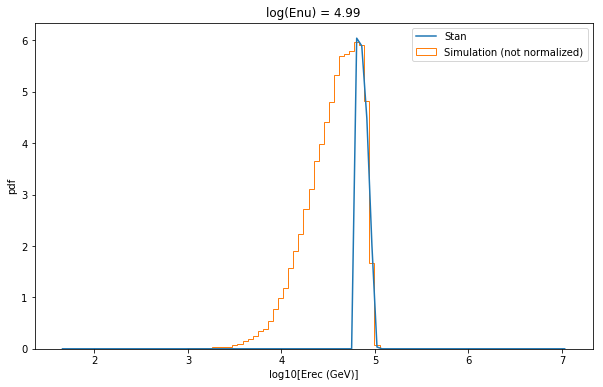

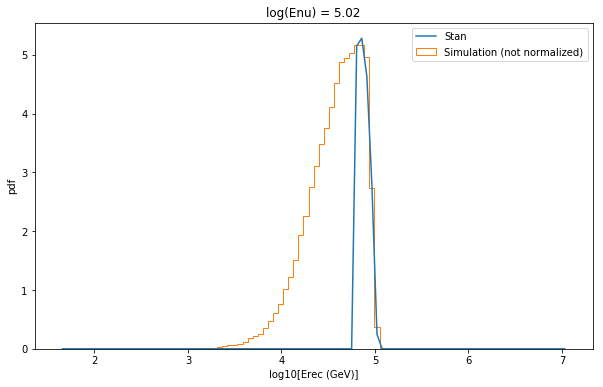

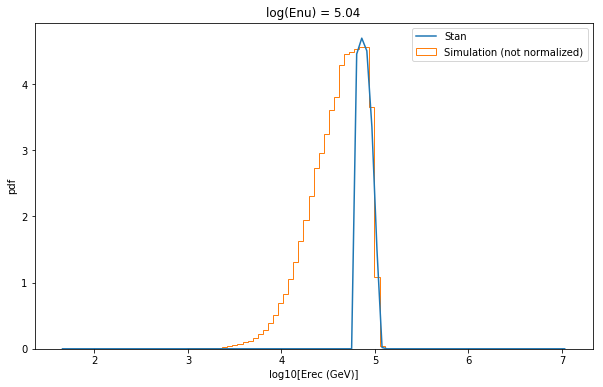

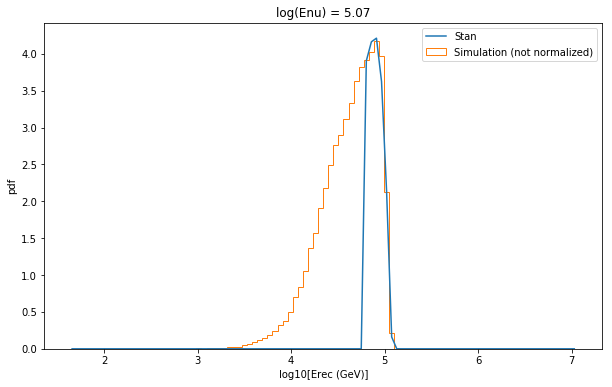

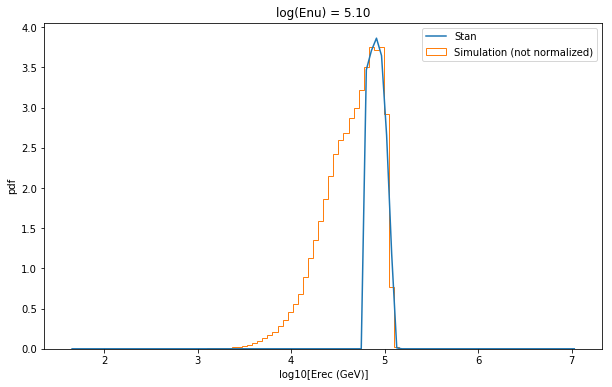

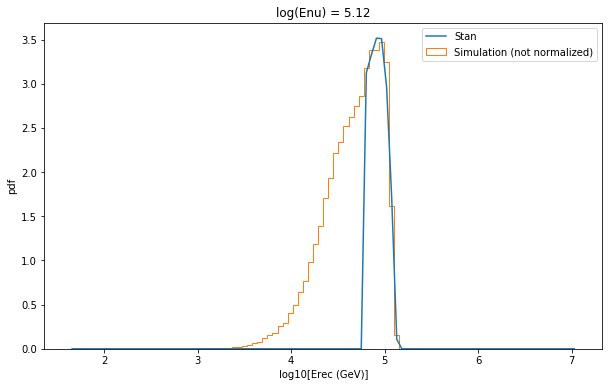

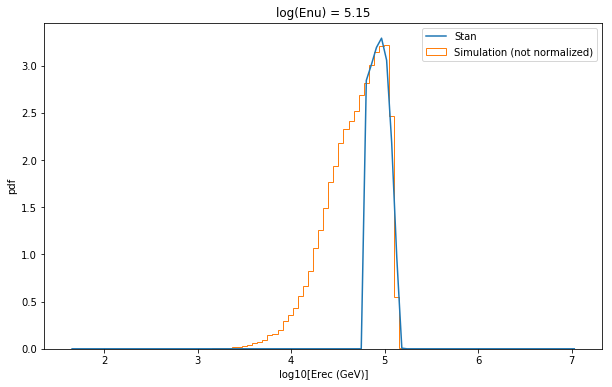

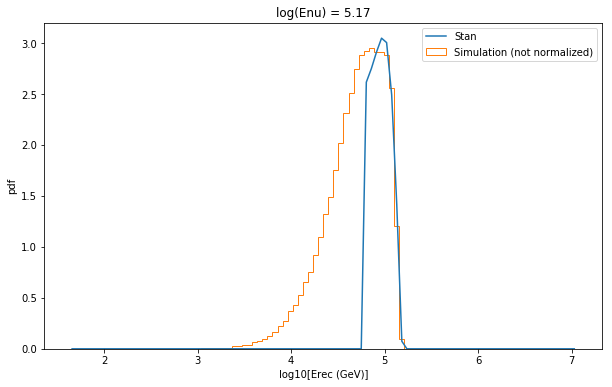

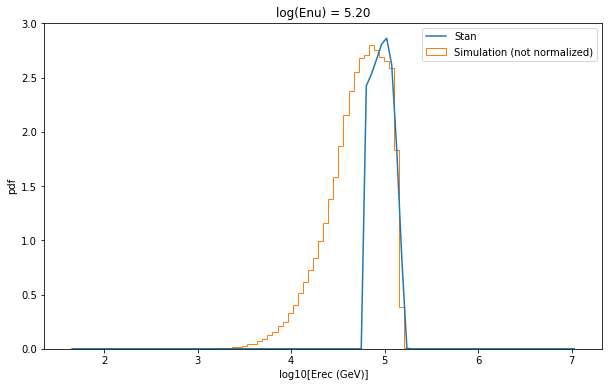

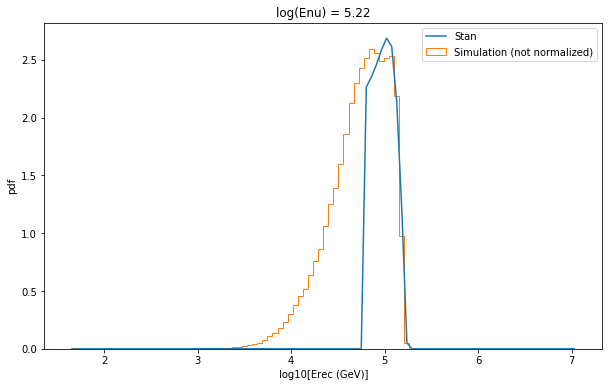

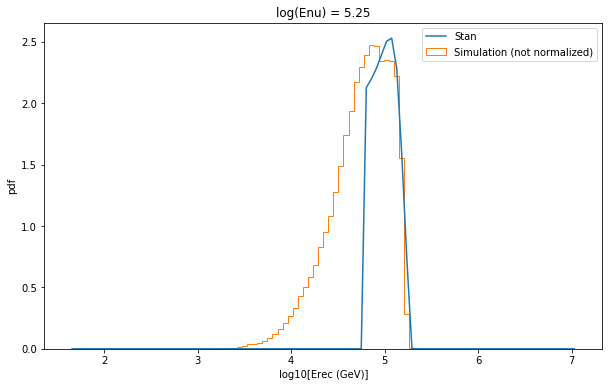

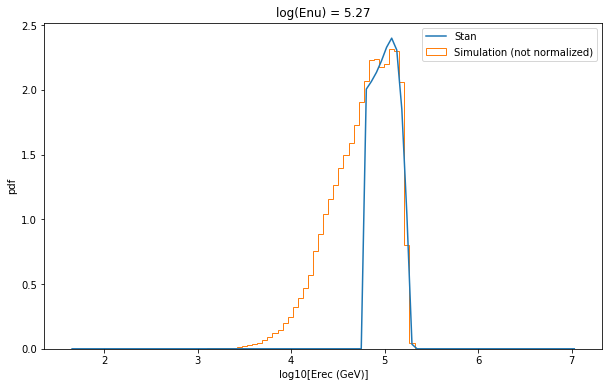

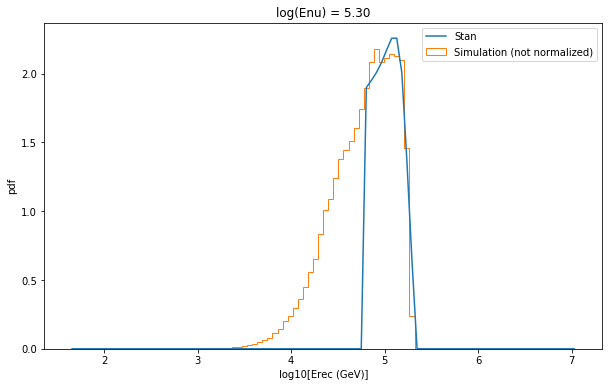

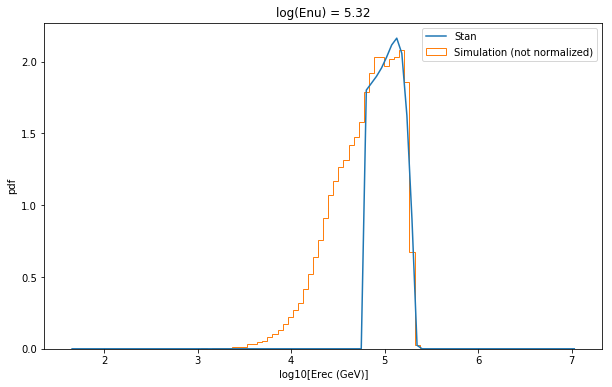

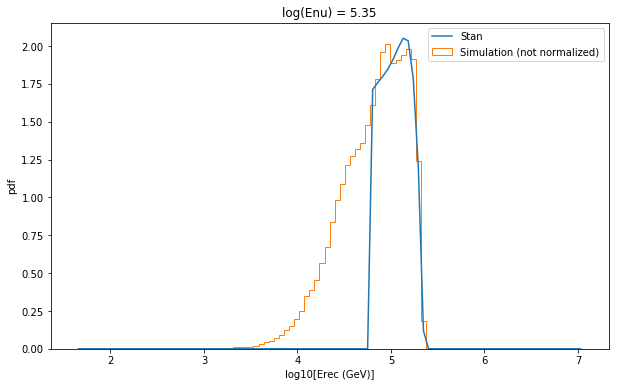

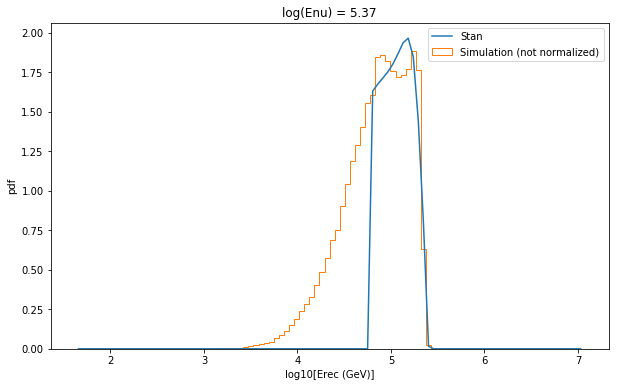

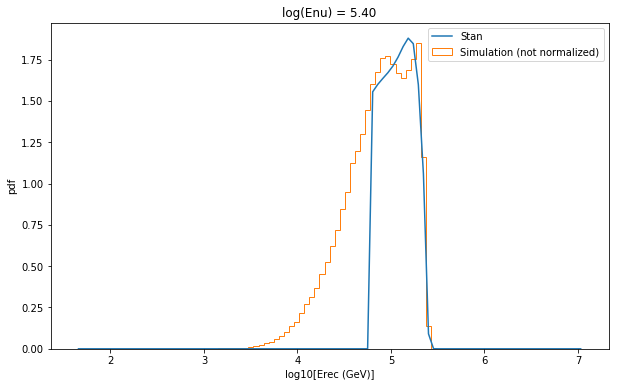

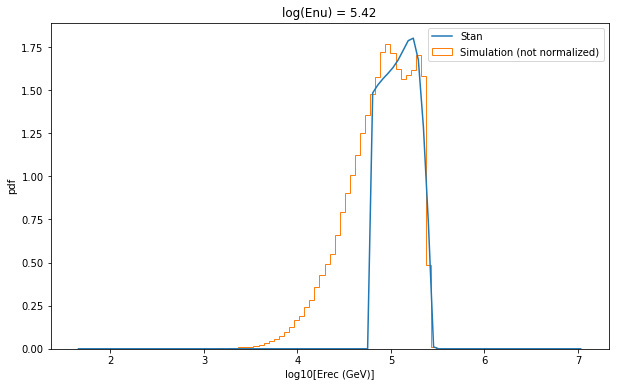

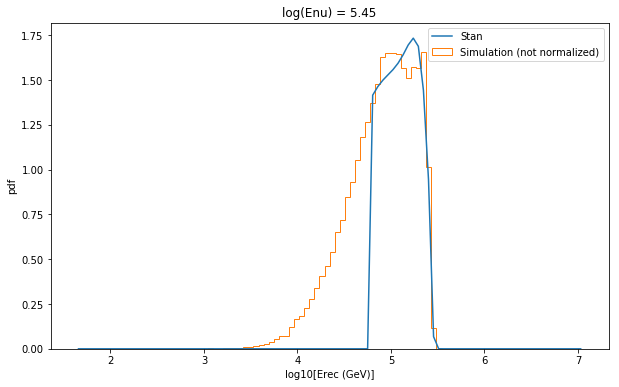

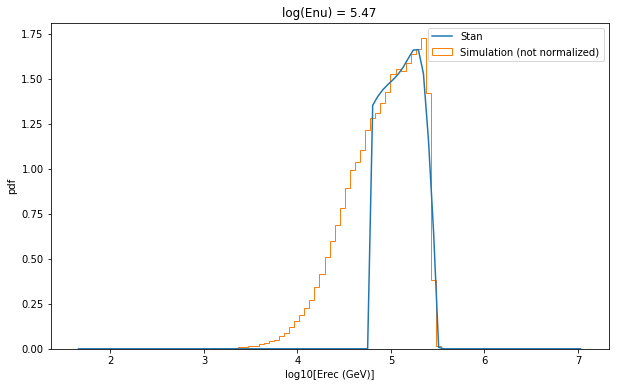

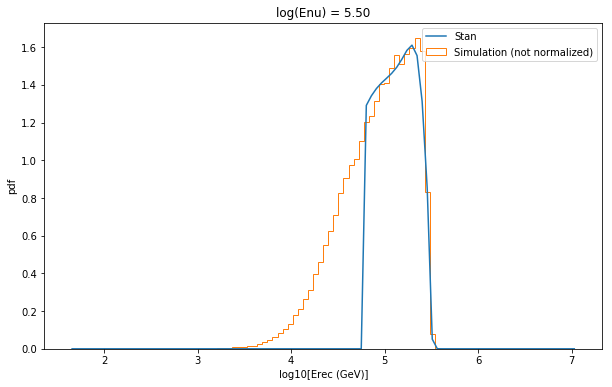

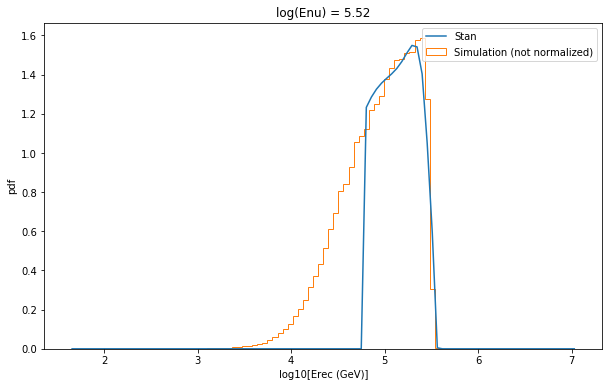

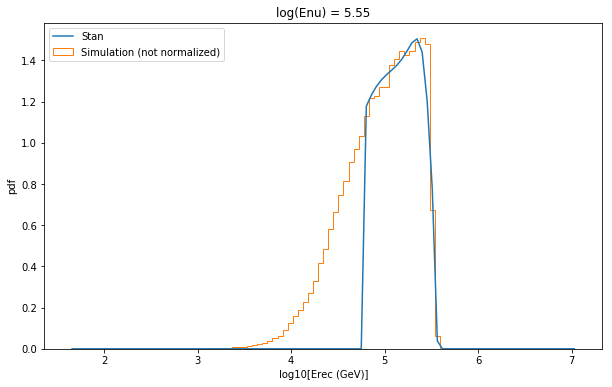

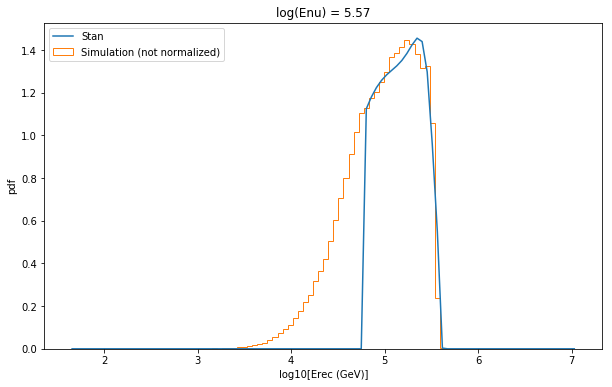

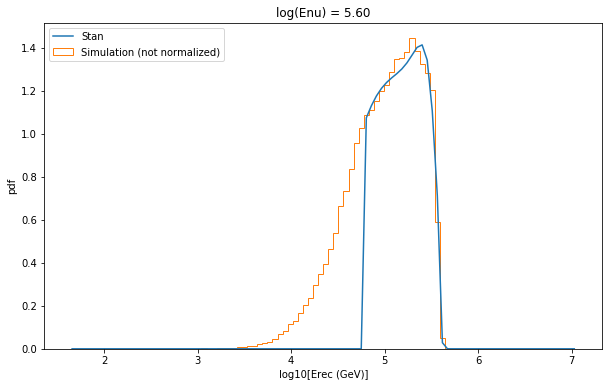

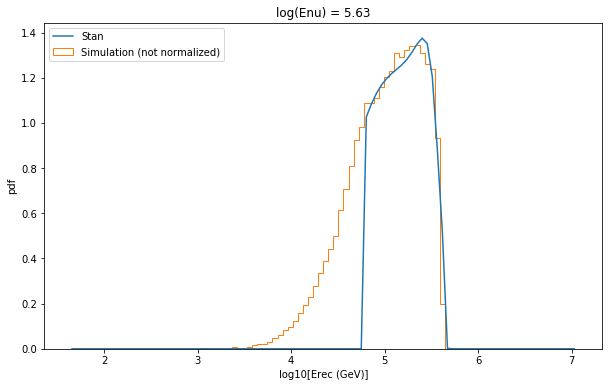

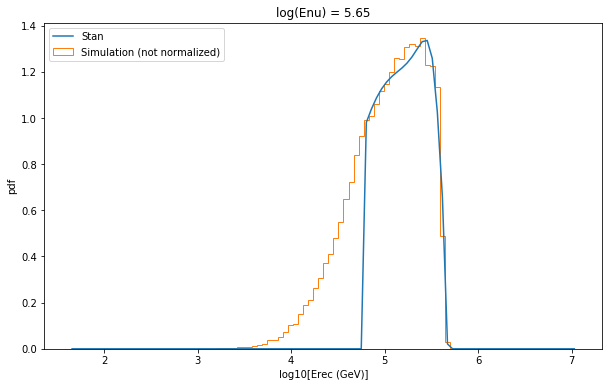

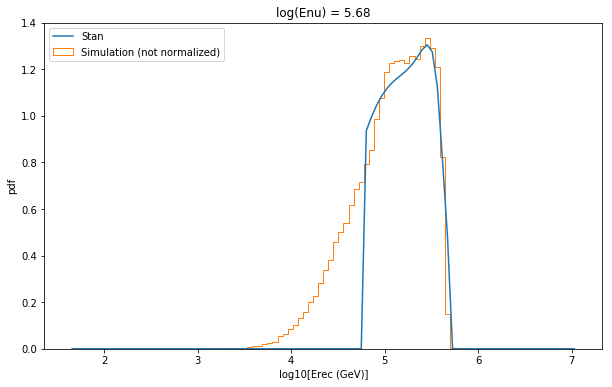

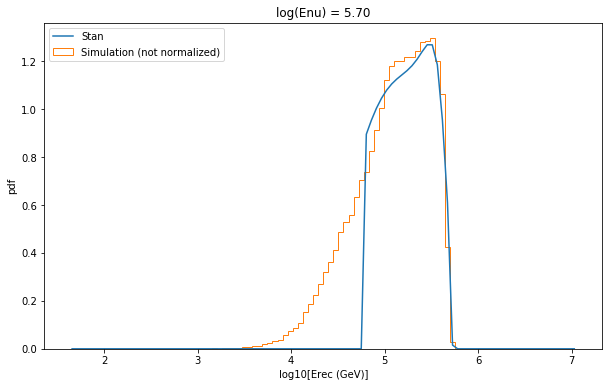

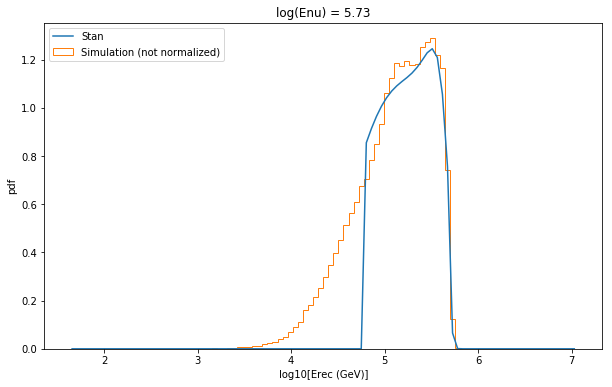

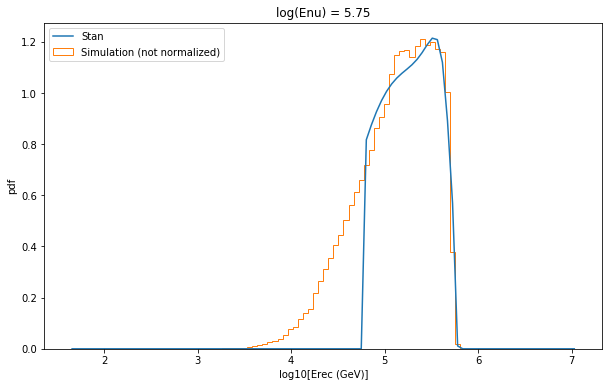

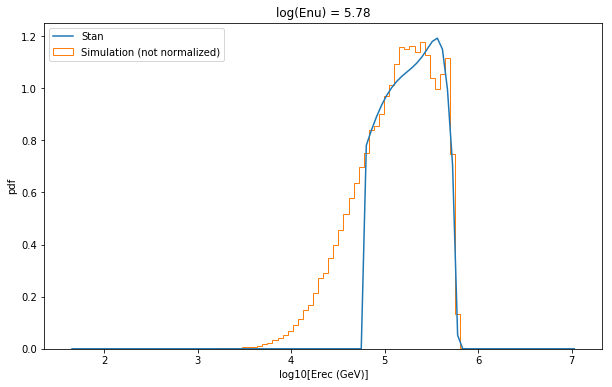

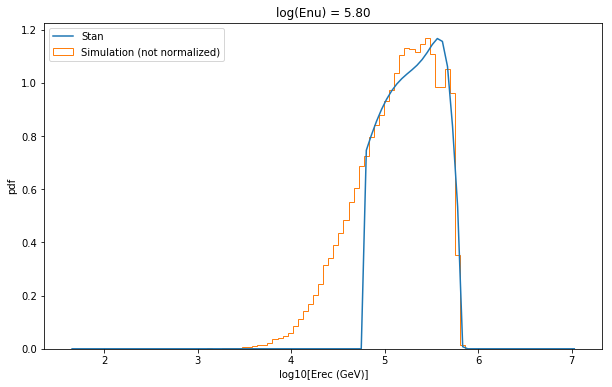

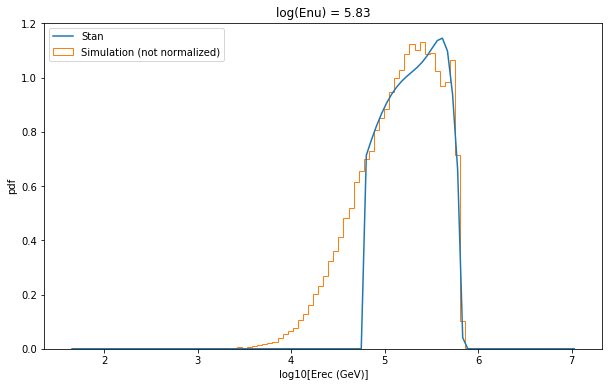

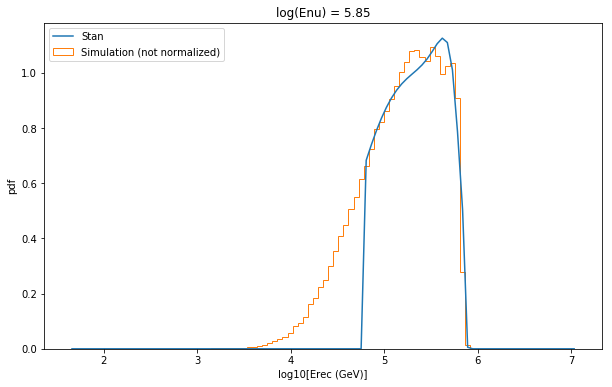

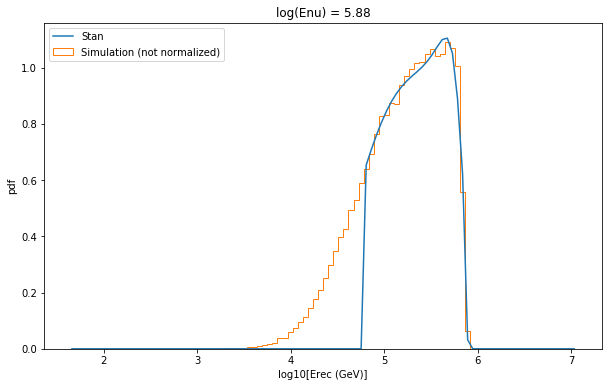

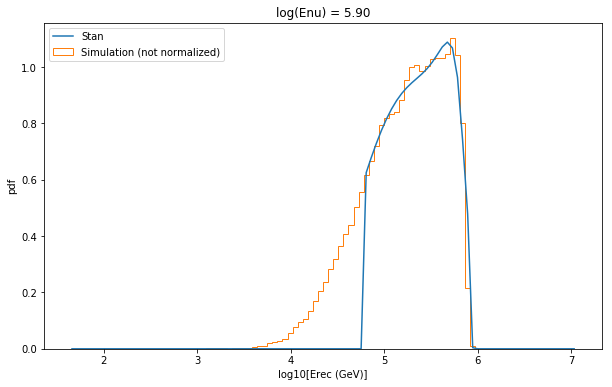

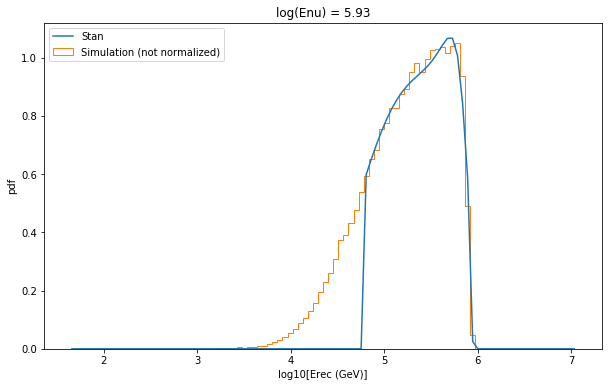

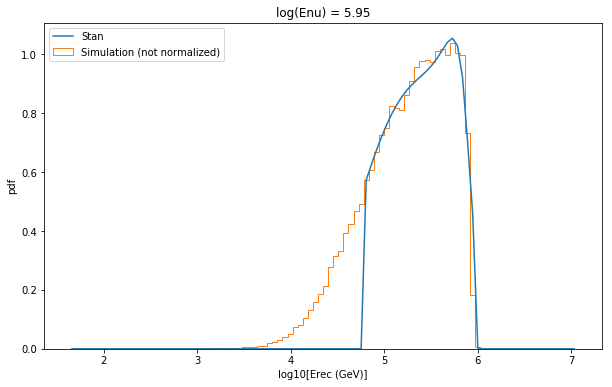

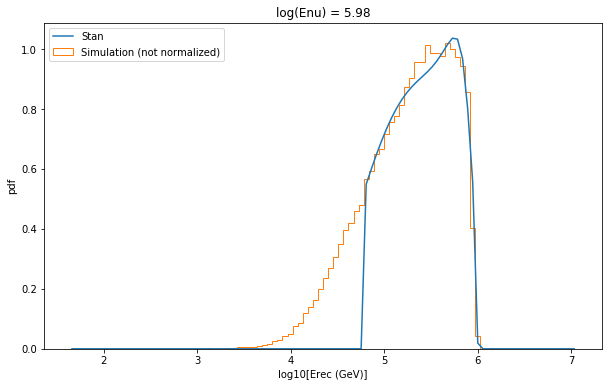

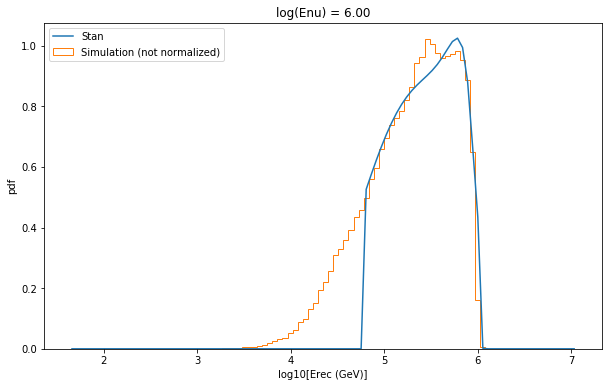

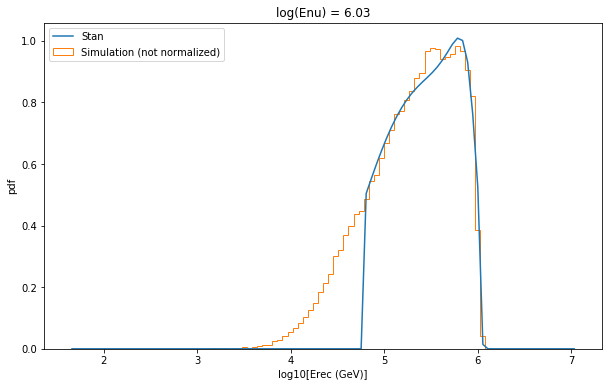

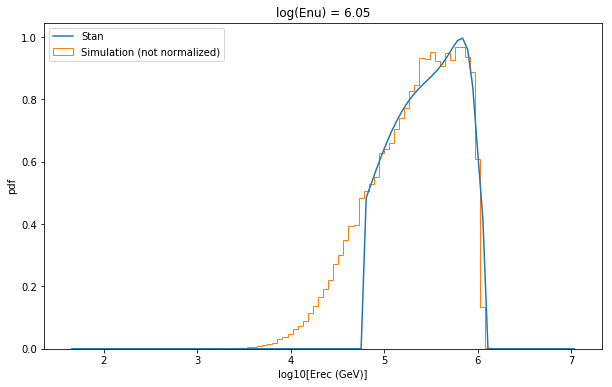

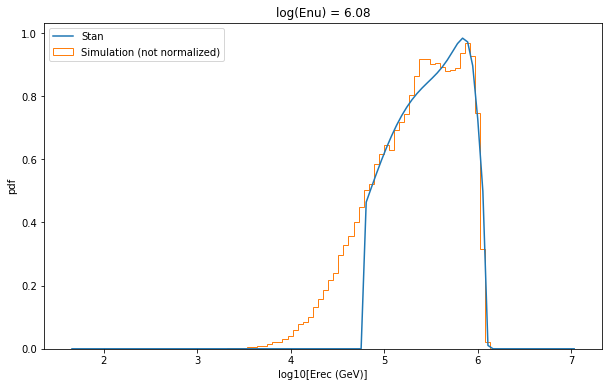

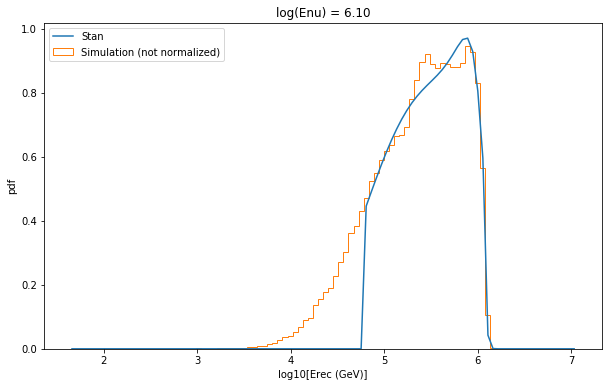

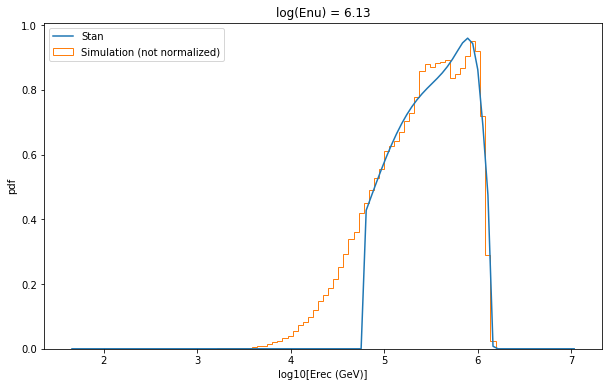

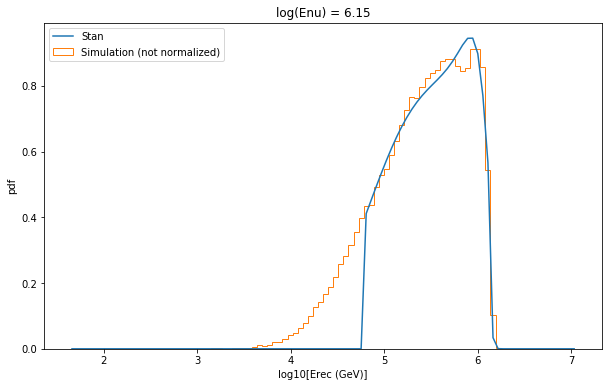

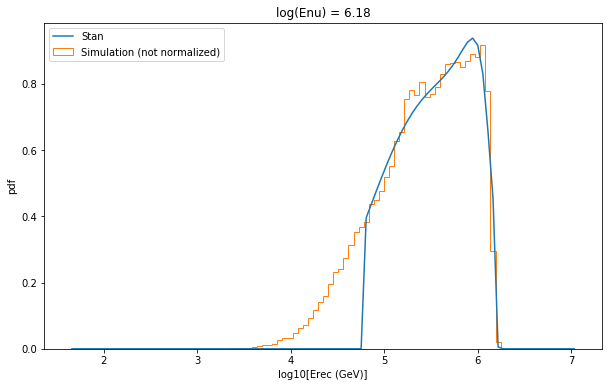

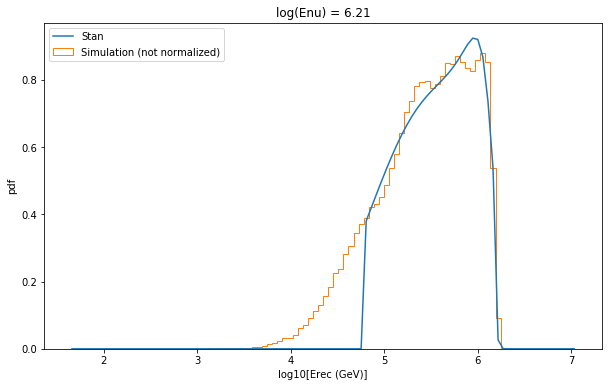

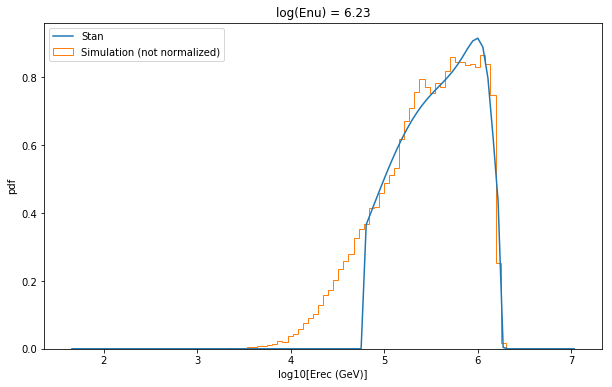

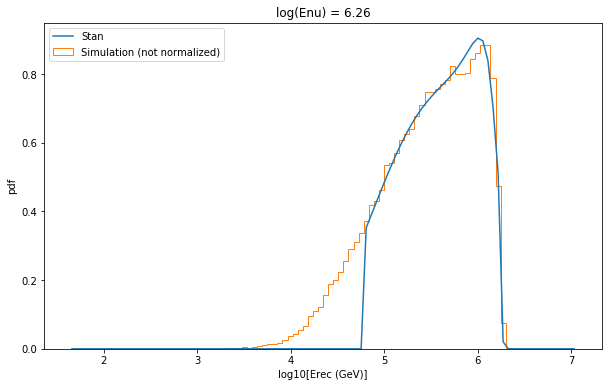

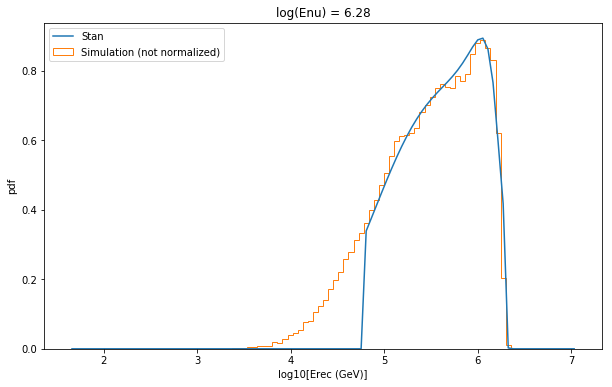

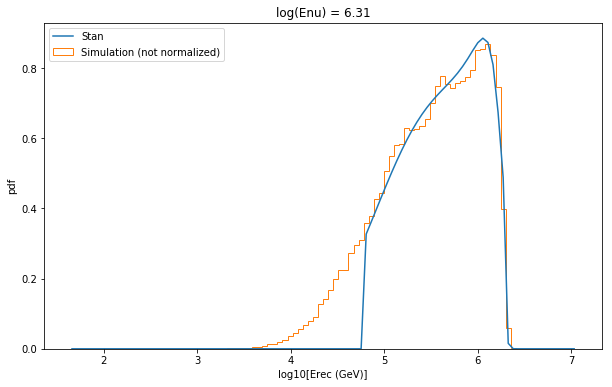

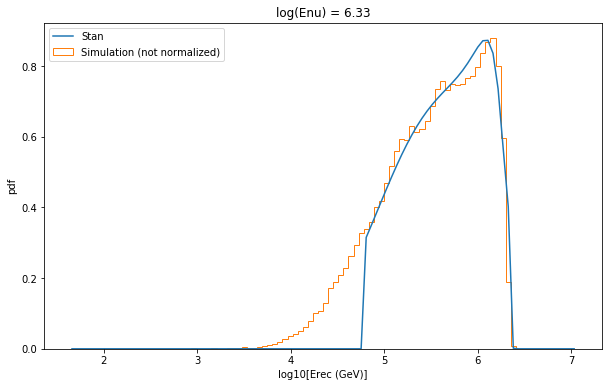

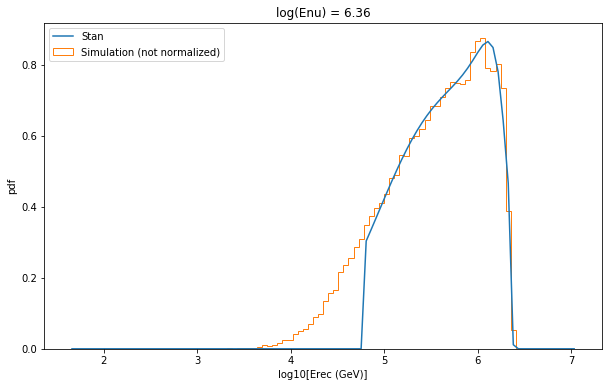

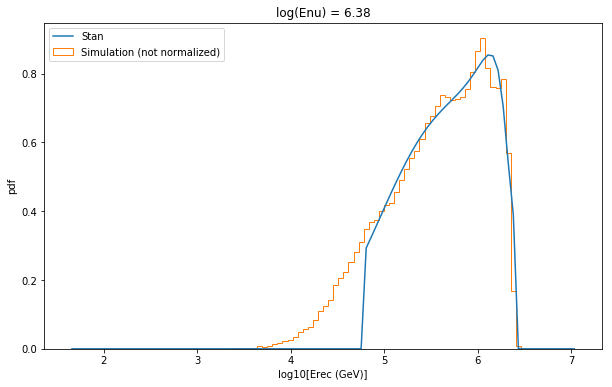

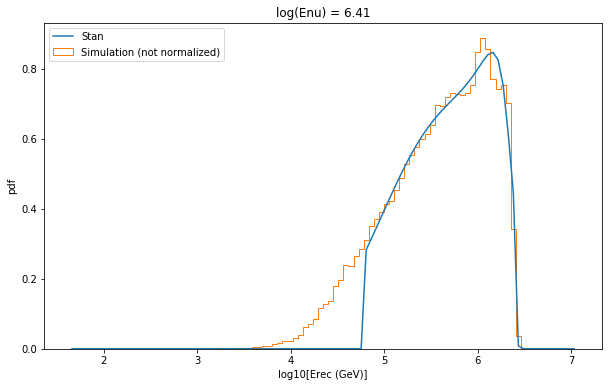

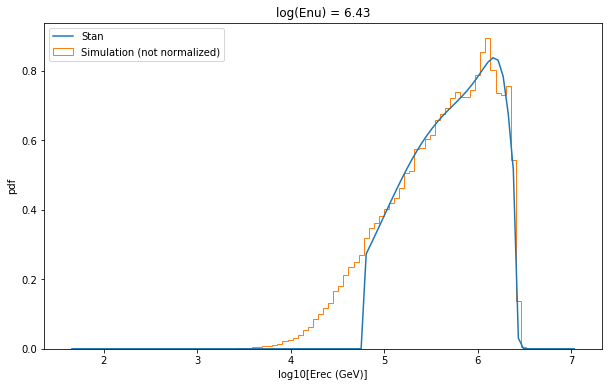

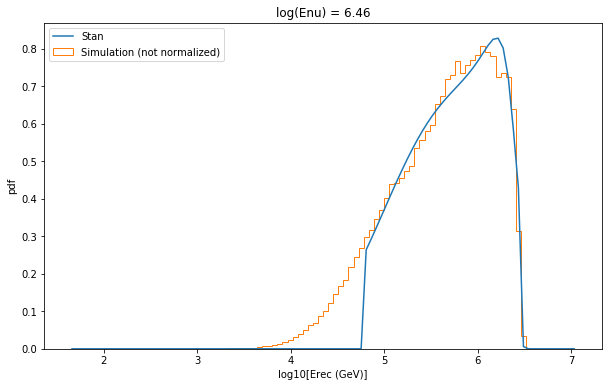

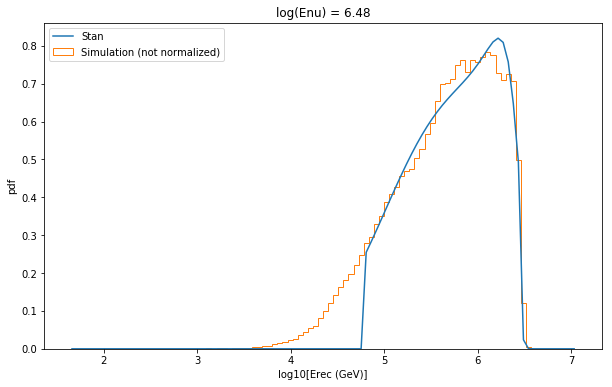

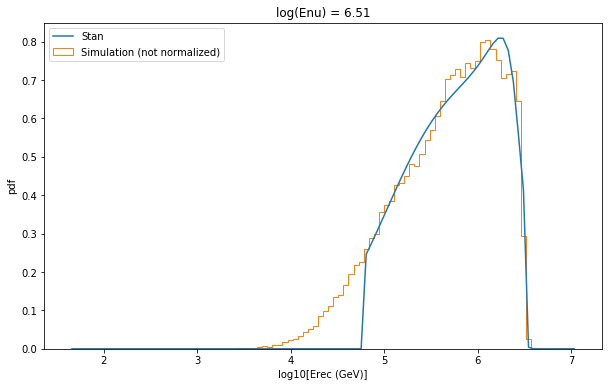

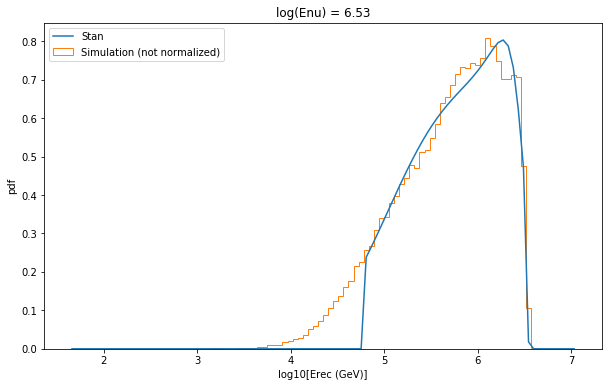

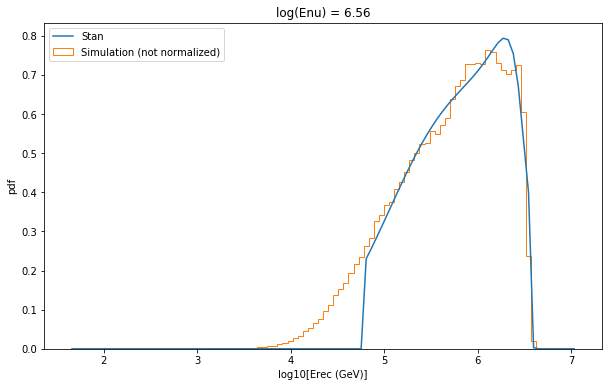

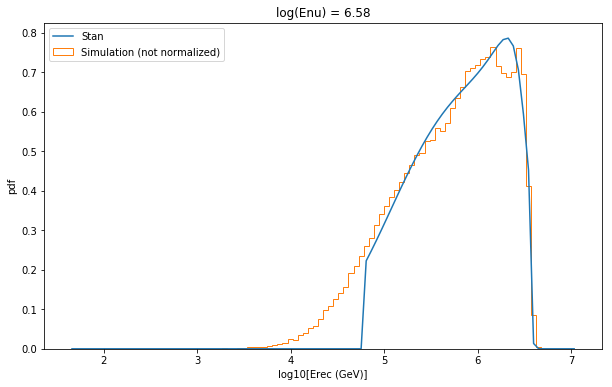

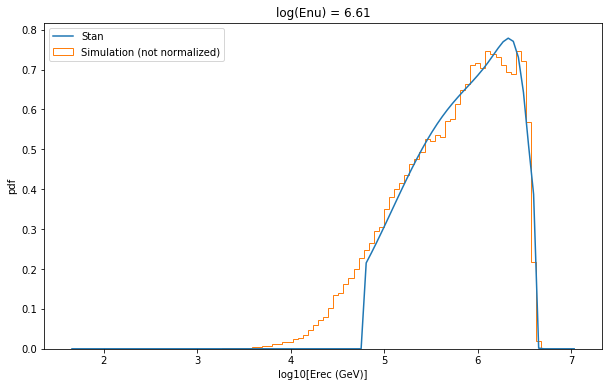

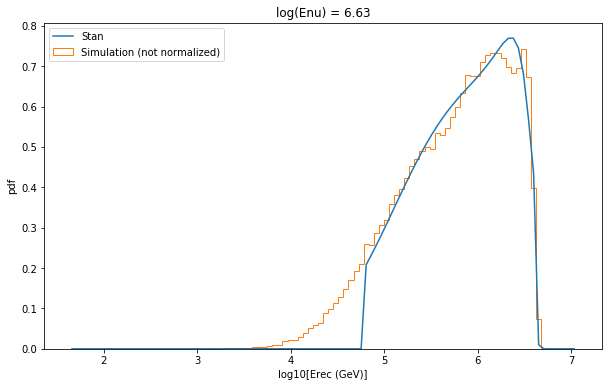

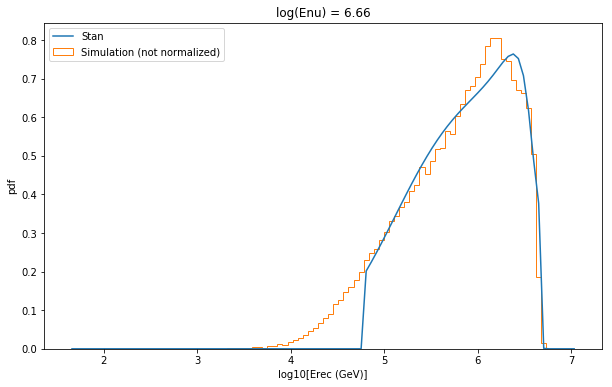

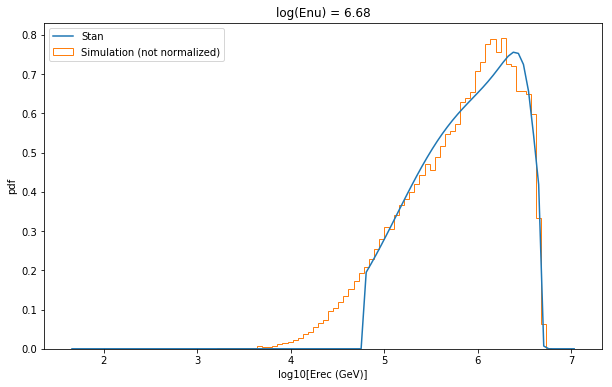

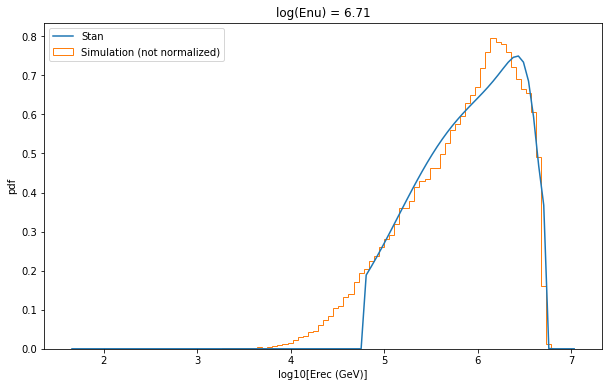

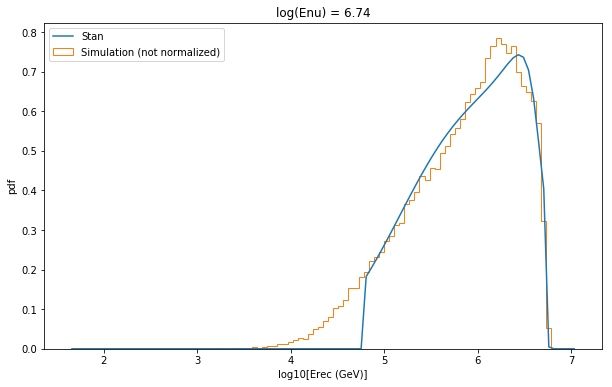

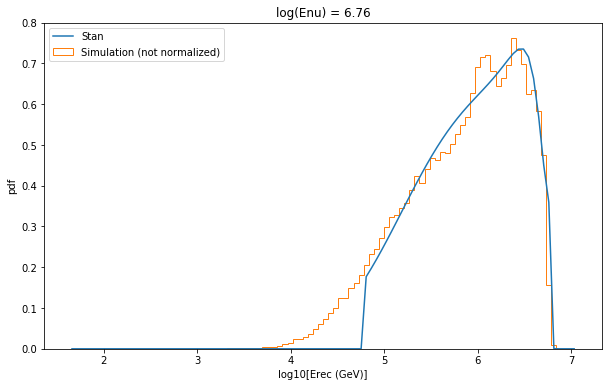

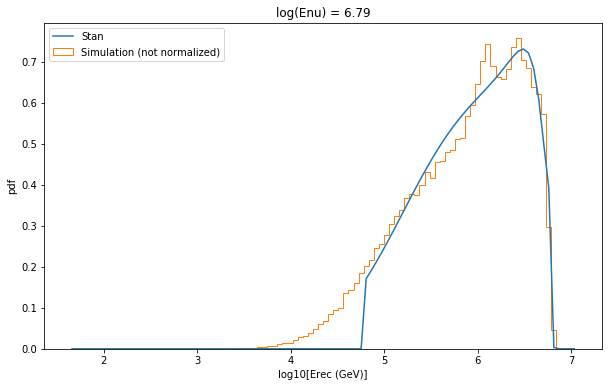

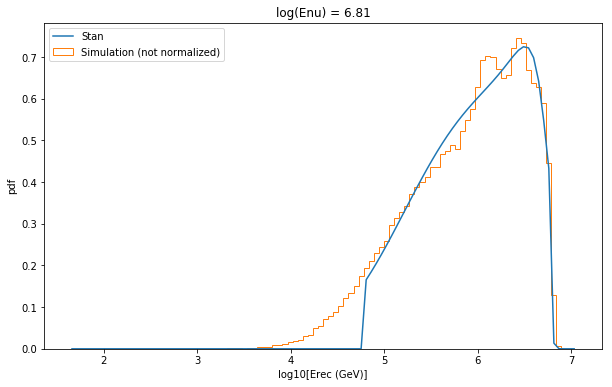

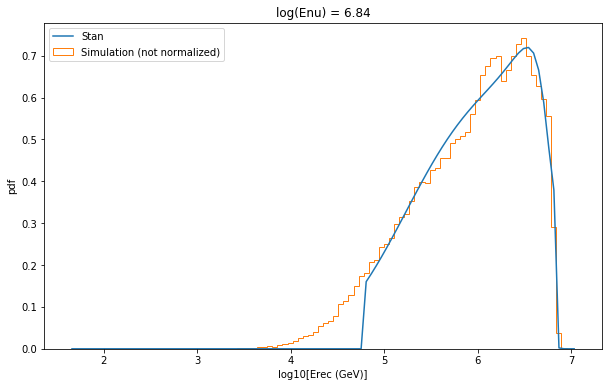

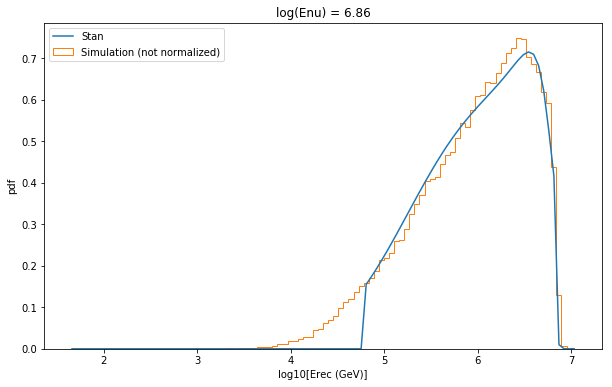

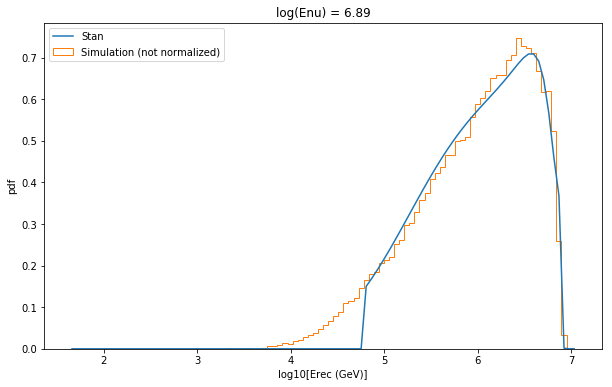

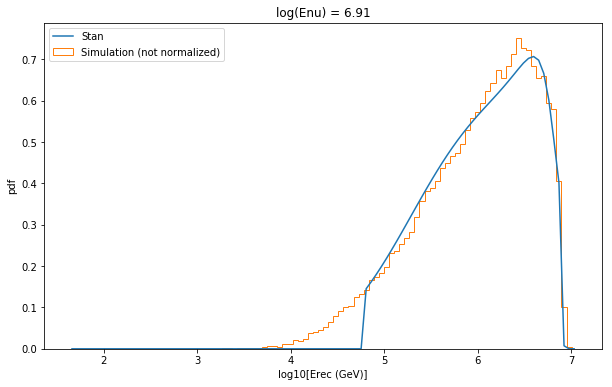

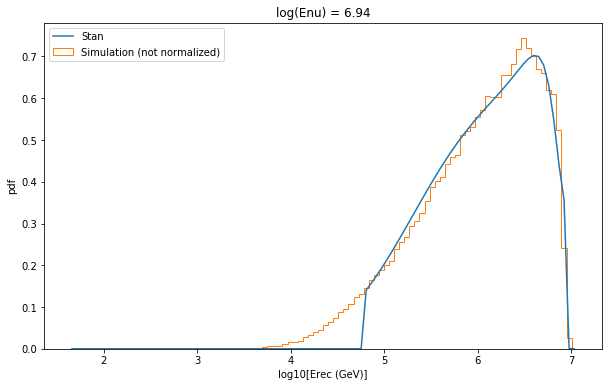

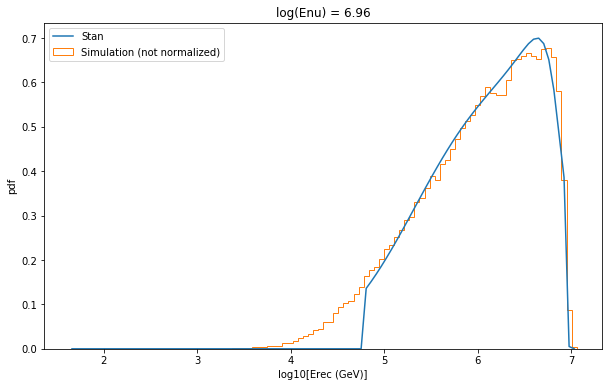

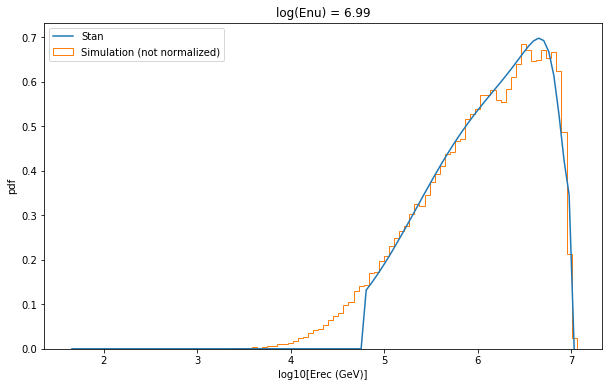

In [41]:
for enu, sl in zip(eprim_bins_NC, binc_NC):
    x = erec_bins_NC
    N = len(erec_bins_NC)
    
    N_pars, N_deg_max = poly_coeffs.shape
    
    
    param_pars = {
        'N': N,
        'x': x,
        'N_pars': N_pars,
        'N_degree_max': N_deg_max,
        'par_coeffs': poly_coeffs,
        'enu': enu
    }
    
    
    cascade_output = cascade_NC.sampling(data=param_pars, algorithm='Fixed_param', iter=1, chains=1)
    prob = (cascade_output.extract('y')['y'][0])
    plt.figure(figsize=(10,6))
    plt.title('log(Enu) = %.2f' %(enu))
    plt.plot(erec_bins_NC, np.exp(prob), label='Stan')
    idx = np.where(erec_bins_NC > np.log10(6e4))
    sl = sl / sl.sum() / erec_binw_NC
    # norm to HESE cut
    norm = np.sum(sl[idx]) * erec_binw_NC
    plt.hist(erec_bins_NC, weights=sl/norm, bins=erec_edges_NC, label='Simulation (not normalized)', histtype='step')
#     plt.axvline(enu*1.05, c='r', ls='--')
    plt.legend()
#     plt.yscale('log')
    plt.xlabel('log10[Erec (GeV)]')
    plt.ylabel('pdf')
    plt.show()